### [1] Requirements
Import dependencies and configure the notebook runtime.

In [1]:
# [2]

import re
import os, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite, TiffFile
from skimage import filters, exposure, transform, feature, measure, registration, img_as_float32
from skimage.transform import SimilarityTransform, AffineTransform, warp
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

# Optional OpenCV (accelerated NCC); guarded import
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

import matplotlib.pyplot as plt

print("HAS_CV2:", HAS_CV2)

HAS_CV2: True


### [3] Paths & I/O
Set dataset roots, infer key file paths, and prepare output dirs.

In [2]:
# [4]
# --- Paths (auto-discovered) ---
from pathlib import Path
import json
import re
import pandas as pd

NAS_ROOT = Path('/Volumes/jlarsch/default/D2c/07_Data')
OWNER = 'Matilde'
FISH_ID = 'L396_f05'
# OWNER = 'Danin'
# FISH_ID = 'L395_f11'

MATCHING_METADATA_CSV = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/matchingMetadata.csv")

POLARITY = globals().get("POLARITY", None)
if POLARITY is None and MATCHING_METADATA_CSV.exists():
    try:
        _md = pd.read_csv(MATCHING_METADATA_CSV)
        _row = _md.loc[_md["fish_id"].astype(str) == str(FISH_ID)]
        if _row.empty:
            print(f"[WARN] No metadata row for fish_id={FISH_ID} in {MATCHING_METADATA_CSV}")
        else:
            POLARITY = str(_row.iloc[0].get("polarity", "")).strip().lower() or None
    except Exception as _e:
        print(f"[WARN] Failed to read polarity from {MATCHING_METADATA_CSV}: {_e}")
if POLARITY is not None:
    POLARITY = str(POLARITY).strip().lower()
if POLARITY not in (None, "north", "south"):
    print(f"[WARN] Unexpected polarity for {FISH_ID}: {POLARITY}")
print(f"[Paths] POLARITY={POLARITY}")

def owner_root(nas_root, owner):
    base = nas_root / owner
    mic = base / 'Microscopy'
    return mic if mic.exists() else base


FISH_DIR = owner_root(NAS_ROOT, OWNER) / FISH_ID
PREPROC_DIR = FISH_DIR / "02_reg" / "00_preprocessing"
ANALYSIS_DIR = FISH_DIR / '03_analysis'
OUTDIR = ANALYSIS_DIR / 'functional'
OUT_RAW = OUTDIR / 'raw'
OUT_SEG = OUTDIR / 'segmentation'
OUT_REG = OUTDIR / 'registration'
OUT_NCC = OUTDIR / 'ncc'
OUT_QA = OUTDIR / 'qa'
OUT_DERIVED = OUTDIR / 'derived'
OUT_HCR = OUTDIR / 'hcr_in_func'
for _d in (OUTDIR, OUT_RAW, OUT_SEG, OUT_REG, OUT_NCC, OUT_QA, OUT_DERIVED, OUT_HCR):
    _d.mkdir(parents=True, exist_ok=True)

REF_DIR = OUT_REG / 'reference_planes'
REF_DIR.mkdir(parents=True, exist_ok=True)

TMP_CONVERT_DIR = OUT_RAW / 'converted_nrrd_to_tif'
TMP_CONVERT_DIR.mkdir(parents=True, exist_ok=True)


def first_match(globs, desc, all_hits=False):
    hits_all = []
    for g in globs:
        hits = sorted(FISH_DIR.glob(g))
        hits_all.extend(hits)
    if all_hits:
        if not hits_all:
            print(f"[WARN] No match for {desc} (patterns: {globs})")
        return hits_all
    if hits_all:
        return hits_all[0]
    print(f"[WARN] No match for {desc} (patterns: {globs})")
    return None




def _scanimage_find_first(obj, key):
    key_lower = key.lower()
    if isinstance(obj, dict):
        for k, v in obj.items():
            if k.lower() == key_lower:
                return v
            found = _scanimage_find_first(v, key)
            if found is not None:
                return found
    elif isinstance(obj, list):
        for v in obj:
            found = _scanimage_find_first(v, key)
            if found is not None:
                return found
    return None


def _scanimage_to_pair(val):
    if isinstance(val, (list, tuple)) and len(val) >= 2:
        return float(val[0]), float(val[1])
    if isinstance(val, (int, float)):
        return float(val), float(val)
    return None


def scanimage_um_per_px_from_artist(tiff_path):
    with TiffFile(tiff_path) as tif:
        page0 = tif.pages[0]
        artist_tag = page0.tags.get("Artist")
        if artist_tag is None:
            return None, "missing Artist tag"
        raw = artist_tag.value

    if isinstance(raw, bytes):
        raw = raw.decode(errors="replace")
    raw = raw.replace("\x00", "")
    m = re.search(r"{.*}", raw, re.S)
    if m:
        raw = m.group(0)

    try:
        data = json.loads(raw)
    except Exception:
        return None, "invalid Artist JSON"

    fov_um = _scanimage_to_pair(_scanimage_find_first(data, "imagingFovUm"))
    pixel_res = _scanimage_to_pair(_scanimage_find_first(data, "pixelResolutionXY"))
    microns_per_pixel = _scanimage_to_pair(_scanimage_find_first(data, "micronsPerPixel"))
    if microns_per_pixel is None:
        microns_per_pixel = _scanimage_to_pair(_scanimage_find_first(data, "umPerPixel"))

    if microns_per_pixel:
        return {"X": microns_per_pixel[0], "Y": microns_per_pixel[1]}, "micronsPerPixel"
    if fov_um and pixel_res:
        return {"X": fov_um[0] / pixel_res[0], "Y": fov_um[1] / pixel_res[1]}, "imagingFovUm/pixelResolutionXY"
    return None, "missing ScanImage scale"


def infer_hcr_stack_paths(preproc_dir, fish_id):
    if preproc_dir is None or not preproc_dir.exists():
        return []
    cand_dirs = [preproc_dir / "rbest", preproc_dir / "rn", preproc_dir / "confocal", preproc_dir / "hcr"]
    hits = []
    for d in cand_dirs:
        if not d.exists():
            continue
        hits.extend(sorted(d.glob(f"{fish_id}_round*_channel*.nrrd")))
        hits.extend(sorted(d.glob(f"{fish_id}_round*_channel*.tif")))
        hits.extend(sorted(d.glob(f"{fish_id}_round*_channel*.tiff")))
        hits.extend(sorted(d.glob("*HCR*.nrrd")))
        hits.extend(sorted(d.glob("*HCR*.tif")))
        hits.extend(sorted(d.glob("*HCR*.tiff")))
    out = []
    seen = set()
    for p in hits:
        if "gcamp" in p.name.lower():
            continue
        if p not in seen:
            out.append(p)
            seen.add(p)
    return out


def infer_hcr_stack_path(preproc_dir, fish_id):
    hits = infer_hcr_stack_paths(preproc_dir, fish_id)
    return hits[0] if hits else None



# Locate raw functional stack (ScanImage metadata), functional stacks, and anatomy stack
FUNC_RAW_STACK_PATH = first_match(['01_raw/2p/functional/*.tif', '01_raw/2p/functional/*.tiff'], 'raw functional stack')
FUNC_NONFLIPPED_LIST = first_match(['02_reg/00_preprocessing/2p_functional/02_motionCorrected/*mcorrected*.tif'], 'functional stack(s) (unflipped)', all_hits=True)
ANAT_STACK_PATH = first_match(['02_reg/00_preprocessing/2p_anatomy/*_anatomy_2P_GCaMP.*'], 'anatomy stack')

HCR_STACK_PATHS = infer_hcr_stack_paths(PREPROC_DIR, FISH_ID)
HCR_STACK_PATH = HCR_STACK_PATHS[0] if HCR_STACK_PATHS else None
if HCR_STACK_PATHS:
    print(f"[Paths] Using inferred HCR_STACK_PATHS (n={len(HCR_STACK_PATHS)}); default HCR_STACK_PATH={HCR_STACK_PATH}")
else:
    print("[Paths] Could not infer HCR_STACK_PATHS automatically; set HCR_STACK_PATH manually if available.")

# Flipped functional output paths (one per input)
FLIPPED_LIST = []
for p in FUNC_NONFLIPPED_LIST:
    FLIPPED_LIST.append(OUT_RAW / f"{Path(p).stem}_flipX.tif")

FUNC_LABELS_PATH = None
ANAT_LABELS_PATH = None
HCR_LABELS_PATH = None
HCR_LABELS_PATHS = []


def infer_anat_labels_path(fish_dir, fish_id):
    cand_dirs = [
        fish_dir / '03_analysis' / 'structural' / 'cp_masks',
        fish_dir / '03_analysis' / 'functional' / 'masks',
    ]
    patterns = [
        f"*{fish_id}*anatomy*cp_masks*.tif",
        f"*{fish_id}*cp_masks*.tif",
        '*anatomy*cp_masks*.tif',
        '*cp_masks*.tif',
    ]
    for d in cand_dirs:
        if not d.exists():
            continue
        for pat in patterns:
            hits = sorted(d.glob(pat))
            if hits:
                return hits[0]
    return None


def infer_hcr_label_paths(fish_dir, fish_id):
    d = fish_dir / '03_analysis' / 'confocal' / 'raw' / 'cp_masks'
    if not d.exists():
        return []
    patterns = [
        f"{fish_id}_round*_cp_masks*.tif",
        f"{fish_id}_round*.tif",
        "*round*_cp_masks*.tif",
    ]
    hits = []
    for pat in patterns:
        hits.extend(sorted(d.glob(pat)))
    uniq = []
    seen = set()
    for h in hits:
        if h not in seen:
            uniq.append(h)
            seen.add(h)
    return uniq





if ANAT_LABELS_PATH is None:
    auto_anat_lbl = infer_anat_labels_path(FISH_DIR, FISH_ID)
    if auto_anat_lbl:
        ANAT_LABELS_PATH = auto_anat_lbl
        print(f"[Paths] Using inferred ANAT_LABELS_PATH: {ANAT_LABELS_PATH}")
    else:
        print('[Paths] Could not infer ANAT_LABELS_PATH automatically; set ANAT_LABELS_PATH manually if available.')
else:
    print(f"[Paths] Using provided ANAT_LABELS_PATH: {ANAT_LABELS_PATH}")


if not HCR_LABELS_PATHS:
    auto_hcr_lbls = infer_hcr_label_paths(FISH_DIR, FISH_ID)
    if auto_hcr_lbls:
        HCR_LABELS_PATHS = auto_hcr_lbls
        if HCR_LABELS_PATH is None and HCR_LABELS_PATHS:
            HCR_LABELS_PATH = HCR_LABELS_PATHS[0]
        print(f"[Paths] Using inferred HCR_LABELS_PATHS (n={len(HCR_LABELS_PATHS)}):")
        for p in HCR_LABELS_PATHS:
            print('  ', p)
    else:
        if HCR_LABELS_PATH:
            HCR_LABELS_PATHS = [HCR_LABELS_PATH]
            print(f"[Paths] Using provided HCR_LABELS_PATH: {HCR_LABELS_PATH}")
        else:
            print('[Paths] Could not infer HCR_LABELS_PATHS automatically; set HCR_LABELS_PATH(S) manually if available.')
elif HCR_LABELS_PATHS and HCR_LABELS_PATH is None:
    HCR_LABELS_PATH = HCR_LABELS_PATHS[0]
    print(f"[Paths] Using provided HCR_LABELS_PATHS (n={len(HCR_LABELS_PATHS)}); default HCR_LABELS_PATH = {HCR_LABELS_PATH}")


VOX_FUNC_AUTO = None
if FUNC_RAW_STACK_PATH:
    try:
        VOX_FUNC_AUTO, _vox_src = scanimage_um_per_px_from_artist(FUNC_RAW_STACK_PATH)
        if VOX_FUNC_AUTO:
            print(f"[Vox] Func um/px from raw ({_vox_src}): {VOX_FUNC_AUTO}")
        else:
            print("[Vox] No functional scale found in raw metadata.")
    except Exception as _e:
        print(f"[Vox] Failed to read raw functional metadata: {_e}")
else:
    print("[Vox] Raw functional stack not found; set FUNC_RAW_STACK_PATH to enable auto scale.")

# Functional orientation (always flip X; rotate 180 when polarity is north)
POLARITY_NORTH = str(POLARITY).lower() == "north"
if POLARITY_NORTH:
    print("[Paths] Functional polarity north -> rotate 180 deg + flip X")
else:
    print("[Paths] Functional polarity south/unknown -> flip X")

def _apply_func_orientation(arr):
    if arr is None:
        return None
    try:
        ndim = arr.ndim
    except Exception:
        return arr
    if ndim < 2:
        return arr
    out = arr
    if POLARITY_NORTH:
        out = out[..., ::-1, ::-1]
    out = out[..., ::-1]
    return out

REF_BUILD_STRATEGY = 'time_mean'
OVERWRITE_FLIPPED = False  # overwrite flipped stacks if they already exist (avoid stale data)
REUSE_SAVED_REFS = True  # reuse cached ref images if present (set False to rebuild like legacy)
MAX_FRAMES_FOR_REF = 1000

# Optional manual overrides (set if auto-detection fails)
VOX_FUNC_MANUAL = VOX_FUNC_AUTO or {}
VOX_ANAT_MANUAL = {}
VOX_HCR_MANUAL = {}
VOX_CACHE_PATH = ANALYSIS_DIR / "voxel_sizes.json"

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
WARP_HCR_INTENSITY_QC = globals().get("WARP_HCR_INTENSITY_QC", False)
HCR_INTENSITY_PATHS = globals().get("HCR_INTENSITY_PATHS", None)



[Paths] POLARITY=north
[Paths] Using inferred HCR_STACK_PATHS (n=6); default HCR_STACK_PATH=/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/rbest/L396_f05_round1_channel2_sst1_1.nrrd
[Paths] Using inferred ANAT_LABELS_PATH: /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/structural/cp_masks/L396_f05_anatomy_2P_GCaMP_cp_masks.tif
[Paths] Using inferred HCR_LABELS_PATHS (n=4):
   /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/confocal/raw/cp_masks/L395_f11_round1_channel2_sst1_1_cp_masks.tif
   /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/confocal/raw/cp_masks/L395_f11_round1_channel3_pth2_cp_masks.tif
   /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/confocal/raw/cp_masks/L395_f11_round2_channel2_sst1_2_cp_masks.tif
   /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/confocal/raw/cp_masks/L395_f11_ro

### [5] Utility functions
Helper routines for image I/O, transforms, voxel inference, and measurements.

In [3]:
# [6]
def imread_any(path):
    p = Path(path)
    ext = p.suffix.lower()
    if ext == '.nrrd':
        try:
            import nrrd
            data, _ = nrrd.read(str(p))
            return np.asarray(data)
        except Exception:
            try:
                import SimpleITK as sitk
                data = sitk.GetArrayFromImage(sitk.ReadImage(str(p)))
                return np.asarray(data)
            except Exception as e_sitk:
                raise ImportError('Reading .nrrd requires pynrrd or SimpleITK') from e_sitk
    return imread(path)


def zproject_mean(stack):
    return stack.mean(axis=0)

def norm01(img):
    img = img.astype(np.float32)
    m, M = np.percentile(img, (1, 99))
    if M <= m:
        M = img.max(); m = img.min()
    out = np.clip((img - m) / (M - m + 1e-6), 0, 1)
    return out

def local_unsharp(img, blur_sigma=1.0, amount=0.6):
    base = ndi.gaussian_filter(img, blur_sigma)
    return np.clip(base + amount*(img - base), 0, 1)

def corrcoef_img(a, b):
    # Pearson correlation between 2D arrays
    a = a.astype(np.float32); b = b.astype(np.float32)
    am = a.mean(); bm = b.mean()
    num = ((a - am)*(b - bm)).sum()
    den = np.sqrt(((a - am)**2).sum() * ((b - bm)**2).sum()) + 1e-8
    return float(num / den)

def top_correlated_mean(stack_t, take_k=20, pre_smooth_sigma=0.5):
    """Suite2p-like: build crisp reference by selecting top-K frames most correlated to a provisional mean."""
    T, H, W = stack_t.shape
    # Provisional mean
    m0 = stack_t.mean(axis=0)
    # Optional pre-smoothing to reduce shot noise
    if pre_smooth_sigma and pre_smooth_sigma > 0:
        m0s = ndi.gaussian_filter(m0, pre_smooth_sigma)
    else:
        m0s = m0
    # Correlate each frame with provisional mean
    corrs = np.empty(T, dtype=np.float32)
    for i in range(T):
        fi = stack_t[i]
        if pre_smooth_sigma and pre_smooth_sigma > 0:
            fi = ndi.gaussian_filter(fi, pre_smooth_sigma)
        corrs[i] = corrcoef_img(fi, m0s)
    # Take top-K
    k = min(take_k, T)
    idx = np.argsort(corrs)[-k:]
    ref = stack_t[idx].mean(axis=0)
    return ref, idx, corrs

def best_z_by_ncc(template, anat_stack, use_cv2=True):
    """Return best Z index and NCC scores over Z for a 2D template vs 3D stack."""
    template = norm01(template)
    scores = []
    if use_cv2 and HAS_CV2:
        templ = (template*255).astype(np.uint8)
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            sl8 = (sl*255).astype(np.uint8)
            res = cv2.matchTemplate(sl8, templ, cv2.TM_CCORR_NORMED)
            # Whole-image match: template same size; if not, slide template and take max.
            if res.size == 1:
                s = float(res.ravel()[0])
            else:
                s = float(res.max())
            scores.append(s)
    else:
        # fallback: NCC with same-size images, or sliding template if sizes differ
        for z in range(anat_stack.shape[0]):
            sl = norm01(anat_stack[z])
            if sl.shape == template.shape:
                s = corrcoef_img(template, sl)
            else:
                try:
                    res = feature.match_template(sl, template, pad_input=False)
                    s = float(res.max())
                except Exception:
                    tmpl = transform.resize(template, sl.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
                    s = corrcoef_img(tmpl, sl)
            scores.append(s)
    scores = np.asarray(scores, dtype=np.float32)
    best_z = int(np.argmax(scores))
    return best_z, scores


def estimate_inplane_transform(mov, ref, method='similarity'):
    """Estimate 2D transform from moving image (mov) to reference (ref).
    Tries ORB+RANSAC; falls back to phase cross-correlation (shift only)."""
    m = norm01(mov); r = norm01(ref)
    # ORB keypoints
    try:
        detector = feature.ORB(n_keypoints=2000, fast_threshold=0.05)
        detector.detect_and_extract(img_as_float32(m))
        kp1 = detector.keypoints; d1 = detector.descriptors
        detector.detect_and_extract(img_as_float32(r))
        kp2 = detector.keypoints; d2 = detector.descriptors
        if len(kp1) >= 10 and len(kp2) >= 10 and d1 is not None and d2 is not None:
            matches12 = feature.match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
            src = kp1[matches12[:, 0]][:, ::-1]  # (x,y)
            dst = kp2[matches12[:, 1]][:, ::-1]
            if method == 'similarity':
                model, inliers = measure.ransac((src, dst), SimilarityTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            else:
                model, inliers = measure.ransac((src, dst), AffineTransform,
                                                min_samples=3, residual_threshold=2.0, max_trials=2000)
            if model is not None:
                return model
    except Exception as e:
        pass
    # Fallback: phase correlation for shift
    shift, _, _ = registration.phase_cross_correlation(r, m, upsample_factor=10)
    tform = SimilarityTransform(translation=(shift[1], shift[0]))
    return tform

def refine_affine_ecc(mov, ref, init_tform=None, max_iters=200, eps=1e-6, pyr_levels=3):
    """Refine an in-plane transform with OpenCV ECC (intensity-based), using affine model.
    Returns an AffineTransform that maps mov → ref.
    Strategy: pre-warp mov with init_tform into ref-shape, then run ECC starting from identity; compose.
    """
    if not HAS_CV2:
        return init_tform if init_tform is not None else AffineTransform()
    r = img_as_float32(norm01(ref))
    # Pre-warp moving with init transform to match ref shape (if provided)
    if init_tform is None:
        m0 = img_as_float32(norm01(mov))
        if m0.shape != r.shape:
            m0 = transform.resize(m0, r.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        W_init = np.eye(3, dtype=np.float32)
    else:
        m0 = apply_transform_2d(img_as_float32(norm01(mov)), init_tform, output_shape=r.shape, order=1)
        W_init = init_tform.params.astype(np.float32)
    # ECC from identity
    W_ecc = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, int(max_iters), float(eps))
    try:
        cc, Wopt = cv2.findTransformECC(r, m0, W_ecc, cv2.MOTION_AFFINE, criteria, None, pyr_levels)
        A_ecc = np.eye(3, dtype=np.float32); A_ecc[:2, :]= Wopt
        # Compose: first init, then ECC refinement in ref frame
        A_final = A_ecc @ W_init
        return AffineTransform(matrix=A_final)
    except Exception:
        return init_tform if init_tform is not None else AffineTransform()

def apply_transform_2d(img, tform, output_shape=None, order=1, preserve_range=True):
    if output_shape is None:
        output_shape = img.shape
    warped = warp(img, inverse_map=tform.inverse, output_shape=output_shape, order=order,
                  preserve_range=preserve_range, mode='constant', cval=0.0, clip=True)
    return warped

def resample_labels_nn(img, tform, output_shape=None):
    # nearest-neighbor for label images
    return apply_transform_2d(img, tform, output_shape=output_shape, order=0, preserve_range=True)

def apply_anat_to_hcr_warp_2d(slice_img, z_index, warp3d_func):
    """Hook to apply a 3D warp (anatomy→HCR) to a 2D slice.
    `warp3d_func` should accept (z,y,x) indices or coordinates and return warped image in HCR coords.
    For now this is a placeholder you can implement with your BigWarp/ANTs output.
    """
    return warp3d_func(slice_img, z_index)

def quickshow(img, title='', vmin=None, vmax=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img, vmin=vmin, vmax=vmax)
    plt.title(title); plt.axis('off'); plt.show()

def _to_um(val, unit):
    try:
        v = float(val)
    except Exception:
        return None
    if unit is None:
        return None
    u = str(unit).lower()
    if u in ('µm', 'um', 'micron', 'microns', 'micrometer', 'micrometers', 'micrometre', 'micrometres'):
        return v
    if u in ('nm', 'nanometer', 'nanometre'):
        return v / 1000.0
    if u in ('mm', 'millimeter', 'millimetre'):
        return v * 1000.0
    if u in ('cm', 'centimeter', 'centimetre'):
        return v * 10000.0
    if u in ('in', 'inch', 'inches'):
        return v * 25400.0
    return None

def _res_to_um_per_px(res_tag, unit_tag):
    try:
        num, den = getattr(res_tag, 'value', (None, None))
        if num is None or den is None:
            v = float(getattr(res_tag, 'value', None))
            ppu = v
        else:
            ppu = float(num) / float(den)
    except Exception:
        return None
    unit_val = getattr(unit_tag, 'value', unit_tag)
    try:
        u = str(unit_val).upper()
    except Exception:
        u = 'NONE'
    if u == '2' or 'INCH' in u:
        return 25400.0 / ppu
    if u == '3' or 'CENTIMETER' in u or 'CM' in u:
        return 10000.0 / ppu
    return None



def _parse_nrrd_header_text(text):
    hdr = {}
    for line in text.splitlines():
        if not line:
            if hdr:
                break
            continue
        if line.startswith("#"):
            continue
        if ":" not in line:
            continue
        k, v = line.split(":", 1)
        hdr[k.strip().lower()] = v.strip()
    return hdr or None

def _find_embedded_nrrd_header(path, max_bytes=1000000):
    try:
        with open(path, "rb") as f:
            data = f.read(max_bytes)
    except Exception:
        return None
    sig_ascii = data.find(b"NRRD000")
    sig_utf16 = data.find(b"N\x00R\x00R\x00D\x000\x000\x000")
    if sig_ascii != -1:
        chunk = data[sig_ascii:sig_ascii + 65536]
        text = chunk.decode("latin-1", errors="replace")
    elif sig_utf16 != -1:
        chunk = data[sig_utf16:sig_utf16 + 131072]
        text = chunk.replace(b"\x00", b"").decode("latin-1", errors="replace")
    else:
        return None
    return _parse_nrrd_header_text(text)

def _infer_voxels_nrrd(path):
    try:
        with open(path, "rb") as f:
            header = b""
            for _ in range(512):
                line = f.readline()
                if not line:
                    break
                header += line
                if line.strip() == b"":
                    break
                if len(header) > 65536:
                    break
    except Exception:
        return None
    try:
        text = header.decode("latin-1", errors="replace")
    except Exception:
        return None
    hdr = _parse_nrrd_header_text(text) or {}
    if ("space directions" not in hdr) and ("spacings" not in hdr):
        embedded = _find_embedded_nrrd_header(path)
        if embedded:
            hdr = embedded
    if not hdr:
        return None
    unit = "um"
    if "space units" in hdr:
        parts = [p for p in hdr["space units"].split("\"") if p.strip()]
        if parts:
            unit = parts[0]
    spacings = []
    if "space directions" in hdr:
        dirs = re.findall(r"\(([^\)]+)\)", hdr["space directions"])
        for d in dirs:
            if "none" in d.lower():
                spacings.append(None)
                continue
            parts = [p for p in re.split(r"[ ,]+", d.strip()) if p]
            try:
                nums = [float(p) for p in parts]
            except Exception:
                spacings.append(None)
                continue
            mag = sum(n * n for n in nums) ** 0.5
            spacings.append(mag)
    elif "spacings" in hdr:
        parts = [p for p in hdr["spacings"].replace(",", " ").split() if p]
        try:
            spacings = [float(p) for p in parts]
        except Exception:
            return None
    else:
        return None
    vox = {"X": None, "Y": None, "Z": None}
    axes = ["X", "Y", "Z"]
    for i, sp in enumerate(spacings[:3]):
        if sp is None:
            continue
        v = _to_um(sp, unit)
        if v:
            vox[axes[i]] = v
    return vox

def infer_voxels_tiff(path):
    vox = {'Z': None, 'Y': None, 'X': None}

    try:
        p = Path(path)
        if p.suffix.lower() == ".nrrd":
            vox_nrrd = _infer_voxels_nrrd(p)
            if vox_nrrd:
                return vox_nrrd
    except Exception:
        pass
    try:
        with TiffFile(str(path)) as tf:
            # OME-XML
            omexml = None
            try:
                omexml = tf.ome_metadata
            except Exception:
                omexml = None
            if omexml:
                try:
                    import xml.etree.ElementTree as ET
                    root = ET.fromstring(omexml)
                    # find any Pixels element regardless of namespace
                    pix = root.find('.//{*}Pixels')
                    if pix is not None:
                        px = pix.attrib.get('PhysicalSizeX'); pxu = pix.attrib.get('PhysicalSizeXUnit')
                        py = pix.attrib.get('PhysicalSizeY'); pyu = pix.attrib.get('PhysicalSizeYUnit')
                        pz = pix.attrib.get('PhysicalSizeZ'); pzu = pix.attrib.get('PhysicalSizeZUnit')
                        if py is not None:
                            v = _to_um(py, pyu or 'um')
                            if v: vox['Y'] = v
                        if px is not None:
                            v = _to_um(px, pxu or 'um')
                            if v: vox['X'] = v
                        if pz is not None:
                            v = _to_um(pz, pzu or 'um')
                            if v: vox['Z'] = v
                except Exception:
                    pass
            # ImageJ metadata (Z spacing)
            try:
                ij = tf.imagej_metadata or {}
                if isinstance(ij, dict):
                    zsp = ij.get('spacing', None)
                    unit = ij.get('unit', 'um')
                    if vox['Z'] is None and zsp is not None:
                        vz = _to_um(zsp, unit)
                        if vz: vox['Z'] = vz
            except Exception:
                pass
            # Resolution tags → X/Y
            try:
                page0 = tf.pages[0]
                xr = page0.tags.get('XResolution', None)
                yr = page0.tags.get('YResolution', None)
                ru = page0.tags.get('ResolutionUnit', None)
                if vox['X'] is None and xr is not None and ru is not None:
                    vx = _res_to_um_per_px(xr, ru)
                    if vx: vox['X'] = vx
                if vox['Y'] is None and yr is not None and ru is not None:
                    vy = _res_to_um_per_px(yr, ru)
                    if vy: vox['Y'] = vy
            except Exception:
                pass
            # Parse ImageDescription for XY pixel size if still missing
            try:
                page0 = tf.pages[0]
                desc = None
                try:
                    desc = page0.description
                except Exception:
                    pass
                if desc is None:
                    try:
                        tag = page0.tags.get('ImageDescription', None)
                        desc = getattr(tag, 'value', None)
                    except Exception:
                        desc = None
                if desc is not None:
                    try:
                        text = desc.decode('utf-8', 'ignore') if isinstance(desc, (bytes, bytearray)) else str(desc)
                    except Exception:
                        text = str(desc)
                    kv = {}
                    for line in text.replace('\r', '\n').split('\n'):
                        if '=' in line:
                            k, v = line.split('=', 1)
                            kv[k.strip()] = v.strip()
                    unit = kv.get('unit', kv.get('Unit', 'um'))
                    px = kv.get('pixelWidth') or kv.get('PixelWidth') or kv.get('XPixelSize') or kv.get('micronsPerPixelX') or kv.get('MicronsPerPixelX') or kv.get('umPerPixelX') or kv.get('UmPerPixelX') or kv.get('X_UM_PER_PIXEL')
                    py = kv.get('pixelHeight') or kv.get('PixelHeight') or kv.get('YPixelSize') or kv.get('micronsPerPixelY') or kv.get('MicronsPerPixelY') or kv.get('umPerPixelY') or kv.get('UmPerPixelY') or kv.get('Y_UM_PER_PIXEL')
                    both = kv.get('PixelSizeUm') or kv.get('pixelSizeUm') or kv.get('PixelSize')
                    if both is not None:
                        try:
                            val = float(both)
                            if vox['X'] is None: vox['X'] = val
                            if vox['Y'] is None: vox['Y'] = val
                        except Exception:
                            pass
                    if vox['X'] is None and px is not None:
                        vx = _to_um(px, unit)
                        if vx: vox['X'] = vx
                    if vox['Y'] is None and py is not None:
                        vy = _to_um(py, unit)
                        if vy: vox['Y'] = vy
            except Exception:
                pass
    except Exception:
        pass
    return vox

def load_or_cache_voxels(path, alias):
    force = bool(globals().get("FORCE_RECOMPUTE_VOXELS", False))
    cache = {}
    if VOX_CACHE_PATH.exists():
        try:
            with open(VOX_CACHE_PATH, 'r') as f:
                cache = json.load(f)
        except Exception:
            cache = {}
    by_path = cache.get('by_path', {})
    pkey = str(Path(path))
    if (not force) and pkey in by_path:
        cached = by_path[pkey]
        # If cached entry is incomplete, try to re-infer now
        try:
            incomplete = cached is None or any(cached.get(ax) is None for ax in ('X','Y','Z'))
        except Exception:
            incomplete = True
        if not incomplete:
            return cached
        # Re-infer and update cache
        vox = infer_voxels_tiff(path)
        cache.setdefault('by_path', {})[pkey] = vox
        cache.setdefault('by_alias', {})[alias] = vox
        try:
            with open(VOX_CACHE_PATH, 'w') as f:
                json.dump(cache, f, indent=2)
        except Exception:
            pass
        return vox
    vox = infer_voxels_tiff(path)
    cache.setdefault('by_path', {})[pkey] = vox
    cache.setdefault('by_alias', {})[alias] = vox
    try:
        with open(VOX_CACHE_PATH, 'w') as f:
            json.dump(cache, f, indent=2)
    except Exception:
        pass
    return vox

def rescale_to_match_xy(img, vox_src, vox_dst, order=1):
    try:
        sy = float(vox_src.get('Y')) / float(vox_dst.get('Y'))
        sx = float(vox_src.get('X')) / float(vox_dst.get('X'))
    except Exception:
        return img
    if not np.isfinite(sy) or not np.isfinite(sx):
        return img
    if abs(sy - 1.0) < 1e-3 and abs(sx - 1.0) < 1e-3:
        return img
    out_shape = (max(1, int(round(img.shape[0] * sy))), max(1, int(round(img.shape[1] * sx))))
    return transform.resize(img, out_shape, order=order, preserve_range=True, anti_aliasing=True).astype(np.float32)    

def _ensure_uint_labels(arr):
    arr = np.asarray(arr)
    if not np.issubdtype(arr.dtype, np.integer):
        arr = arr.astype(np.int64)
    return arr

def _regionprops_centroids_2d(label_img):
    tbl = measure.regionprops_table(label_img, properties=['label', 'centroid'])
    df = pd.DataFrame(tbl).rename(columns={'centroid-0': 'cy', 'centroid-1': 'cx'})
    df = df[df['label'] != 0].reset_index(drop=True)
    return df

def _apply_tform_points_xy(tform, x, y):
    pts = np.stack([x, y], axis=1)
    pts_t = tform(pts)
    return pts_t[:,0], pts_t[:,1]

def diameters_um_from_array(arr, vox, axis_order=('Z','Y','X')):
    """Compute per-label diameters along Z/Y/X in µm from a 3D label array.
    Expects vox like {'Z': dz, 'Y': dy, 'X': dx}.
    """
    from skimage.measure import regionprops_table
    arr = np.asarray(arr)
    if arr.ndim != 3:
        raise ValueError('diameters_um_from_array expects a 3D label array (Z,Y,X)')
    props = regionprops_table(arr, properties=('label','bbox'))
    df = pd.DataFrame(props)
    if df.empty:
        return pd.DataFrame(columns=['label','z_um','y_um','x_um'])
    df = df.rename(columns={
        'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin',
        'bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'
    })
    dz = float(vox.get('Z', 1.0)); dy = float(vox.get('Y', 1.0)); dx = float(vox.get('X', 1.0))
    df['z_um'] = (df['zmax'] - df['zmin']) * dz
    df['y_um'] = (df['ymax'] - df['ymin']) * dy
    df['x_um'] = (df['xmax'] - df['xmin']) * dx
    df = df[['label','z_um','y_um','x_um']].copy()
    df['label'] = df['label'].astype(int)
    return df


In [4]:
# HCR matching/QC helpers (antsQC-style)

import numpy as _np
import pandas as _pd
from scipy.spatial import cKDTree as _cKDTree
from scipy.optimize import linear_sum_assignment as _lsa


def compute_centroids(mask):
    props = regionprops_table(mask, properties=("label", "centroid"))
    df = _pd.DataFrame(props)
    df = df.rename(columns={"centroid-0": "z", "centroid-1": "y", "centroid-2": "x"})
    df = df[df["label"] != 0].reset_index(drop=True)
    return df


def idx_to_um(df, vox):
    return _np.column_stack([df["z"].to_numpy() * vox["dz"], df["y"].to_numpy() * vox["dy"], df["x"].to_numpy() * vox["dx"]])


def nearest_neighbor_match(P_src_um, P_dst_um):
    tree = _cKDTree(P_dst_um)
    dists, nn = tree.query(P_src_um, k=1)
    return dists, nn


def hungarian_match(P_src_um, P_dst_um, max_cost=_np.inf):
    from scipy.spatial.distance import cdist
    C = cdist(P_src_um, P_dst_um)
    if _np.isfinite(max_cost):
        C[C > max_cost] = max_cost
    row_ind, col_ind = _lsa(C)
    dists = C[row_ind, col_ind]
    return dists, col_ind, row_ind


def compute_label_overlap(conf_labels_2p, twop_labels, min_overlap_voxels=1):
    assert conf_labels_2p.shape == twop_labels.shape, "Label volumes must share shape"
    a = conf_labels_2p.ravel(); b = twop_labels.ravel()
    m = (a != 0) & (b != 0)
    if not m.any():
        return _pd.DataFrame(columns=["conf_label", "twoP_label", "overlap_voxels"], dtype=int)
    a = a[m].astype(_np.int64, copy=False); b = b[m].astype(_np.int64, copy=False)
    key = (a << 32) | b
    uniq, counts = _np.unique(key, return_counts=True)
    conf = (uniq >> 32).astype(_np.int64)
    twop = (uniq & ((1<<32)-1)).astype(_np.int64)
    df = _pd.DataFrame({"conf_label": conf, "twoP_label": twop, "overlap_voxels": counts.astype(int)})
    if min_overlap_voxels > 1:
        df = df[df["overlap_voxels"] >= int(min_overlap_voxels)].reset_index(drop=True)
    return df


def summarize_distances(dists, valid_mask):
    dists = _np.asarray(dists); valid_mask = _np.asarray(valid_mask, dtype=bool)
    if dists.size == 0:
        return {"n": 0, "mean": 0.0, "median": 0.0, "p90": 0.0, "max": 0.0, "within_gate": 0, "within_gate_frac": 0.0}
    return {
        "n": int(dists.size),
        "mean": float(_np.mean(dists)),
        "median": float(_np.median(dists)),
        "p90": float(_np.percentile(dists, 90)),
        "max": float(_np.max(dists)),
        "within_gate": int(valid_mask.sum()),
        "within_gate_frac": float(valid_mask.mean()),
    }

def gene_from_mask(path_str):
    name = Path(path_str).name if path_str is not None else ""
    import re
    m = re.search(r'channel\d+_(.+?)_cp_masks', name)
    gene = m.group(1) if m else name
    return gene.replace('sst1_', 'sst1.')


### [7] Infer and cache voxel sizes (µm) for func/anat[/HCR] (skip if cached)
Resolve voxel sizes from headers or manual overrides and cache them.

In [5]:
# [8]
# Infer and cache voxel sizes (µm) for func/anat[/HCR] (skip if cached)
VOX_CACHE_PATH = ANALYSIS_DIR / "voxel_sizes.json"
LEGACY_VOX_CACHE_PATH = OUTDIR / "voxel_sizes.json"

FORCE_RECOMPUTE_VOXELS = True  # recompute from headers each run

def _vox_complete(vox):
    try:
        return vox and all(vox.get(ax) is not None for ax in ("X","Y","Z"))
    except Exception:
        return False

cache_data = {}
if not FORCE_RECOMPUTE_VOXELS:
    if VOX_CACHE_PATH.exists():
        try:
            import json as _json
            cache_data = _json.loads(VOX_CACHE_PATH.read_text())
        except Exception:
            cache_data = {}
    elif LEGACY_VOX_CACHE_PATH.exists():
        try:
            import json as _json
            cache_data = _json.loads(LEGACY_VOX_CACHE_PATH.read_text())
            print(f"[Info] Loaded legacy voxel cache: {LEGACY_VOX_CACHE_PATH}")
        except Exception:
            cache_data = {}

VOX_FUNC_BY_PATH = {}
func_paths = FLIPPED_LIST if "FLIPPED_LIST" in globals() and FLIPPED_LIST else ([FUNC_STACK_PATH] if "FUNC_STACK_PATH" in globals() and FUNC_STACK_PATH else [])

# Prefer functional scale from raw ScanImage metadata (same for all planes)
func_scale = None
if "VOX_FUNC_AUTO" in globals() and VOX_FUNC_AUTO:
    func_scale = dict(VOX_FUNC_AUTO)
elif "FUNC_RAW_STACK_PATH" in globals() and FUNC_RAW_STACK_PATH:
    try:
        func_scale = load_or_cache_voxels(FUNC_RAW_STACK_PATH, f"func_raw_{Path(FUNC_RAW_STACK_PATH).name}") or {}
    except Exception:
        func_scale = None

for fp in func_paths:
    key = str(fp)
    vox = cache_data.get(key, {})
    if func_scale:
        if vox is None:
            vox = {}
        if func_scale.get("X") is not None:
            vox["X"] = func_scale.get("X")
        if func_scale.get("Y") is not None:
            vox["Y"] = func_scale.get("Y")
        if vox.get("Z") is None:
            if func_scale.get("Z") is not None:
                vox["Z"] = func_scale.get("Z")
            else:
                vox["Z"] = 1.0
    if not _vox_complete(vox):
        vox = load_or_cache_voxels(fp, f"func_{Path(fp).name}") or {}
        if func_scale:
            if vox.get("X") is None and func_scale.get("X") is not None:
                vox["X"] = func_scale.get("X")
            if vox.get("Y") is None and func_scale.get("Y") is not None:
                vox["Y"] = func_scale.get("Y")
            if vox.get("Z") is None and func_scale.get("Z") is not None:
                vox["Z"] = func_scale.get("Z")
    VOX_FUNC_BY_PATH[key] = dict(vox)

detA = cache_data.get(str(ANAT_STACK_PATH), {}) if "ANAT_STACK_PATH" in globals() and ANAT_STACK_PATH else {}
if not _vox_complete(detA) and "ANAT_STACK_PATH" in globals() and ANAT_STACK_PATH:
    detA = load_or_cache_voxels(ANAT_STACK_PATH, "anat") or {}
VOX_ANAT = dict(detA or {})

HCR_STACK_PATHS = globals().get("HCR_STACK_PATHS", None)
if not HCR_STACK_PATHS and "HCR_STACK_PATH" in globals() and HCR_STACK_PATH:
    HCR_STACK_PATHS = [HCR_STACK_PATH]


VOX_HCR_BY_PATH = {}
for hp in (HCR_STACK_PATHS or []):
    key = str(hp)
    vox = cache_data.get(key, {})
    if not _vox_complete(vox):
        vox = load_or_cache_voxels(hp, f"hcr_{Path(hp).name}") or {}
    VOX_HCR_BY_PATH[key] = dict(vox)

VOX_HCR  = VOX_HCR_BY_PATH.get(str(HCR_STACK_PATH), {}) if "HCR_STACK_PATH" in globals() and HCR_STACK_PATH else None

if isinstance(globals().get("VOX_FUNC_MANUAL", None), dict):
    for key, vox in VOX_FUNC_BY_PATH.items():
        for ax in ("X","Y","Z"):
            v = VOX_FUNC_MANUAL.get(ax)
            if v is not None:
                try: vox[ax] = float(v)
                except Exception: vox[ax] = v
if isinstance(globals().get("VOX_ANAT_MANUAL", None), dict):
    for ax in ("X","Y","Z"):
        v = VOX_ANAT_MANUAL.get(ax)
        if v is not None:
            try: VOX_ANAT[ax] = float(v)
            except Exception: VOX_ANAT[ax] = v

if isinstance(globals().get("VOX_HCR_MANUAL", None), dict):
    if "VOX_HCR_BY_PATH" in globals() and VOX_HCR_BY_PATH:
        for _k, _vox in VOX_HCR_BY_PATH.items():
            for ax in ("X","Y","Z"):
                v = VOX_HCR_MANUAL.get(ax)
                if v is not None:
                    try: _vox[ax] = float(v)
                    except Exception: _vox[ax] = v
    if VOX_HCR is None:
        VOX_HCR = {}
    for ax in ("X","Y","Z"):
        v = VOX_HCR_MANUAL.get(ax)
        if v is not None:
            try: VOX_HCR[ax] = float(v)
            except Exception: VOX_HCR[ax] = v

VOX_FUNC = VOX_FUNC_BY_PATH.get(str(func_paths[0]), {}) if func_paths else {}
# Table summary for quick inspection
def _path_from_nas(p):
    if not p:
        return None
    try:
        return str(Path(p).relative_to(NAS_ROOT))
    except Exception:
        return str(p)

rows = []
for fp, vox in VOX_FUNC_BY_PATH.items():
    rows.append({
        "dataset": "func",
        "path": _path_from_nas(fp),
        "X_um": vox.get("X"),
        "Y_um": vox.get("Y"),
        "Z_um": vox.get("Z"),
    })
rows.append({
    "dataset": "anat",
    "path": _path_from_nas(ANAT_STACK_PATH) if "ANAT_STACK_PATH" in globals() and ANAT_STACK_PATH else None,
    "X_um": VOX_ANAT.get("X") if VOX_ANAT else None,
    "Y_um": VOX_ANAT.get("Y") if VOX_ANAT else None,
    "Z_um": VOX_ANAT.get("Z") if VOX_ANAT else None,
})
hcr_paths = globals().get("HCR_STACK_PATHS", None)
if not hcr_paths and "HCR_STACK_PATH" in globals() and HCR_STACK_PATH:
    hcr_paths = [HCR_STACK_PATH]
for hp in (hcr_paths or []):
    vox = VOX_HCR_BY_PATH.get(str(hp), {}) if "VOX_HCR_BY_PATH" in globals() else (VOX_HCR or {})
    rows.append({
        "dataset": "hcr",
        "path": _path_from_nas(hp),
        "X_um": vox.get("X") if vox else None,
        "Y_um": vox.get("Y") if vox else None,
        "Z_um": vox.get("Z") if vox else None,
    })
df_vox = pd.DataFrame(rows)
if not df_vox.empty:
    df_vox["complete"] = df_vox[["X_um", "Y_um", "Z_um"]].notna().all(axis=1)
try:
    from IPython.display import display as _display
except Exception:
    _display = None
with pd.option_context("display.max_colwidth", 200):
    if _display:
        _display(df_vox)
    else:
        print(df_vox.to_string(index=False))


,dataset,path,X_um,Y_um,Z_um,complete
0,func,Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane0_mcorrected_flipX.tif,0.524176,0.524176,1.0,True
1,func,Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane1_mcorrected_flipX.tif,0.524176,0.524176,1.0,True
2,func,Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane2_mcorrected_flipX.tif,0.524176,0.524176,1.0,True
3,func,Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane3_mcorrected_flipX.tif,0.524176,0.524176,1.0,True
4,func,Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05_plane4_mcorrected_flipX.tif,0.524176,0.524176,1.0,True
5,anat,Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/2p_anatomy/L396_f05_anatomy_2P_GCaMP.nrrd,0.715682,0.715682,1.0,True
6,hcr,Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/rbest/L396_f05_round1_channel2_sst1_1.nrrd,0.207566,0.207566,1.0,True
7,hcr,Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/rbest/L396_f05_round1_channel3_pth2.nrrd,0.207566,0.207566,1.0,True
8,hcr,Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/rn/L396_f05_round2_channel2_sst1_2.nrrd,0.207566,0.207566,1.0,True
9,hcr,Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/rn/L396_f05_round2_channel3_tac3b.nrrd,0.207566,0.207566,1.0,True


In [6]:
# [8a] Debug anatomy voxel scale (cache vs header)
import json
from pathlib import Path

def _read_nrrd_header(path):
    try:
        with open(path, "rb") as f:
            header = b""
            for _ in range(512):
                line = f.readline()
                if not line:
                    break
                header += line
                if line.strip() == b"":
                    break
                if len(header) > 65536:
                    break
    except Exception as e:
        return None, f"read failed: {e}"
    try:
        text = header.decode("latin-1", errors="replace")
    except Exception as e:
        return None, f"decode failed: {e}"
    hdr = {}
    for line in text.splitlines():
        if not line or line.startswith("#"):
            continue
        if ":" not in line:
            continue
        k, v = line.split(":", 1)
        hdr[k.strip().lower()] = v.strip()
    return hdr, None

def _cache_lookup(cache_path, target_path):
    if cache_path is None or not cache_path.exists() or target_path is None:
        return None
    try:
        data = json.loads(cache_path.read_text())
    except Exception as e:
        return f"read failed: {e}"
    key = str(target_path)
    if key in data:
        return data[key]
    by_path = data.get("by_path", {})
    if key in by_path:
        return by_path[key]
    return None

anat_path = ANAT_STACK_PATH if "ANAT_STACK_PATH" in globals() else None
print(f"[VoxDbg] ANAT_STACK_PATH={anat_path}")
hdr_vox = None
if anat_path and Path(anat_path).exists():
    hdr, err = _read_nrrd_header(Path(anat_path))
    if err:
        print(f"[VoxDbg] header error: {err}")
    else:
        print("[VoxDbg] nrrd space units:", hdr.get("space units"))
        print("[VoxDbg] nrrd space directions:", hdr.get("space directions"))
        hdr_vox = _infer_voxels_nrrd(Path(anat_path))
        print("[VoxDbg] inferred vox (um):", hdr_vox)
else:
    print("[VoxDbg] anatomy path missing")

cache_hits = {}
for label, cpath in (("VOX_CACHE_PATH", globals().get("VOX_CACHE_PATH")), ("LEGACY_VOX_CACHE_PATH", globals().get("LEGACY_VOX_CACHE_PATH"))):
    if cpath is None:
        continue
    val = _cache_lookup(Path(cpath), Path(anat_path) if anat_path else None)
    cache_hits[label] = val
    print(f"[VoxDbg] cache {label}={cpath} -> {val}")

def _ratio(cache_vox, hdr_vox):
    if not isinstance(cache_vox, dict) or not isinstance(hdr_vox, dict):
        return None
    out = {}
    for ax in ("X", "Y", "Z"):
        a = cache_vox.get(ax)
        b = hdr_vox.get(ax)
        if a is None or b in (None, 0):
            continue
        out[ax] = float(a) / float(b)
    return out or None

for label, vox in cache_hits.items():
    ratios = _ratio(vox, hdr_vox)
    if ratios:
        print(f"[VoxDbg] cache/header ratio for {label}: {ratios}")


[VoxDbg] ANAT_STACK_PATH=/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/02_reg/00_preprocessing/2p_anatomy/L396_f05_anatomy_2P_GCaMP.nrrd
[VoxDbg] nrrd space units: None
[VoxDbg] nrrd space directions: None
[VoxDbg] inferred vox (um): {'X': 0.7156817118326824, 'Y': 0.7156817118326824, 'Z': 1.0}
[VoxDbg] cache VOX_CACHE_PATH=/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/voxel_sizes.json -> {'X': 0.7156817118326824, 'Y': 0.7156817118326824, 'Z': 1.0}
[VoxDbg] cache LEGACY_VOX_CACHE_PATH=/Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/voxel_sizes.json -> None
[VoxDbg] cache/header ratio for VOX_CACHE_PATH: {'X': 1.0, 'Y': 1.0, 'Z': 1.0}


### [9] Flip functional stack(s) X (non-flipped input)
Flip functional stacks horizontally to match anatomy orientation.

In [7]:
# [10]
# 0) Orient functional stack(s) (flip X always; rotate 180 when polarity is north)
OVERWRITE_FLIPPED = False

import numpy as _np
def _orient_func_stack(arr):
    if "_apply_func_orientation" in globals():
        try:
            return _apply_func_orientation(arr)
        except Exception:
            pass
    if arr is None:
        return None
    if getattr(arr, "ndim", 0) < 2:
        return arr
    polarity_north = str(globals().get("POLARITY", "")).lower() == "north"
    out = arr
    if polarity_north:
        out = out[..., ::-1, ::-1]
    out = out[..., ::-1]
    return out

if FUNC_NONFLIPPED_LIST:
    polarity_north = str(globals().get("POLARITY", "")).lower() == "north"
    mode = "rot180+flipX" if polarity_north else "flipX"
    for src, dst in zip(FUNC_NONFLIPPED_LIST, FLIPPED_LIST):
        if Path(src).exists():
            if Path(dst).exists() and not OVERWRITE_FLIPPED:
                print(f"[INFO] Using existing oriented stack ({mode}): {dst}")
                continue
            arr_nf = imread(src)
            arr_or = _orient_func_stack(arr_nf)
            if arr_or.dtype == _np.int16:
                arr_or = (_np.asarray(arr_or, dtype=_np.int32) + 32768).clip(0, 65535).astype(_np.uint16)
            imwrite(dst, arr_or)
            print(f"[INFO] Saved oriented stack to {dst} (mode={mode}, dtype={arr_or.dtype})")
        else:
            print(f"[WARN] Non-flipped functional not found: {src}")
else:
    print("[WARN] No unflipped functional stacks found")


[INFO] Using existing oriented stack (rot180+flipX): /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane0_mcorrected_flipX.tif
[INFO] Using existing oriented stack (rot180+flipX): /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane1_mcorrected_flipX.tif
[INFO] Using existing oriented stack (rot180+flipX): /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane2_mcorrected_flipX.tif
[INFO] Using existing oriented stack (rot180+flipX): /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane3_mcorrected_flipX.tif
[INFO] Using existing oriented stack (rot180+flipX): /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05_plane4_mcorrected_flipX.tif


### [11] Load flipped functional data and build/reuse references
Load flipped functional stacks and build reference images for registration.

[INFO] USE_TOP_CORR_REFS=True (TOP_CORR_K=200, TOP_CORR_SAMPLE=20)
[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane0_mcorrected_flipX.tif


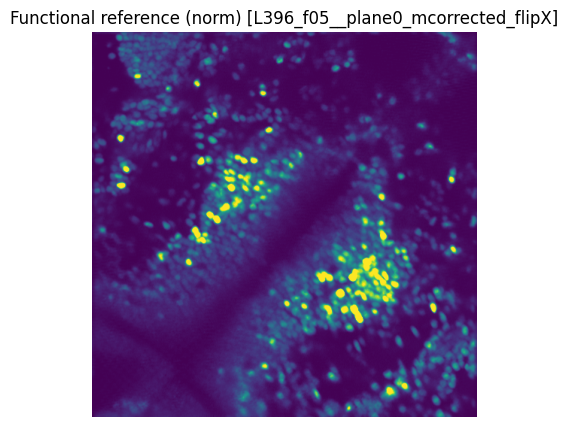

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane1_mcorrected_flipX.tif


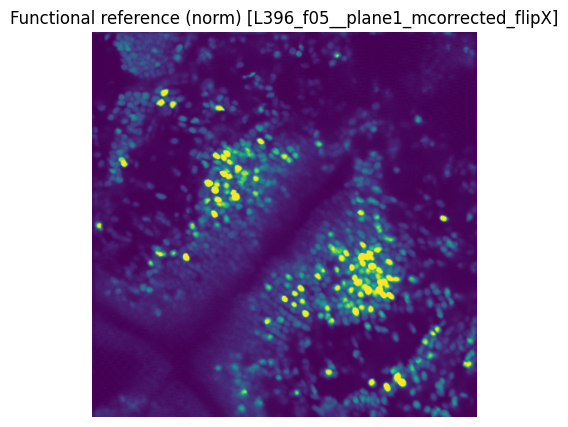

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane2_mcorrected_flipX.tif


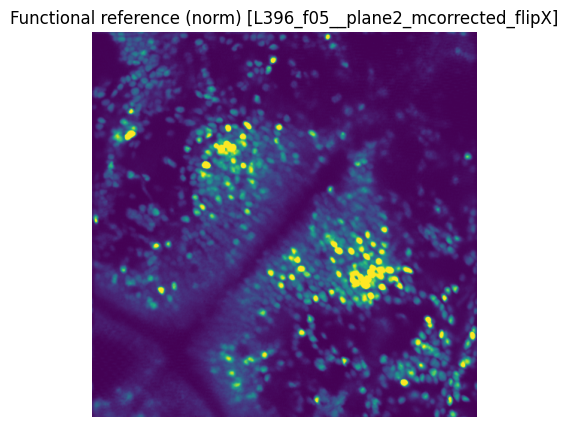

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05__plane3_mcorrected_flipX.tif


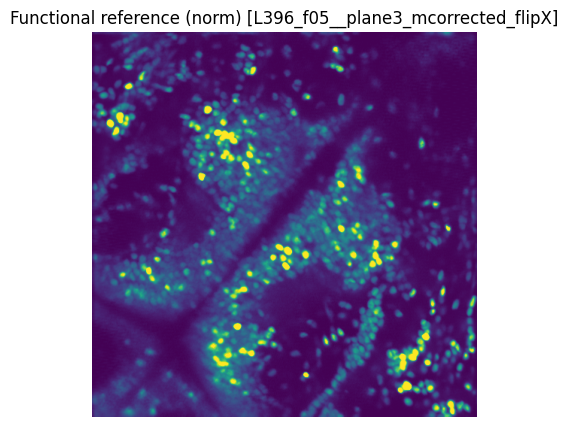

[INFO] Using existing refs for /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/L396_f05_plane4_mcorrected_flipX.tif


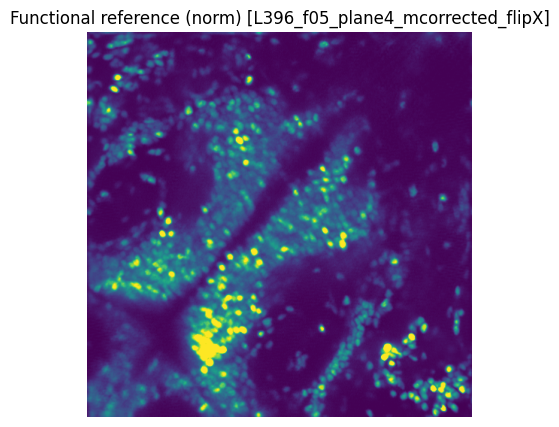

In [8]:
# [12]
# Load flipped functional data and build/reuse references
USE_TOP_CORR_REFS = True
TOP_CORR_K = 200
TOP_CORR_SAMPLE = 20
if USE_TOP_CORR_REFS:
    print(f"[INFO] USE_TOP_CORR_REFS=True (TOP_CORR_K={TOP_CORR_K}, TOP_CORR_SAMPLE={TOP_CORR_SAMPLE})")

FORCE_RECOMPUTE_REFS = False
if FORCE_RECOMPUTE_REFS:
    REUSE_SAVED_REFS = False
    print("[INFO] FORCE_RECOMPUTE_REFS=True -> rebuilding functional refs")


plane_refs = []
if not FLIPPED_LIST:
    raise FileNotFoundError("No flipped functional stacks available")
for fp in FLIPPED_LIST:
    fp = Path(fp)
    if not fp.exists():
        raise FileNotFoundError(f"Flipped functional stack not found: {fp}")
    vox_f = VOX_FUNC_BY_PATH.get(str(fp), {}) if "VOX_FUNC_BY_PATH" in globals() else {}
    stem = fp.stem
    raw_path = OUT_RAW / (stem + "_ref_raw.tif")
    norm_path = OUT_RAW / (stem + "_ref_norm.tif")
    legacy_raw_path = OUTDIR / (stem + "_ref_raw.tif")
    legacy_norm_path = OUTDIR / (stem + "_ref_norm.tif")
    plane_raws = sorted(OUT_RAW.glob(stem + "_plane*_raw.tif"))
    if not plane_raws and 'OUTDIR' in globals():
        plane_raws = sorted(OUTDIR.glob(stem + "_plane*_raw.tif"))
    if not REUSE_SAVED_REFS:
        plane_raws = []
    use_cached = REUSE_SAVED_REFS
    if use_cached and plane_raws:
        for rawp in plane_raws:
            match = re.search(r"plane(\d+)", rawp.stem)
            zi = int(match.group(1)) if match else None
            normp = rawp.parent / (stem + f"_plane{zi}_norm.tif")
            if not normp.exists():
                continue
            ref2d_raw_i = imread(rawp).astype(np.float32)
            ref2d_i = norm01(imread(normp))
            plane_refs.append({"label": f"{stem}_plane{zi}", "ref2d_raw": ref2d_raw_i, "ref2d": ref2d_i, "index": zi, "vox_func": vox_f})
            quickshow(ref2d_i, f"Functional reference (norm) [{stem} plane {zi}]")
        if plane_refs:
            continue
    if use_cached and raw_path.exists() and norm_path.exists():
        ref2d_raw = imread(raw_path).astype(np.float32)
        ref2d = norm01(imread(norm_path))
        plane_refs.append({"label": stem, "ref2d_raw": ref2d_raw, "ref2d": ref2d, "vox_func": vox_f})
        print(f"[INFO] Using existing refs for {fp}")
        quickshow(ref2d, f"Functional reference (norm) [{stem}]")
        continue
    if use_cached and legacy_raw_path.exists() and legacy_norm_path.exists():
        ref2d_raw = imread(legacy_raw_path).astype(np.float32)
        ref2d = norm01(imread(legacy_norm_path))
        plane_refs.append({"label": stem, "ref2d_raw": ref2d_raw, "ref2d": ref2d, "vox_func": vox_f})
        print(f"[INFO] Using existing refs for {fp} (legacy)")
        quickshow(ref2d, f"Functional reference (norm) [{stem}]")
        continue
    func = imread(fp)
    if USE_TOP_CORR_REFS and func.ndim == 4:
        T, Z, H, W = func.shape
        for zi in range(Z):
            plane_t = func[:, zi, :, :]
            k = min(TOP_CORR_K, plane_t.shape[0])
            ref2d_raw_i, idx, corrs = top_correlated_mean(plane_t, take_k=k, pre_smooth_sigma=0.5)
            if TOP_CORR_SAMPLE and TOP_CORR_SAMPLE > 0 and k > TOP_CORR_SAMPLE:
                try:
                    sel = np.random.choice(idx, size=TOP_CORR_SAMPLE, replace=False)
                    ref2d_raw_i = plane_t[sel].mean(axis=0).astype(np.float32)
                except Exception:
                    pass
            rawp = OUT_RAW / (stem + f"_plane{zi}_raw.tif")
            normp = rawp.parent / (stem + f"_plane{zi}_norm.tif")
            imwrite(rawp, ref2d_raw_i.astype(np.float32))
            ref2d_i = norm01(ref2d_raw_i)
            imwrite(normp, (ref2d_i*65535).astype(np.uint16))
            plane_refs.append({"label": f"{stem}_plane{zi}", "ref2d_raw": ref2d_raw_i, "ref2d": ref2d_i, "index": zi, "vox_func": vox_f})
            quickshow(ref2d_i, f"Functional reference (norm) [{stem} plane {zi}] (top-corr)")
        continue
    print("Functional shape:", func.shape, "from", fp, "vox", vox_f)
    if func.ndim == 3:
        ref2d_raw = func.mean(axis=0).astype(np.float32)
        imwrite(raw_path, ref2d_raw.astype(np.float32))
        ref2d = norm01(ref2d_raw)
        imwrite(norm_path, (ref2d*65535).astype(np.uint16))
        plane_refs.append({"label": stem, "ref2d_raw": ref2d_raw, "ref2d": ref2d, "vox_func": vox_f})
        quickshow(ref2d, f"Functional reference (norm) [{stem}]")
    else:
        T, Z, H, W = func.shape
        for zi in range(Z):
            plane_t = func[:, zi, :, :]
            ref2d_raw_i = plane_t.mean(axis=0).astype(np.float32)
            rawp = OUT_RAW / (stem + f"_plane{zi}_raw.tif")
            normp = rawp.parent / (stem + f"_plane{zi}_norm.tif")
            imwrite(rawp, ref2d_raw_i.astype(np.float32))
            ref2d_i = norm01(ref2d_raw_i)
            imwrite(normp, (ref2d_i*65535).astype(np.uint16))
            plane_refs.append({"label": f"{stem}_plane{zi}", "ref2d_raw": ref2d_raw_i, "ref2d": ref2d_i, "index": zi, "vox_func": vox_f})
            quickshow(ref2d_i, f"Functional reference (norm) [{stem} plane {zi}]")

if not plane_refs:
    raise RuntimeError("No functional planes available")
ref2d_raw = plane_refs[0]["ref2d_raw"]
ref2d = plane_refs[0]["ref2d"]


### [13] Convert anatomy NRRD to TIFF (reorder to Z,X,Y) and use it
Convert anatomy NRRD to TIFF with proper axis order for downstream steps.

In [9]:
# [14]
# 1.5) Convert anatomy NRRD to TIFF (reorder to Z,X,Y) and use it
from pathlib import Path
FORCE_RECOMPUTE_ANAT_CONVERT = False
ANAT_STACK_PATH_ORIG = globals().get("ANAT_STACK_PATH_ORIG", ANAT_STACK_PATH)
if FORCE_RECOMPUTE_ANAT_CONVERT:
    print("[INFO] FORCE_RECOMPUTE_ANAT_CONVERT=True; rebuilding anatomy conversion")

anat_src = None
if ANAT_STACK_PATH.suffix.lower() == ".nrrd":
    anat_src = ANAT_STACK_PATH
elif FORCE_RECOMPUTE_ANAT_CONVERT:
    if ANAT_STACK_PATH_ORIG and str(ANAT_STACK_PATH_ORIG).lower().endswith(".nrrd"):
        anat_src = ANAT_STACK_PATH_ORIG
    else:
        cand = None
        try:
            if "TMP_CONVERT_DIR" in globals() and str(ANAT_STACK_PATH).startswith(str(TMP_CONVERT_DIR)):
                stem = ANAT_STACK_PATH.stem
                if stem.endswith("_converted"):
                    stem = stem[:-10]
                anat_dir = PREPROC_DIR / "2p_anatomy" if "PREPROC_DIR" in globals() and PREPROC_DIR else None
                if anat_dir and anat_dir.exists():
                    hits = list(anat_dir.glob(stem + ".nrrd"))
                    if hits:
                        cand = hits[0]
        except Exception:
            cand = None
        if cand:
            anat_src = cand
    if anat_src is None:
        print("[INFO] FORCE_RECOMPUTE_ANAT_CONVERT=True but no NRRD source found; set ANAT_STACK_PATH_ORIG to a .nrrd to reconvert.")

if anat_src is not None:
    nrrd_path = Path(anat_src)
    converted_anat_tif = TMP_CONVERT_DIR / (nrrd_path.stem + "_converted.tif")
    if converted_anat_tif.exists() and not FORCE_RECOMPUTE_ANAT_CONVERT:
        data = imread(converted_anat_tif)
        print(f"[INFO] Using existing converted anatomy: {converted_anat_tif}")
    else:
        try:
            import nrrd
            data, _ = nrrd.read(str(nrrd_path))
        except Exception:
            try:
                import SimpleITK as sitk
                data = sitk.GetArrayFromImage(sitk.ReadImage(str(nrrd_path)))
            except Exception as e:
                raise e
        print("NRRD anatomy shape (as read):", data.shape)
        if data.ndim == 3 and data.shape[-1] < min(data.shape[0], data.shape[1]):
            data = data.transpose(2, 1, 0)
            print("Reordered anatomy to (Z, X, Y):", data.shape)
        imwrite(converted_anat_tif, data.astype(data.dtype))
        print(f"[INFO] Converted anatomy saved to {converted_anat_tif}")
    ANAT_STACK_PATH = converted_anat_tif
elif ANAT_STACK_PATH.suffix.lower() in (".tif", ".tiff"):
    print("[INFO] Anatomy already TIFF; no conversion")
else:
    print("[WARN] Anatomy path is not NRRD/TIFF; no conversion")


[INFO] Using existing converted anatomy: /Volumes/jlarsch/default/D2c/07_Data/Matilde/Microscopy/L396_f05/03_analysis/functional/raw/converted_nrrd_to_tif/L396_f05_anatomy_2P_GCaMP_converted.tif


### [15] Find the best matching Z in the 2P anatomy stack
Compute NCC across planes to find the best matching Z slice.

In [10]:
# [16]
RESCALE_FUNC_TO_ANAT = True
if not RESCALE_FUNC_TO_ANAT:
    print("[NCC] RESCALE_FUNC_TO_ANAT=False; skipping voxel-size rescale.")
anat = imread(ANAT_STACK_PATH)
print("Anatomy shape:", anat.shape)

# Optional pre-filter to enhance structure
anat_f = np.stack([local_unsharp(norm01(s), 1.0, 0.6) for s in anat], axis=0)

# Optionally rescale functional reference to anatomy XY by physical voxel size
if RESCALE_FUNC_TO_ANAT:
    if not ("VOX_FUNC" in globals() and "VOX_ANAT" in globals() and VOX_FUNC and VOX_ANAT):
        raise RuntimeError("VOX_FUNC/VOX_ANAT missing; cannot rescale functional reference by physical scale.")

FORCE_RECOMPUTE_NCC = True  # set True to ignore cached NCC scores
if FORCE_RECOMPUTE_NCC:
    print('[NCC] FORCE_RECOMPUTE_NCC=True; ignoring cached NCC scores.')
# Optional: override best-Z from matchingMetadata.csv when NCC quality is bad
USE_METADATA_Z = True
manual_z_map = {}
use_manual_z = False
if USE_METADATA_Z:
    try:
        md_path = globals().get('MATCHING_METADATA_CSV', None)
        if md_path is not None and Path(md_path).exists():
            _md = pd.read_csv(md_path)
            _row = _md.loc[_md['fish_id'].astype(str) == str(FISH_ID)]
            if not _row.empty:
                _row0 = _row.iloc[0]
                _nccq = str(_row0.get('ncc_quality', '')).strip().lower()
                if _nccq == 'bad':
                    use_manual_z = True
                    for pi in range(0, 20):
                        key = f'z{pi}'
                        if key in _row0:
                            try:
                                val = _row0.get(key)
                                if pd.notna(val):
                                    manual_z_map[int(pi)] = int(val)
                            except Exception:
                                pass
                    if manual_z_map:
                        print(f"[NCC] Using manual z from metadata (ncc_quality=bad): {manual_z_map}")
                    else:
                        print("[NCC] ncc_quality=bad but no z* columns found; falling back to NCC.")
                        use_manual_z = False
                elif _nccq == 'good':
                    print("[NCC] ncc_quality=good; using NCC-derived best_z.")
                else:
                    if _nccq:
                        print(f"[NCC] ncc_quality={_nccq}; using NCC-derived best_z.")
            else:
                print(f"[NCC] No metadata row for fish_id={FISH_ID}; using NCC-derived best_z.")
        else:
            print("[NCC] matchingMetadata.csv not found; using NCC-derived best_z.")
    except Exception as _e:
        print(f"[NCC] Failed to read metadata; using NCC-derived best_z. ({_e})")


for pr in plane_refs:
    # Try manual z override when available
    _manual_z = None
    if use_manual_z:
        _pidx = pr.get("index", None)
        if _pidx is None:
            try:
                m = re.search(r"plane(\d+)", str(pr.get("label", "")))
                _pidx = int(m.group(1)) if m else None
            except Exception:
                _pidx = None
        if _pidx is not None and _pidx in manual_z_map:
            _manual_z = int(manual_z_map[_pidx])
    ref_match = local_unsharp(norm01(pr['ref2d_raw']), 1.0, 0.6)
    if RESCALE_FUNC_TO_ANAT:
        _sy = float(VOX_FUNC.get("Y", 1.0)) / float(VOX_ANAT.get("Y", 1.0))
        _sx = float(VOX_FUNC.get("X", 1.0)) / float(VOX_ANAT.get("X", 1.0))
        print("Rescale for NCC [{}]: sy={:.4f}, sx={:.4f}, ref shape {}".format(pr.get("label"), _sy, _sx, ref_match.shape))
        ref_match = rescale_to_match_xy(ref_match, VOX_FUNC, VOX_ANAT)
        print("→ Rescaled ref shape {}".format(ref_match.shape))
    if ref_match.shape != anat_f[0].shape:
        print("[INFO] Using ref shape {} vs anat {}; matcher will slide template".format(ref_match.shape, anat_f[0].shape))
    score_path = OUT_NCC / f"bestZ_scores_{pr['label']}.csv"
    scores = None
    if (not FORCE_RECOMPUTE_NCC) and score_path.exists():
        try:
            scores = pd.read_csv(score_path, header=None).values.squeeze()
            scores = np.asarray(scores, dtype=float).reshape(-1)
            if len(scores) == anat_f.shape[0] + 1:
                # Likely a header row from Series.to_csv; drop it
                scores = scores[1:]
            if len(scores) != anat_f.shape[0]:
                print(f"[WARN] Cached NCC length {len(scores)} != anat Z {anat_f.shape[0]}; recomputing")
                scores = None
            else:
                print(f"[INFO] Using cached NCC scores for {pr['label']}")
        except Exception as _e:
            print(f"[WARN] Could not load cached NCC scores for {pr['label']}: {_e}; recomputing")
            scores = None

    if _manual_z is not None:
        best_z = int(_manual_z)
        scores = None
        print(f"[NCC] Using manual best_z for {pr.get('label')}: {best_z}")
    elif scores is None:
        best_z, scores = best_z_by_ncc(ref_match, anat_f, use_cv2=True)
        pd.Series(scores).to_csv(score_path, index=False, header=False)
    else:
        best_z = int(np.argmax(scores))

    pr['ref_match'] = ref_match
    pr['ncc_scores'] = scores
    pr['best_z'] = int(best_z)
    print(f"[{pr['label']}] Best Z in anatomy: {best_z}")

# Use first plane for downstream convenience
best_z = plane_refs[0]['best_z']
ref_match = plane_refs[0]['ref_match']

Anatomy shape: (247, 750, 750)
[NCC] FORCE_RECOMPUTE_NCC=True; ignoring cached NCC scores.
[NCC] Using manual z from metadata (ncc_quality=bad): {0: 132, 1: 130, 2: 127, 3: 122, 4: 116}
Rescale for NCC [L396_f05__plane0_mcorrected_flipX]: sy=0.7324, sx=0.7324, ref shape (512, 512)
→ Rescaled ref shape (375, 375)
[INFO] Using ref shape (375, 375) vs anat (750, 750); matcher will slide template
[NCC] Using manual best_z for L396_f05__plane0_mcorrected_flipX: 132
[L396_f05__plane0_mcorrected_flipX] Best Z in anatomy: 132
Rescale for NCC [L396_f05__plane1_mcorrected_flipX]: sy=0.7324, sx=0.7324, ref shape (512, 512)
→ Rescaled ref shape (375, 375)
[INFO] Using ref shape (375, 375) vs anat (750, 750); matcher will slide template
[NCC] Using manual best_z for L396_f05__plane1_mcorrected_flipX: 130
[L396_f05__plane1_mcorrected_flipX] Best Z in anatomy: 130
Rescale for NCC [L396_f05__plane2_mcorrected_flipX]: sy=0.7324, sx=0.7324, ref shape (512, 512)
→ Rescaled ref shape (375, 375)
[INFO] Usi

### [17] Plot NCC score curves for all planes
Visualize NCC scores versus Z to inspect the chosen plane.

/var/folders/qg/mcw76_dj3gq7p4vz0sd2w_hh0000gn/T/ipykernel_52336/1138619589.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _plt.legend()


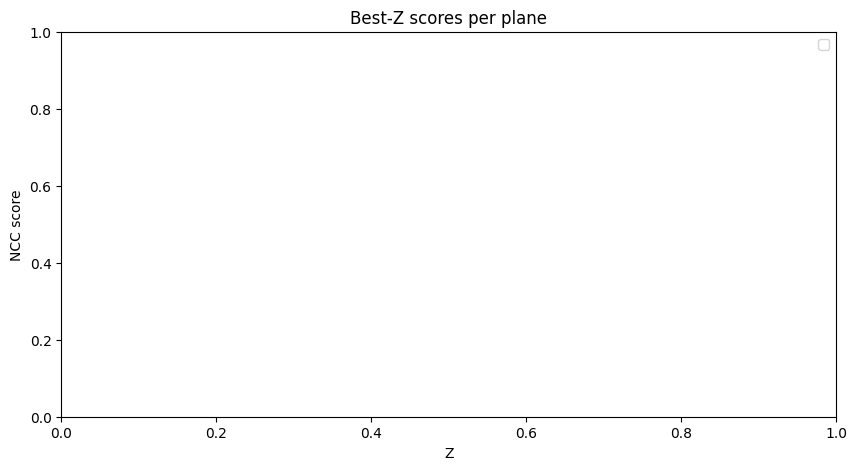

In [11]:
# [18]
# Plot NCC score curves for all planes
if plane_refs:
    import matplotlib.pyplot as _plt
    _plt.figure(figsize=(10,5))
    for pr in plane_refs:
        scores = pr.get("ncc_scores", None)
        if scores is None:
            continue
        m = re.search(r"plane(\d+)", pr.get("label",""))
        plane_no = m.group(1) if m else "?"
        lbl = f"{FISH_ID} fish plane {plane_no}"
        line, = _plt.plot(scores, label=lbl)
        if "best_z" in pr:
            _plt.axvline(pr["best_z"], color=line.get_color(), linestyle="--", alpha=0.7)
    _plt.xlabel("Z")
    _plt.ylabel("NCC score")
    _plt.title("Best-Z scores per plane")
    _plt.legend()
    _plt.show()
else:
    print("No plane_refs available for NCC plot")

### [19] Estimate in-plane transform (functional → anatomy[best‑Z])
Estimate 2D transform from functional reference to the selected anatomy plane.

In [1]:
# [20]
# In-plane transform estimation (with cache reuse)
tforms = []
MULTISCALE_TFORM = True
MULTISCALE_SCALES = [0.125, 0.25, 0.5, 1.0]
MULTISCALE_METHOD = "affine"  # default for Stage B (affine)
MULTISCALE_STAGE_SIM = True
MULTISCALE_STAGE_AFF = True
MULTISCALE_STAGE_ECC = True
MULTISCALE_ECC = True
MULTISCALE_ECC_ITERS = 200
MULTISCALE_ECC_EPS = 1e-6
MULTISCALE_WINSOR = (0.05, 0.95)
MULTISCALE_UNSHARP = True
RESIZE_REF_FOR_TFORM = True  # resize ref_match to anatomy slice for transform estimation

def _winsorize_norm(img, lo=0.05, hi=0.95):
    img = img.astype(np.float32)
    p0, p1 = np.percentile(img, (lo*100.0, hi*100.0))
    if p1 <= p0:
        p0 = float(img.min()); p1 = float(img.max())
    out = np.clip((img - p0) / (p1 - p0 + 1e-6), 0, 1)
    return out

def _prep_ms(img):
    out = _winsorize_norm(img, *MULTISCALE_WINSOR)
    if MULTISCALE_UNSHARP:
        out = local_unsharp(out, 1.0, 0.6)
    return out.astype(np.float32)

def _rescale_img(img, scale):
    if scale == 1.0:
        return img
    return transform.resize(img, (max(1, int(round(img.shape[0]*scale))), max(1, int(round(img.shape[1]*scale)))), order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)

def _tform_to_scale(tform, scale_from, scale_to):
    if tform is None:
        return None
    A = tform.params
    S_from = np.array([[scale_from, 0, 0],[0, scale_from, 0],[0,0,1.0]], dtype=np.float32)
    S_to   = np.array([[scale_to, 0, 0],[0, scale_to, 0],[0,0,1.0]], dtype=np.float32)
    A_full = np.linalg.inv(S_from) @ A @ S_from
    A_to = S_to @ A_full @ np.linalg.inv(S_to)
    return AffineTransform(matrix=A_to)

def _estimate_multiscale(mov, ref):
    tform_full = None
    # Stage A: similarity (multi-scale)
    if MULTISCALE_STAGE_SIM:
        for s in MULTISCALE_SCALES:
            mov_s = _rescale_img(mov, s)
            ref_s = _rescale_img(ref, s)
            if tform_full is None:
                tform_s = estimate_inplane_transform(mov_s, ref_s, method='similarity')
            else:
                tform_s = _tform_to_scale(tform_full, 1.0, s)
            if MULTISCALE_STAGE_ECC and MULTISCALE_ECC:
                tform_s = refine_affine_ecc(mov_s, ref_s, init_tform=tform_s, max_iters=MULTISCALE_ECC_ITERS, eps=MULTISCALE_ECC_EPS, pyr_levels=3)
            tform_full = _tform_to_scale(tform_s, s, 1.0)

    # Stage B: affine (multi-scale)
    if MULTISCALE_STAGE_AFF:
        for s in MULTISCALE_SCALES:
            mov_s = _rescale_img(mov, s)
            ref_s = _rescale_img(ref, s)
            if tform_full is None:
                tform_s = estimate_inplane_transform(mov_s, ref_s, method='affine')
            else:
                tform_s = _tform_to_scale(tform_full, 1.0, s)
            if MULTISCALE_STAGE_ECC and MULTISCALE_ECC:
                tform_s = refine_affine_ecc(mov_s, ref_s, init_tform=tform_s, max_iters=MULTISCALE_ECC_ITERS, eps=MULTISCALE_ECC_EPS, pyr_levels=3)
            tform_full = _tform_to_scale(tform_s, s, 1.0)

    # Stage C: optional full-res ECC refinement
    if MULTISCALE_STAGE_ECC and MULTISCALE_ECC:
        try:
            tform_full = refine_affine_ecc(mov, ref, init_tform=tform_full, max_iters=MULTISCALE_ECC_ITERS, eps=MULTISCALE_ECC_EPS, pyr_levels=3)
        except Exception:
            pass

    return tform_full


FORCE_RECOMPUTE_TFORMS = True  # set True to ignore cached transforms
TFORM_CACHE_PATH = OUT_NCC / 'tforms_by_plane.csv'

use_cache = False
if (not FORCE_RECOMPUTE_TFORMS) and TFORM_CACHE_PATH.exists():
    try:
        df_cache = pd.read_csv(TFORM_CACHE_PATH)
        cache_by_label = {}
        cache_by_index = {}
        for _, row in df_cache.iterrows():
            if 'label' in row and isinstance(row['label'], str):
                cache_by_label[row['label']] = row
            if 'plane_index' in row and not pd.isna(row['plane_index']):
                cache_by_index[int(row['plane_index'])] = row
        # Ensure we have a cached row for every plane
        for idx, pr in enumerate(plane_refs):
            label = pr.get('label', None)
            row = cache_by_label.get(label) if label else None
            if row is None:
                row = cache_by_index.get(idx)
            if row is None:
                raise KeyError(f"Missing cached tform for plane {idx} ({label})")
        # Load cached transforms
        for idx, pr in enumerate(plane_refs):
            label = pr.get('label', None)
            row = cache_by_label.get(label) if label else None
            if row is None:
                row = cache_by_index.get(idx)
            params = np.array([
                [float(row['m00']), float(row['m01']), float(row['m02'])],
                [float(row['m10']), float(row['m11']), float(row['m12'])],
                [0.0, 0.0, 1.0],
            ], dtype=np.float32)
            tform = AffineTransform(matrix=params)
            pr['tform'] = tform
            if 'best_z' not in pr and 'best_z' in row and not pd.isna(row['best_z']):
                pr['best_z'] = int(row['best_z'])
            bz = int(pr.get('best_z', best_z if 'best_z' in globals() else 0))
            a_slice = anat_f[bz]
            ref_match = pr['ref_match']
            pr['ref_warped_raw'] = apply_transform_2d(ref_match, tform, output_shape=a_slice.shape, order=1)
            tforms.append(tform)
        use_cache = True
        print(f"[INFO] Loaded cached tforms from {TFORM_CACHE_PATH}")
    except Exception as _e:
        print(f"[WARN] Could not load cached tforms: {_e}; recomputing")
        use_cache = False

if not use_cache:
    for pr in plane_refs:
        bz = pr['best_z']
        a_slice = anat_f[bz]
        ref_match = pr['ref_match']
        if ref_match.shape != a_slice.shape:
            lbl = pr.get("label")
            print("WARN Ref/anat shape mismatch for transform %s: %s vs %s" % (lbl, ref_match.shape, a_slice.shape))
        mov = ref_match
        ref = a_slice
        if RESIZE_REF_FOR_TFORM and mov.shape != ref.shape:
            mov = transform.resize(mov, ref.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
        mov_p = _prep_ms(mov) if MULTISCALE_TFORM else mov
        ref_p = _prep_ms(ref) if MULTISCALE_TFORM else ref

        if MULTISCALE_TFORM:
            print(f"[{pr['label']}] Multi-scale tform (scales={MULTISCALE_SCALES}, sim={MULTISCALE_STAGE_SIM}, aff={MULTISCALE_STAGE_AFF}, ecc={MULTISCALE_STAGE_ECC})")
            tform = _estimate_multiscale(mov_p, ref_p)
            print(f"[{pr['label']}] Multi-scale tform:", tform.params)
        else:
            # Stage 1: Similarity (rigid+scale) via ORB+RANSAC
            tform_sim = estimate_inplane_transform(mov_p, ref_p, method='similarity')
            print(f"[{pr['label']}] Similarity tform:", tform_sim.params)
            # Stage 2: Affine via ORB+RANSAC
            tform_aff = estimate_inplane_transform(mov_p, ref_p, method='affine')
            print(f"[{pr['label']}] Affine (RANSAC) tform:", tform_aff.params)
            # Stage 3: Refine affine with ECC
            tform = refine_affine_ecc(mov_p, ref_p, init_tform=tform_aff, max_iters=300, eps=1e-6, pyr_levels=3)
            print(f"[{pr['label']}] Affine (ECC refined) tform:", tform.params)

        pr['tform'] = tform
        tforms.append(tform)
        ref_warped_raw = apply_transform_2d(pr['ref_match'], tform, output_shape=a_slice.shape, order=1)
        pr['ref_warped_raw'] = ref_warped_raw
    # Persist per-plane transforms so QA cells can reuse without recomputing
    try:
        tform_records = []
        for idx, pr in enumerate(plane_refs):
            tf = pr.get('tform', None)
            if tf is None:
                continue
            params = tf.params
            tform_records.append({
                'plane_index': idx,
                'label': pr.get('label', f'plane{idx}'),
                'best_z': int(pr.get('best_z', best_z if 'best_z' in globals() else 0)),
                'm00': float(params[0,0]), 'm01': float(params[0,1]), 'm02': float(params[0,2]),
                'm10': float(params[1,0]), 'm11': float(params[1,1]), 'm12': float(params[1,2]),
            })
        if tform_records:
            pd.DataFrame(tform_records).to_csv(TFORM_CACHE_PATH, index=False)
            print(f"[INFO] Wrote cached tforms to {TFORM_CACHE_PATH}")
    except Exception as _e:
        print('Could not save per-plane transforms:', _e)

# Keep first-plane artifacts for downstream convenience (keep ref/tform in sync)
FIRST_PLANE_LABEL = plane_refs[0].get('label', 'plane0')
tform = plane_refs[0]['tform']
ref_match = plane_refs[0].get('ref_match', plane_refs[0].get('ref2d_raw', plane_refs[0].get('ref2d')))
ref_warped_raw = plane_refs[0]['ref_warped_raw']
ref2d_raw = plane_refs[0].get('ref2d_raw', ref2d_raw)
ref2d = plane_refs[0].get('ref2d', ref2d)

NameError: name 'OUT_NCC' is not defined

In [ ]:
# [20a]
# NCC-based XY placement of functional ref in anatomy plane
import numpy as np
USE_NCC_PLACEMENT = bool(globals().get("USE_NCC_PLACEMENT", True))
if not USE_NCC_PLACEMENT:
    print("[NCC-XY] USE_NCC_PLACEMENT=False; skipping NCC-based placement")
from skimage import feature

if "plane_refs" not in globals() or not plane_refs:
    raise RuntimeError("plane_refs missing; run [16]/[20] first.")

def _ncc_xy(template, image):
    if HAS_CV2:
        templ = (norm01(template) * 255).astype(np.uint8)
        img = (norm01(image) * 255).astype(np.uint8)
        res = cv2.matchTemplate(img, templ, cv2.TM_CCORR_NORMED)
        ij = np.unravel_index(np.argmax(res), res.shape)
        y0, x0 = int(ij[0]), int(ij[1])
        score = float(res[y0, x0])
        return x0, y0, score
    res = feature.match_template(norm01(image), norm01(template), pad_input=False)
    ij = np.unravel_index(np.argmax(res), res.shape)
    y0, x0 = int(ij[0]), int(ij[1])
    score = float(res[y0, x0])
    return x0, y0, score

for pr in plane_refs:
    if pr is None:
        continue
    bz = int(pr.get("best_z", best_z if "best_z" in globals() else 0))
    a_slice = anat_f[bz]
    ref_match = pr.get("ref_match", pr.get("ref2d_raw", pr.get("ref2d")))
    if ref_match is None or a_slice is None:
        print(f"[NCC-XY] Missing ref/anat for {pr.get('label')}")
        continue
    if ref_match.shape[0] > a_slice.shape[0] or ref_match.shape[1] > a_slice.shape[1]:
        print(f"[NCC-XY] Template larger than anatomy for {pr.get('label')}: {ref_match.shape} vs {a_slice.shape}")
        continue
    x0, y0, score = _ncc_xy(ref_match, a_slice)
    xc = x0 + ref_match.shape[1] / 2.0
    yc = y0 + ref_match.shape[0] / 2.0
    pr["ncc_xy"] = {"x0": x0, "y0": y0, "xc": xc, "yc": yc, "score": score}
    if USE_NCC_PLACEMENT:
        ref_src = pr.get("ref_match", pr.get("ref2d_raw", pr.get("ref2d")))
        if ref_src is not None:
            a_shape = a_slice.shape
            placed = np.zeros(a_shape, dtype=np.float32)
            h, w = ref_src.shape[-2], ref_src.shape[-1]
            y0i = max(0, int(y0)); x0i = max(0, int(x0))
            y1 = min(a_shape[0], y0i + h)
            x1 = min(a_shape[1], x0i + w)
            sy0 = max(0, -int(y0)); sx0 = max(0, -int(x0))
            sy1 = sy0 + (y1 - y0i)
            sx1 = sx0 + (x1 - x0i)
            if y1 > y0i and x1 > x0i:
                placed[y0i:y1, x0i:x1] = ref_src[sy0:sy1, sx0:sx1]
                pr["ref_warped_raw"] = placed
                pr["ref_warped"] = placed
                if pr is plane_refs[0]:
                    globals()["ref_warped_raw"] = placed
                    globals()["ref_warped"] = placed
    print(f"[NCC-XY] {pr.get('label')} z={bz} score={score:.4f} top-left=({x0},{y0}) center=({xc:.1f},{yc:.1f})")


### [21] Interactive overlay: toggle channels like FIJI
Interactive viewer to overlay functional and anatomy images.

In [17]:
# [22]
# Interactive overlay: toggle channels like FIJI (all planes side-by-side)
try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_WIDGETS = True
except Exception as _e:
    _HAS_WIDGETS = False
    print("ipywidgets not available; skipping interactive overlay. Install ipywidgets to enable.")

import numpy as np

# Prepare normalized views for every plane
__overlay_ready = True
_overlay_items = []
try:
    if "plane_refs" not in globals() or not plane_refs:
        raise RuntimeError("plane_refs missing; run previous cells first.")
    if "anat" not in globals():
        raise RuntimeError("anat missing; run [16] first.")
    for pr in plane_refs:
        if pr is None:
            continue
        bz = int(pr.get("best_z", best_z if "best_z" in globals() else 0))
        a_src = anat[bz]
        src_label = "raw"
        f_src = None
        if pr.get("ref_warped") is not None:
            f_src = pr.get("ref_warped")
            src_label = "warped"
        elif pr.get("tform") is not None:
            mov_src = pr.get("ref_match", pr.get("ref2d_raw", pr.get("ref2d")))
            if mov_src is not None:
                f_src = apply_transform_2d(mov_src, pr["tform"], output_shape=a_src.shape, order=1)
                src_label = "tform-preview"
        elif pr.get("ref_warped_raw") is not None:
            f_src = pr.get("ref_warped_raw")
            src_label = "warped-raw"
        else:
            f_src = pr.get("ref2d", pr.get("ref2d_raw"))
            src_label = "raw"
        if f_src is None:
            continue
        f_vis = norm01(f_src)
        a_vis = norm01(a_src)
        if f_vis.shape != a_vis.shape:
            f_vis = transform.resize(
                f_vis,
                a_vis.shape,
                order=1,
                mode="reflect",
                preserve_range=True,
                anti_aliasing=True,
            ).astype(np.float32)
        label = pr.get("label", "plane")
        _overlay_items.append({
            "f_vis": f_vis,
            "a_vis": a_vis,
            "label": label,
            "z": bz,
            "src_label": src_label,
        })
    if not _overlay_items:
        raise RuntimeError("No overlay items prepared; check inputs.")
except Exception as _e:
    print("Interactive overlay prerequisites missing (plane_refs/anat/best_z). Run previous cells first.")
    __overlay_ready = False

# Define simple LUTs
_COLORS = {
    "green":   (0.0, 1.0, 0.0),
    "magenta": (1.0, 0.0, 1.0),
    "red":     (1.0, 0.0, 0.0),
    "blue":    (0.0, 0.0, 1.0),
    "cyan":    (0.0, 1.0, 1.0),
    "yellow":  (1.0, 1.0, 0.0),
    "white":   (1.0, 1.0, 1.0)
}

def _apply_color(gray01, rgb):
    r, g, b = rgb
    return np.stack([gray01*r, gray01*g, gray01*b], axis=-1)

def _render(show_func=True, show_anat=True, func_color="green", anat_color="magenta", func_alpha=1.0, anat_alpha=1.0, panel_w=4.0, panel_h=4.0):
    n = len(_overlay_items)
    fig_w = max(2.0, float(panel_w) * n)
    fig, axes = plt.subplots(1, n, figsize=(fig_w, float(panel_h)))
    if n == 1:
        axes = [axes]
    for ax, item in zip(axes, _overlay_items):
        out = np.zeros((item["f_vis"].shape[0], item["f_vis"].shape[1], 3), dtype=np.float32)
        if show_anat:
            out += _apply_color(item["a_vis"], _COLORS[anat_color]) * float(anat_alpha)
        if show_func:
            out += _apply_color(item["f_vis"], _COLORS[func_color]) * float(func_alpha)
        out = np.clip(out, 0, 1)
        ax.imshow(out)
        ax.set_title("{} z={} | func src: {}".format(item["label"], item["z"], item["src_label"]))
        ax.axis("off")
    plt.show()

show_func_cb = widgets.Checkbox(value=True, description="Show functional")
show_anat_cb = widgets.Checkbox(value=True, description="Show anatomy")
func_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value="green", description="Func LUT")
anat_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value="magenta", description="Anat LUT")
func_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format=".2f", description="Func alpha")
anat_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format=".2f", description="Anat alpha")
panel_w_sl = widgets.FloatSlider(value=4.0, min=2.0, max=10.0, step=0.5, readout_format=".1f", description="Panel W")
panel_h_sl = widgets.FloatSlider(value=4.0, min=2.0, max=10.0, step=0.5, readout_format=".1f", description="Panel H")


if _HAS_WIDGETS and __overlay_ready:
    ui = widgets.VBox([
        widgets.HBox([show_func_cb, func_color_dd, func_alpha_sl]),
        widgets.HBox([show_anat_cb, anat_color_dd, anat_alpha_sl, panel_w_sl, panel_h_sl])
    ])
    out = widgets.interactive_output(_render, {
        "show_func": show_func_cb,
        "show_anat": show_anat_cb,
        "func_color": func_color_dd,
        "anat_color": anat_color_dd,
        "func_alpha": func_alpha_sl,
        "anat_alpha": anat_alpha_sl,
        "panel_w": panel_w_sl,
        "panel_h": panel_h_sl,
    })
    display(ui, out)
elif _HAS_WIDGETS and not __overlay_ready:
    print("Interactive overlay not shown: run best-Z cell first.")

Output()

### [23a] Suite2p masks + traces (preferred over Cellpose)
Load Suite2p outputs, build ROI label masks (iscell only), and compute dF/F from raw F.


In [ ]:
# [23a]
# Suite2p: load outputs, build label masks, compute dF/F (iscell only)
import numpy as np
from pathlib import Path
import re
import pathlib

USE_SUITE2P_LABELS = True
SUITE2P_ROOT = Path(globals().get("SUITE2P_ROOT", OUTDIR / "suite2P"))
SUITE2P_PLANE_GLOB = globals().get("SUITE2P_PLANE_GLOB", "plane*")
SUITE2P_FLIP_X = globals().get("SUITE2P_FLIP_X", None)  # None=auto
DFOF_BASELINE_PCT = float(globals().get("DFOF_BASELINE_PCT", 10.0))
DFOF_EPS = float(globals().get("DFOF_EPS", 1e-6))

def _apply_func_orient(arr):
    if "_apply_func_orientation" in globals():
        try:
            return _apply_func_orientation(arr)
        except Exception:
            pass
    if arr is None:
        return None
    if getattr(arr, "ndim", 0) < 2:
        return arr
    polarity_north = str(globals().get("POLARITY", "")).lower() == "north"
    out = arr
    if polarity_north:
        out = out[..., ::-1, ::-1]
    out = out[..., ::-1]
    return out


def _load_ops_npy(path):
    try:
        return np.load(path, allow_pickle=True).item()
    except NotImplementedError:
        _orig_win = pathlib.WindowsPath
        _orig_pure = pathlib.PureWindowsPath
        pathlib.WindowsPath = pathlib.PosixPath
        pathlib.PureWindowsPath = pathlib.PurePosixPath
        try:
            return np.load(path, allow_pickle=True).item()
        finally:
            pathlib.WindowsPath = _orig_win
            pathlib.PureWindowsPath = _orig_pure


def _find_suite2p_file(plane_dir, key):
    p = plane_dir / f"{key}.npy"
    if p.exists():
        return p
    hits = sorted(plane_dir.glob(f"*_{key}.npy"))
    if hits:
        return hits[0]
    return None


def _plane_num_from_name(name):
    m = re.search(r"plane(\d+)", str(name))
    return int(m.group(1)) if m else None


def _ensure_float32(img):
    return np.asarray(img, dtype=np.float32)


def _resize_like(img, target_shape):
    if img is None:
        return None
    if img.shape == target_shape:
        return img
    try:
        from skimage.transform import resize
        return resize(img, target_shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)
    except Exception:
        return img


def _corr2(a, b):
    try:
        if "corrcoef_img" in globals():
            return float(corrcoef_img(a, b))
    except Exception:
        pass
    a = a.astype(np.float32); b = b.astype(np.float32)
    am = a.mean(); bm = b.mean()
    num = ((a - am) * (b - bm)).sum()
    den = np.sqrt(((a - am) ** 2).sum() * ((b - bm) ** 2).sum()) + 1e-8
    return float(num / den)


def _build_labels_from_stat(stat, iscell, ops):
    Ly = int(ops.get("Ly", 0)); Lx = int(ops.get("Lx", 0))
    labels = np.zeros((Ly, Lx), dtype=np.uint32)
    keep = np.asarray(iscell)[:, 0].astype(bool)
    idxs = np.where(keep)[0]
    for roi_idx in idxs:
        s = stat[roi_idx]
        if isinstance(s, dict):
            ypix = np.asarray(s.get("ypix", []), dtype=np.int64)
            xpix = np.asarray(s.get("xpix", []), dtype=np.int64)
            overlap = s.get("overlap", None)
        else:
            ypix = np.asarray(s["ypix"], dtype=np.int64)
            xpix = np.asarray(s["xpix"], dtype=np.int64)
            dtype_names = getattr(getattr(s, "dtype", None), "names", None)
            overlap = s["overlap"] if dtype_names and "overlap" in dtype_names else None
        if overlap is not None:
            ok = ~np.asarray(overlap, dtype=bool)
            ypix = ypix[ok]; xpix = xpix[ok]
        if ypix.size and xpix.size:
            labels[ypix, xpix] = roi_idx + 1
    return labels, keep


if "plane_refs" not in globals() or not plane_refs:
    raise RuntimeError("plane_refs missing; run the functional reference cell first.")

plane_dirs = [p for p in Path(SUITE2P_ROOT).glob(SUITE2P_PLANE_GLOB) if p.is_dir()]
plane_dirs = sorted(plane_dirs, key=lambda p: (_plane_num_from_name(p.name) if _plane_num_from_name(p.name) is not None else p.name))

plane_ref_map = {}
for i, pr in enumerate(plane_refs):
    label = str(pr.get("label", ""))
    m = re.search(r"plane(\d+)", label)
    if m:
        plane_ref_map[int(m.group(1))] = i
    elif pr.get("index") is not None:
        idx = int(pr.get("index"))
        if idx not in plane_ref_map:
            plane_ref_map[idx] = i

suite2p_planes = []
suite2p_by_ref_idx = {}
func_labels = [None] * len(plane_refs)

if not plane_dirs:
    print(f"[Suite2p] No plane dirs found under {SUITE2P_ROOT} (glob={SUITE2P_PLANE_GLOB})")
else:
    for pd_i, plane_dir in enumerate(plane_dirs):
        plane_num = _plane_num_from_name(plane_dir.name)
        ref_idx = plane_ref_map.get(plane_num, None)
        if ref_idx is None:
            ref_idx = pd_i if pd_i < len(plane_refs) else None

        paths = {k: _find_suite2p_file(plane_dir, k) for k in ("F", "Fneu", "spks", "stat", "ops", "iscell")}
        missing = [k for k, v in paths.items() if v is None]
        if missing:
            print(f"[Suite2p] Missing {missing} in {plane_dir}; skipping")
            continue

        F = np.load(paths["F"], allow_pickle=True)
        Fneu = np.load(paths["Fneu"], allow_pickle=True)
        spks = np.load(paths["spks"], allow_pickle=True)
        stat = np.load(paths["stat"], allow_pickle=True)
        ops = _load_ops_npy(paths["ops"])
        iscell = np.load(paths["iscell"], allow_pickle=True)

        labels, keep = _build_labels_from_stat(stat, iscell, ops)
        labels = _apply_func_orient(labels)

        flip_x = SUITE2P_FLIP_X
        if flip_x is None and ref_idx is not None:
            ref_img = plane_refs[ref_idx].get("ref2d_raw", plane_refs[ref_idx].get("ref2d"))
            mean_img = ops.get("meanImg", None)
            if ref_img is not None and mean_img is not None:
                ref_img = _ensure_float32(ref_img)
                mean_img = _ensure_float32(mean_img)
                mean_img = _apply_func_orient(mean_img)
                mean_img = _resize_like(mean_img, ref_img.shape)
                try:
                    c0 = _corr2(mean_img, ref_img)
                    c1 = _corr2(mean_img[:, ::-1], ref_img)
                    flip_x = c1 > (c0 + 1e-3)
                except Exception:
                    flip_x = False
            else:
                flip_x = False
        if flip_x:
            labels = labels[:, ::-1]

        F_raw = np.asarray(F, dtype=np.float32)
        F0 = np.percentile(F_raw, DFOF_BASELINE_PCT, axis=1, keepdims=True)
        dff = (F_raw - F0) / (F0 + DFOF_EPS)

        polarity_north = str(globals().get("POLARITY", "")).lower() == "north"
        orient_mode = "rot180+flipX" if polarity_north else "flipX"

        plane_info = {
            "plane_dir": plane_dir,
            "plane_num": plane_num,
            "ref_idx": ref_idx,
            "labels": labels,
            "iscell_keep": keep,
            "F": F,
            "Fneu": Fneu,
            "spks": spks,
            "stat": stat,
            "ops": ops,
            "iscell": iscell,
            "dff": dff,
            "flip_x": bool(flip_x),
            "func_orient": orient_mode,
        }
        suite2p_planes.append(plane_info)

        if ref_idx is not None:
            func_labels[ref_idx] = labels
            suite2p_by_ref_idx[ref_idx] = plane_info
            plane_refs[ref_idx]["suite2p"] = plane_info

        n_cells = int(keep.sum())
        print(f"[Suite2p] {plane_dir.name}: rois={len(keep)} cells={n_cells} ref_idx={ref_idx} flip_x={plane_info['flip_x']} orient={plane_info['func_orient']}")

globals()["suite2p_planes"] = suite2p_planes
globals()["suite2p_by_ref_idx"] = suite2p_by_ref_idx
if USE_SUITE2P_LABELS:
    globals()["func_labels"] = func_labels
    print(f"[Suite2p] Loaded labels for {sum(m is not None for m in func_labels)} plane(s) into func_labels.")

### [23] Cellpose segmentation on functional reference (8-bit input)
Run Cellpose segmentation on the functional reference image.

If you are using Suite2p labels, skip this section.


In [ ]:
if bool(globals().get('USE_SUITE2P_LABELS', False)):
    print('[Cellpose] USE_SUITE2P_LABELS is True; skipping Cellpose segmentation.')
else:
    # [24]

    # Cellpose segmentation on functional reference (8-bit input)
    # Segments all functional planes unless skipped.
    CP_SAVE_PNG = False
    CP_SAVE_TIF = True
    CP_SKIP_IF_EXISTS = True
    CP_PLANE_INDICES = None  # set to list of indices to subset, or None for all

    from cellpose import models, io
    io.logger_setup()
    MODEL_PATH = '/Volumes/jlarsch/default/D2c/07_Data/Danin/Cellpose/models/2pf_cpsam_20250915_115140'
    model = models.CellposeModel(gpu=True, pretrained_model=MODEL_PATH)

    if not plane_refs:
        raise RuntimeError('No functional planes available for Cellpose')

    plane_indices = CP_PLANE_INDICES if CP_PLANE_INDICES is not None else range(len(plane_refs))
    for pi in plane_indices:
        pi_int = int(pi)
        if pi_int < 0 or pi_int >= len(plane_refs):
            print(f"[SKIP] plane index {pi_int} out of range")
            continue
        pr = plane_refs[pi_int]
        label = pr.get('label', f'plane{pi_int}')
        mask_path = OUT_SEG / f"{label}_cellpose_masks.tif"
        if CP_SKIP_IF_EXISTS and mask_path.exists():
            print(f"[SKIP] existing masks: {mask_path}")
            continue
        ref_for_cp = pr.get('ref2d_raw') if pr.get('ref2d_raw') is not None else pr.get('ref_match') or pr.get('ref2d')
        if ref_for_cp is None:
            print(f"[SKIP] no reference image for {label}")
            continue
        cp_img = (norm01(ref_for_cp) * 255).astype(np.uint8)
        cp_input_path = OUT_SEG / f"{label}_cellpose_input.tif"
        imwrite(cp_input_path, cp_img)
        result = model.eval([cp_img], channels=[0,0], channel_axis=None, normalize=True)
        try:
            masks, flows, styles, diams = result
        except ValueError:
            masks, flows, styles = result
            diams = None
        mask_arr = masks[0].astype(np.uint16)
        if CP_SAVE_TIF:
            imwrite(mask_path, mask_arr)
        if CP_SAVE_PNG:
            try:
                from PIL import Image
                Image.fromarray(mask_arr.astype('uint16')).save(mask_path.with_suffix('.png'))
            except Exception as e:
                print('[WARN] PNG save failed:', e)
        print(f"[CP] {label}: input={cp_input_path}, masks={mask_path}")


### [25] Functional labels on references
Plot functional label masks over each functional reference to verify the mapping before downstream QC.


In [ ]:
# [26]
# Plot functional labels on top of each functional reference (per-plane)
from skimage import color as _color

def _get_labels_for_plane(pr, p_idx):
    lbl = pr.get('label', f'plane{p_idx}')
    use_s2p = bool(globals().get('USE_SUITE2P_LABELS', False))
    if use_s2p:
        fl = globals().get('func_labels', None)
        if fl is not None:
            if isinstance(fl, list):
                if p_idx < len(fl):
                    arr_i = fl[p_idx]
                    if arr_i is not None:
                        arr_i = _ensure_uint_labels(arr_i)
                        return arr_i, f"Suite2p labels list[{p_idx}]"
            else:
                arr_np = _ensure_uint_labels(np.asarray(fl))
                if arr_np.ndim == 3:
                    src_idx = pr.get('index', p_idx)
                    if src_idx < arr_np.shape[0]:
                        return arr_np[src_idx], f"Suite2p labels stack[{src_idx}]"
                elif arr_np.ndim == 2:
                    return arr_np, "Suite2p labels (2D)"
    cp_path = OUT_SEG / f"{lbl}_cellpose_masks.tif"
    if cp_path.exists():
        arr = _ensure_uint_labels(imread(cp_path))
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr, f"Cellpose masks: {cp_path}"
    fl = globals().get('func_labels', None)
    if fl is not None:
        arr = fl
        if isinstance(arr, list):
            if p_idx < len(arr):
                arr_i = _ensure_uint_labels(arr[p_idx])
                return arr_i, f"func_labels list[{p_idx}]"
        else:
            arr_np = _ensure_uint_labels(np.asarray(arr))
            if arr_np.ndim == 3:
                src_idx = pr.get('index', p_idx)
                if src_idx < arr_np.shape[0]:
                    return arr_np[src_idx], f"func_labels stack[{src_idx}]"
            elif arr_np.ndim == 2:
                return arr_np, "func_labels (2D)"
    if FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
        arr = _ensure_uint_labels(imread(FUNC_LABELS_PATH))
        if arr.ndim == 3:
            src_idx = pr.get('index', p_idx)
            if src_idx < arr.shape[0]:
                return arr[src_idx], f"FUNC_LABELS_PATH[{src_idx}]: {Path(FUNC_LABELS_PATH).name}"
        elif arr.ndim == 2:
            return arr, f"FUNC_LABELS_PATH: {Path(FUNC_LABELS_PATH).name}"
    return None, None

if 'plane_refs' not in globals() or not plane_refs:
    print('No functional references to plot.')
else:
    import matplotlib.pyplot as _plt
    for p_idx, pr in enumerate(plane_refs):
        lbl = pr.get('label', f'plane{p_idx}')
        labels, src_desc = _get_labels_for_plane(pr, p_idx)
        if labels is None:
            print(f"[SKIP] No labels found for {lbl}")
            continue
        if labels.ndim == 3 and labels.shape[-1] in (3, 4):
            labels = labels[..., 0]
        if labels.ndim != 2:
            print(f"[SKIP] Labels for {lbl} have unsupported shape {labels.shape}")
            continue
        ref_img = pr.get('ref2d_raw', None)
        if ref_img is None:
            ref_img = pr.get('ref2d', None)
        if ref_img is None:
            print(f"[SKIP] No functional reference for {lbl}")
            continue
        if ref_img.ndim == 3 and ref_img.shape[-1] in (3, 4):
            ref_img = ref_img[..., 0]
        if labels.shape != ref_img.shape:
            print(f"[SKIP] Label/ref shape mismatch for {lbl}: labels {labels.shape}, ref {ref_img.shape}")
            continue
        ref_vis = norm01(ref_img)
        overlay = _color.label2rgb(labels, image=ref_vis, bg_label=0, alpha=0.35, image_alpha=1.0)
        _plt.figure(figsize=(6, 6))
        _plt.imshow(overlay)
        title_src = src_desc if src_desc else 'labels'
        _plt.title(f"Functional labels on reference — {lbl}\n{title_src}")
        _plt.axis('off')
        _plt.show()


### [27] Mask diameters by axis (µm)
Measure per-axis diameters of segmentation masks in microns.

In [ ]:
# [28]

# Mask diameters (µm) for anatomy, functional, HCR (if available)
import numpy as _np, matplotlib.pyplot as _plt

def _load_labels_or_none(path):
    if path is None:
        return None
    try:
        if not os.path.exists(path):
            return None
        arr = _ensure_uint_labels(imread(path))
        if arr.ndim == 3 and arr.shape[-1] in (3,4):
            arr = arr[...,0]
        return arr
    except Exception as _e:
        print('Could not load labels from', path, ':', _e)
        return None

dfs = []
anat_labels = _load_labels_or_none(ANAT_LABELS_PATH)
if anat_labels is not None:
    anat_3d = anat_labels if anat_labels.ndim == 3 else anat_labels[None, ...]
    vox_a = {
        'Z': float(VOX_ANAT.get('Z',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'Y': float(VOX_ANAT.get('Y',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        'X': float(VOX_ANAT.get('X',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
    }
    df_anat_diam = diameters_um_from_array(anat_3d, vox_a)
    df_anat_diam['dataset'] = 'Anatomy'
    dfs.append(df_anat_diam)

# Optional: 2P anatomy masks (Cellpose) fallback: if ANAT_LABELS_PATH missing, try structural/cp_masks
if anat_labels is None:
    anat2p_path = Path('/Volumes/jlarsch/default/D2c/07_Data/Danin/L395_f11/03_analysis/structural/cp_masks/L395_f11_anatomy_00001_8bit_cp_masks.tif')
    anat2p_labels = _load_labels_or_none(anat2p_path)
    if anat2p_labels is not None:
        anat2p_3d = anat2p_labels if anat2p_labels.ndim == 3 else anat2p_labels[None, ...]
        vox_a2p = {
            'Z': float(VOX_ANAT.get('Z',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
            'Y': float(VOX_ANAT.get('Y',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
            'X': float(VOX_ANAT.get('X',1.0)) if 'VOX_ANAT' in globals() and VOX_ANAT else 1.0,
        }
        df_anat2p_diam = diameters_um_from_array(anat2p_3d, vox_a2p)
        df_anat2p_diam['dataset'] = 'Anatomy2P'
        dfs.append(df_anat2p_diam)


func_labels = globals().get("func_labels", None)
if isinstance(func_labels, list) and not any(m is not None for m in func_labels):
    func_labels = None
_cp_masks = []
if func_labels is None:
    try:
        for pr in plane_refs:
            lbl = pr.get("label", None)
            if lbl is None:
                continue
            mp = OUT_SEG / f"{lbl}_cellpose_masks.tif"
            if not mp.exists():
                continue
            m = imread(mp)
            m = _np.asarray(m)
            if m.ndim == 3 and m.shape[-1] in (3,4):
                m = m[...,0]
            m = _ensure_uint_labels(m)
            _cp_masks.append(m)
        if _cp_masks:
            func_labels = _cp_masks  # list of per-plane masks with unique labels
    except Exception as _e:
        print("Warning: loading cellpose masks failed:", _e)
if func_labels is None:
    func_labels = _load_labels_or_none(FUNC_LABELS_PATH)
if func_labels is not None:
    vox_f = {
        'Z': 1.0,
        'Y': float(VOX_FUNC.get('Y',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
        'X': float(VOX_FUNC.get('X',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
    }
    func_dfs = []
    if isinstance(func_labels, list):
        for i, m in enumerate(func_labels):
            func_3d = m if m.ndim == 3 else m[None, ...]
            df_i = diameters_um_from_array(func_3d, vox_f)
            df_i['plane_idx'] = i
            func_dfs.append(df_i)
        df_func_diam = pd.concat(func_dfs, ignore_index=True) if func_dfs else None
    else:
        func_3d = func_labels if func_labels.ndim == 3 else func_labels[None, ...]
        df_func_diam = diameters_um_from_array(func_3d, vox_f)
    if df_func_diam is not None:
        df_func_diam['dataset'] = 'Functional'
        dfs.append(df_func_diam)

HCR_LABELS_PATHS = globals().get('HCR_LABELS_PATHS', []) if 'HCR_LABELS_PATHS' in globals() else []
if (not HCR_LABELS_PATHS) and 'HCR_LABELS_PATH' in globals() and HCR_LABELS_PATH:
    HCR_LABELS_PATHS = [HCR_LABELS_PATH]

hcr_dfs = []
for hp in HCR_LABELS_PATHS:
    hl = _load_labels_or_none(hp)
    if hl is None:
        continue
    hcr_3d = hl if hl.ndim == 3 else hl[None, ...]
    vox_h = {
        'Z': float(VOX_HCR.get('Z',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'Y': float(VOX_HCR.get('Y',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
        'X': float(VOX_HCR.get('X',1.0)) if 'VOX_HCR' in globals() and VOX_HCR else 1.0,
    }
    df_h = diameters_um_from_array(hcr_3d, vox_h)
    df_h['dataset'] = 'HCR'
    df_h['gene'] = gene_from_mask(hp)
    df_h['file'] = Path(hp).name
    hcr_dfs.append(df_h)
if hcr_dfs:
    dfs.append(pd.concat(hcr_dfs, ignore_index=True))

if not dfs:
    print('No label volumes available for diameter analysis.')
else:
    df_all = pd.concat(dfs, ignore_index=True)
    try:
        df_all.to_pickle(OUT_QA / 'diameters_df_all.pkl')
    except Exception:
        pass
    cats_plot = ['Anatomy','Functional','HCR']
    present = [c for c in cats_plot if c in df_all['dataset'].unique()]

    def _series_for_axis(axis_col):
        ser = []
        for ds in present:
            vals = df_all.loc[df_all['dataset']==ds, axis_col].to_numpy(dtype=float)
            ser.append(vals)
        return ser

    series_x = _series_for_axis('x_um')
    series_y = _series_for_axis('y_um')
    series_z = _series_for_axis('z_um')

    all_vals = _np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any(
        (a.size for a in (series_x + series_y + series_z))) else _np.array([])
    y_max_data = float(_np.max(all_vals)) if all_vals.size else 10.0
    from math import ceil as _ceil
    y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
    yticks = _np.arange(0.0, y_max + 0.1, 10.0)

    color_map = {'Anatomy':'#bbbbbb', 'Functional':'#88ccee', 'HCR':'#cc88ff'}
    colors = [color_map.get(ds, '#cccccc') for ds in present]

    fig, axes = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
    if not hasattr(axes, '__len__'):
        axes = [axes]
    axis_cols = ['x_um', 'y_um', 'z_um']
    for ax, ser, title, axis_col in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)'], axis_cols):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        x_offset = 0.18
        y_offset = 0.02 * y_max
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                med = float(_np.median(vals))
                ax.scatter([i], [med], color='crimson', zorder=3, s=26)
                label_txt = 'median={:.2f} µm\nn={:d}'.format(med, vals.size)
                ax.text(i + x_offset, med + y_offset, label_txt,
                        va='bottom', ha='left', fontsize=8, bbox=bbox_style, clip_on=False, zorder=4)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present)+1))
        ax.set_xticklabels(present, rotation=0)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.2)
    fig.suptitle('Mask diameters by axis — Anatomy, Functional, HCR')
    _plt.tight_layout()
    _plt.show()

    # HCR per-file diameters (one violin per file, pooled by axis)
    if 'HCR' in present and 'file' in df_all.columns and df_all.loc[df_all['dataset']=='HCR', 'file'].notna().any():
        hcr_sub = df_all[df_all['dataset']=='HCR'].copy()
        hcr_files = list(hcr_sub['file'].dropna().unique())
        hcr_genes = [gene_from_mask(fn) for fn in hcr_files]
        if hcr_files:
            fig2, axes2 = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
            if not hasattr(axes2, '__len__'):
                axes2 = [axes2]
            for ax, axis_col in zip(axes2, axis_cols):
                ser = [hcr_sub.loc[hcr_sub['file']==fn, axis_col].to_numpy(dtype=float) for fn in hcr_files]
                if not any(a.size for a in ser):
                    ax.set_visible(False)
                    continue
                parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor('#cc88ff'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
                x_offset = 0.12; y_offset = 0.02 * y_max
                for i, vals in enumerate(ser, start=1):
                    if vals.size:
                        med = float(_np.median(vals))
                        ax.scatter([i], [med], color='crimson', zorder=3, s=24)
                        ax.text(i + x_offset, med + y_offset, f"median={med:.2f} µm\nn={vals.size}",
                                va='bottom', ha='left', fontsize=7.5, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0), clip_on=False, zorder=4)
                ax.set_title(f"HCR {axis_col.split('_')[0].upper()} per file")
                ax.set_xticks(range(1, len(hcr_files)+1))
                ax.set_xticklabels(hcr_genes, rotation=30, ha='right')
                ax.set_ylim(0, y_max)
                ax.set_yticks(yticks)
                ax.grid(axis='y', alpha=0.2)
            _plt.tight_layout()
            _plt.show()

    axis_name_map = {'x_um':'X', 'y_um':'Y', 'z_um':'Z'}
    outlier_rows = []
    for ds in present:
        sub = df_all[df_all['dataset']==ds]
        if sub.empty:
            continue
        for axis_col in axis_cols:
            vals = sub[axis_col].to_numpy(dtype=float)
            if not len(vals):
                continue
            try:
                q1, q3 = _np.percentile(vals, [25, 75])
                iqr = q3 - q1
                lo = q1 - 1.5 * iqr
                hi = q3 + 1.5 * iqr
            except Exception:
                lo, hi = -_np.inf, _np.inf
            outs = sub[(sub[axis_col] < lo) | (sub[axis_col] > hi)]
            if outs.empty:
                continue
            for _, row in outs.iterrows():
                entry = {'dataset': ds, 'axis': axis_name_map.get(axis_col, axis_col), 'diameter_um': float(row[axis_col])}
                if 'label' in row and not pd.isna(row['label']):
                    entry['label'] = int(row['label'])
                if ds == 'Functional' and 'plane_idx' in row and not pd.isna(row['plane_idx']):
                    entry['plane_idx'] = int(row['plane_idx'])
                if 'file' in row and not pd.isna(row['file']):
                    entry['file'] = row['file']
                outlier_rows.append(entry)
    if outlier_rows:
        out_df = pd.DataFrame(outlier_rows).sort_values(['dataset','axis','diameter_um'], ascending=[True, True, False]).reset_index(drop=True)
        print('Outlier diameters (IQR fence, pooled), sorted high→low (per-plane/per-file labels):')
        try:
            from IPython.display import HTML, display  # type: ignore
            html = out_df.to_html(index=False)
            display(HTML(f"<div style='max-height:320px; overflow-y:auto'>{html}</div>"))
        except Exception:
            print(out_df.to_string(index=False))
    else:
        print('No diameter outliers found.')


    rows = []
    for ds in present:
        sub = df_all[df_all['dataset']==ds]
        if sub.empty:
            rows.append({'dataset': ds, 'x_median': _np.nan, 'y_median': _np.nan, 'z_median': _np.nan, 'n': 0})
        else:
            rows.append({
                'dataset': ds,
                'x_median': float(_np.median(sub['x_um'])) if len(sub['x_um']) else _np.nan,
                'y_median': float(_np.median(sub['y_um'])) if len(sub['y_um']) else _np.nan,
                'z_median': float(_np.median(sub['z_um'])) if len(sub['z_um']) else _np.nan,
                'n': int(len(sub)),
            })
    med_table = pd.DataFrame(rows)
    try:
        display(med_table)
    except Exception:
        print(med_table.to_string(index=False))


### [29] Noise-filtered diameters (HCR X/Y ≥ 3 µm)
Filter mask diameter measurements to reduce noise.

In [ ]:
# [30]
# Noise-filtered diameters: drop HCR labels with X or Y diameter < 3 µm
import numpy as _np, matplotlib.pyplot as _plt
from pathlib import Path
import os
import pandas as pd

MIN_XY_HCR_UM = 3.0

# Try to reuse df_all from previous cell or cache
df_all = globals().get('df_all', None)
if df_all is None or getattr(df_all, 'empty', True):
    _diam_paths = []
    if 'OUT_QA' in globals():
        _diam_paths.append(OUT_QA / 'diameters_df_all.pkl')
    if 'OUTDIR' in globals():
        _diam_paths.append(OUTDIR / 'diameters_df_all.pkl')
    for _p in _diam_paths:
        if os.path.exists(_p):
            try:
                df_all = pd.read_pickle(_p)
                print(f"[Info] Loaded df_all from cache pickle: {_p}")
                break
            except Exception:
                df_all = None

if df_all is None or getattr(df_all, 'empty', True):
    print('No label volumes available for noise-filtered diameter analysis. Run the previous diameters cell first.')
else:
    # Filter HCR by X/Y diameter >= threshold
    df_f = df_all.copy()
    if 'dataset' in df_f.columns:
        hcr_mask = df_f['dataset'].eq('HCR') if 'HCR' in df_f['dataset'].unique() else None
        if hcr_mask is not None:
            drop_mask = hcr_mask & ((df_f['x_um'] < MIN_XY_HCR_UM) | (df_f['y_um'] < MIN_XY_HCR_UM))
            if drop_mask.any():
                print(f"[Filter] Dropping {int(drop_mask.sum())} HCR labels with X or Y < {MIN_XY_HCR_UM} µm")
                df_f = df_f.loc[~drop_mask].reset_index(drop=True)
    df_all_filt = df_f
    cats_plot = ['Anatomy','Functional','HCR']
    present = [c for c in cats_plot if c in df_all_filt['dataset'].unique()]

    def _series_for_axis(axis_col, df):
        ser = []
        for ds in present:
            vals = df.loc[df['dataset']==ds, axis_col].to_numpy(dtype=float)
            ser.append(vals)
        return ser

    series_x = _series_for_axis('x_um', df_all_filt)
    series_y = _series_for_axis('y_um', df_all_filt)
    series_z = _series_for_axis('z_um', df_all_filt)

    all_vals = _np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any((a.size for a in (series_x + series_y + series_z))) else _np.array([])
    y_max_data = float(_np.max(all_vals)) if all_vals.size else 10.0
    from math import ceil as _ceil
    y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
    yticks = _np.arange(0.0, y_max + 0.1, 10.0)

    color_map = {'Anatomy':'#bbbbbb', 'Functional':'#88ccee', 'HCR':'#cc88ff'}
    colors = [color_map.get(ds, '#cccccc') for ds in present]

    fig, axes = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
    if not hasattr(axes, '__len__'):
        axes = [axes]
    axis_cols = ['x_um', 'y_um', 'z_um']
    for ax, ser, title, axis_col in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)'], axis_cols):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        x_offset = 0.18
        y_offset = 0.02 * y_max
        bbox_style = dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                med = float(_np.median(vals))
                sd = float(_np.std(vals))
                ax.scatter([i], [med], color='crimson', zorder=3, s=26)
                label_txt = "median={:.2f} µm\nsd={:.2f} µm\nn={:d}".format(med, sd, vals.size)
                ax.text(i + x_offset, med + y_offset, label_txt,
                        va='bottom', ha='left', fontsize=8, bbox=bbox_style, clip_on=False, zorder=4)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present)+1))
        ax.set_xticklabels(present, rotation=0)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.2)
    fig.suptitle(f"Mask diameters by axis (HCR filtered: X/Y ≥ {MIN_XY_HCR_UM} µm)")
    _plt.tight_layout()
    _plt.show()

    # HCR per-file diameters (filtered)
    if 'HCR' in present and 'file' in df_all_filt.columns and df_all_filt.loc[df_all_filt['dataset']=='HCR', 'file'].notna().any():
        hcr_sub = df_all_filt[df_all_filt['dataset']=='HCR'].copy()
        if 'gene' not in hcr_sub.columns:
            hcr_sub['gene'] = hcr_sub['file'].apply(gene_from_mask)
        files_genes = hcr_sub[['file','gene']].dropna().drop_duplicates()
        hcr_files = files_genes['file'].tolist()
        hcr_genes = files_genes['gene'].tolist()
        if hcr_files:
            fig2, axes2 = _plt.subplots(1, 3, figsize=(20, 4.5), sharey=True)
            if not hasattr(axes2, '__len__'):
                axes2 = [axes2]
            for ax, axis_col in zip(axes2, axis_cols):
                ser = [hcr_sub.loc[hcr_sub['file']==fn, axis_col].to_numpy(dtype=float) for fn in hcr_files]
                if not any(a.size for a in ser):
                    ax.set_visible(False)
                    continue
                parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor('#cc88ff')
                    pc.set_edgecolor('black')
                    pc.set_alpha(0.7)
                x_offset = 0.12
                y_offset = 0.02 * y_max
                for i, vals in enumerate(ser, start=1):
                    if vals.size:
                        med = float(_np.median(vals))
                        sd = float(_np.std(vals))
                        ax.scatter([i], [med], color='crimson', zorder=3, s=24)
                        ax.text(
                            i + x_offset, med + y_offset,
                            f"median={med:.2f} µm\nsd={sd:.2f} µm\nn={vals.size}",
                            va='bottom', ha='left', fontsize=7.5,
                            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0),
                            clip_on=False, zorder=4
                        )
                ax.set_title(f"HCR {axis_col.split('_')[0].upper()} per file (filtered)")
                ax.set_xticks(range(1, len(hcr_files)+1))
                ax.set_xticklabels(hcr_genes, rotation=30, ha='right')
                ax.set_ylim(0, y_max)
                ax.set_yticks(yticks)
                ax.grid(axis='y', alpha=0.2)
            _plt.tight_layout()
            _plt.show()

    axis_name_map = {'x_um':'X', 'y_um':'Y', 'z_um':'Z'}
    outlier_rows = []
    for ds in present:
        sub = df_all_filt[df_all_filt['dataset']==ds]
        if sub.empty:
            continue
        for axis_col in axis_cols:
            vals = sub[axis_col].to_numpy(dtype=float)
            if not len(vals):
                continue
            try:
                q1, q3 = _np.percentile(vals, [25, 75])
                iqr = q3 - q1
                lo = q1 - 1.5*iqr
                hi = q3 + 1.5*iqr
            except Exception:
                lo, hi = -_np.inf, _np.inf
            outs = sub[(sub[axis_col] < lo) | (sub[axis_col] > hi)]
            if outs.empty:
                continue
            for _, row in outs.iterrows():
                entry = {
                    'dataset': ds,
                    'axis': axis_name_map.get(axis_col, axis_col),
                    'diameter_um': float(row[axis_col])
                }
                if 'label' in row and not pd.isna(row['label']):
                    entry['label'] = int(row['label'])
                if ds == 'Functional' and 'plane_idx' in row and not pd.isna(row['plane_idx']):
                    entry['plane_idx'] = int(row['plane_idx'])
                if 'file' in row and not pd.isna(row['file']):
                    entry['file'] = row['file']
                outlier_rows.append(entry)

    if outlier_rows:
        out_df = pd.DataFrame(outlier_rows).sort_values(
            ['dataset','axis','diameter_um'],
            ascending=[True, True, False]
        ).reset_index(drop=True)
        print('Outlier diameters after HCR filter (IQR fence, pooled), sorted high→low (per-plane/per-file labels):')
        try:
            from IPython.display import HTML, display
            html = out_df.to_html(index=False)
            display(HTML(f"<div style='max-height:320px; overflow-y:auto'>{html}</div>"))
        except Exception:
            print(out_df.to_string(index=False))
    else:
        print('No diameter outliers found after filter.')


### [31] Diagnostic: functional mask voxel assumptions vs pixel-scale diameters
Compare voxel-based and pixel-based mask diameter assumptions.

In [ ]:
# [32]

# Diagnostic: functional mask voxel assumptions vs pixel-scale diameters
try:
    func_labels = globals().get("func_labels", None)
    if isinstance(func_labels, list) and not any(m is not None for m in func_labels):
        func_labels = None
    if func_labels is None:
        # Try cellpose masks first
        _cp_masks = []
        for pr in plane_refs:
            lbl = pr.get("label", None)
            if not lbl:
                continue
            mp = OUT_SEG / f"{lbl}_cellpose_masks.tif"
            if mp.exists():
                _cp_masks.append(imread(mp))
        if _cp_masks:
            func_labels = _np.stack(_cp_masks, axis=0)
            source = "cellpose masks"
        elif FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
            func_labels = imread(FUNC_LABELS_PATH)
            source = f"FUNC_LABELS_PATH: {FUNC_LABELS_PATH}"
        else:
            source = "none"
    else:
        source = "suite2p labels"
        if isinstance(func_labels, list):
            try:
                func_labels = _np.stack([m for m in func_labels if m is not None], axis=0)
            except Exception:
                func_labels = None
                source = "suite2p labels (stack failed)"
    print('Functional labels source:', source)
    if func_labels is None:
        print('No functional labels available for diagnostic.')
    else:
        func_3d = func_labels if func_labels.ndim == 3 else func_labels[None, ...]
        vox_f = {
            'Z': 1.0,
            'Y': float(VOX_FUNC.get('Y',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
            'X': float(VOX_FUNC.get('X',1.0)) if 'VOX_FUNC' in globals() and VOX_FUNC else 1.0,
        }
        print('VOX_FUNC used:', vox_f)
        df_um = diameters_um_from_array(func_3d, vox_f)
        df_px = diameters_um_from_array(func_3d, {'Z':1.0,'Y':1.0,'X':1.0})
        print('Median diameters (µm): X={:.2f}, Y={:.2f}, Z={:.2f}'.format(df_um['x_um'].median(), df_um['y_um'].median(), df_um['z_um'].median()))
        print('Median diameters (pixels): X={:.2f}, Y={:.2f}, Z={:.2f}'.format(df_px['x_um'].median(), df_px['y_um'].median(), df_px['z_um'].median()))
except Exception as e:
    import traceback; traceback.print_exc()
    print('Diagnostic failed:', e)


### [33] Centroid distance QA (labels already in anatomy space)
Quantify centroid distances between functional labels and anatomy labels.

In [ ]:
# [34]
# 3.1a) Centroid distance QA
_has_planes = ('plane_refs' in globals() and plane_refs)
if not _has_planes:
    print('No planes available for centroid QA.')

# Preload anatomy labels if available
anat_labels_all = None
try:
    if ANAT_LABELS_PATH and os.path.exists(ANAT_LABELS_PATH):
        anat_labels_all = _ensure_uint_labels(imread(ANAT_LABELS_PATH))
except Exception as _e:
    print('Could not load anatomy labels for centroid QA:', _e)

# Cache per-plane link tables
_links_cache = {}
_plane_data_cache = {}
_global_data = None

# Font sizes for this QA plot
QA_LEGEND_FONTSIZE = 15
QA_YTICK_FONTSIZE = 15
MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))

def _maybe_orient_func_labels(arr):
    if arr is None:
        return None
    if "_apply_func_orientation" in globals():
        try:
            return _apply_func_orientation(arr)
        except Exception:
            pass
    if getattr(arr, "ndim", 0) < 2:
        return arr
    polarity_north = str(globals().get("POLARITY", "")).lower() == "north"
    out = arr
    if polarity_north:
        out = out[..., ::-1, ::-1]
    out = out[..., ::-1]
    return out

def _load_func_labels_for_plane(p_idx):
    if _has_planes:
        lbl = plane_refs[p_idx].get('label', f'plane{p_idx}')
        use_s2p = bool(globals().get('USE_SUITE2P_LABELS', False))
        if use_s2p:
            fl = globals().get('func_labels', None)
            if fl is not None:
                if isinstance(fl, list):
                    if p_idx < len(fl):
                        arr_i = fl[p_idx]
                        if arr_i is not None:
                            return _ensure_uint_labels(arr_i), lbl, f"Suite2p labels list[{p_idx}]"
                else:
                    arr_np = _ensure_uint_labels(np.asarray(fl))
                    if arr_np.ndim == 3 and p_idx < arr_np.shape[0]:
                        return arr_np[p_idx], lbl, f"Suite2p labels stack[{p_idx}]"
                    if arr_np.ndim == 2:
                        return arr_np, lbl, "Suite2p labels (2D)"
        cp_path = OUT_SEG / f"{lbl}_cellpose_masks.tif"
        legacy_cp_path = OUTDIR / f"{lbl}_cellpose_masks.tif"
        if cp_path.exists():
            return _maybe_orient_func_labels(_ensure_uint_labels(imread(cp_path))), lbl, f"Cellpose masks: {cp_path}"
        if legacy_cp_path.exists():
            return _maybe_orient_func_labels(_ensure_uint_labels(imread(legacy_cp_path))), lbl, f"Cellpose masks (legacy): {legacy_cp_path}"
    if FUNC_LABELS_PATH and os.path.exists(FUNC_LABELS_PATH):
        arr = _ensure_uint_labels(imread(FUNC_LABELS_PATH))
        if arr.ndim == 3 and p_idx < arr.shape[0]:
            return _maybe_orient_func_labels(arr[p_idx]), f"FUNC_LABELS_PATH[{p_idx}]", FUNC_LABELS_PATH
        if arr.ndim == 2:
            return _maybe_orient_func_labels(arr), 'FUNC_LABELS_PATH', FUNC_LABELS_PATH
        if arr.ndim > 2:
            return _maybe_orient_func_labels(arr[...,0]), 'FUNC_LABELS_PATH[...,0]', FUNC_LABELS_PATH
    return None, None, None




def _compute_links_for_plane(p_idx):
    def _apply_overlap_gate(df):
        if not REQUIRE_OVERLAP_FUNC_ANAT:
            return df
        if "overlap_px" not in df.columns:
            return None
        return df[df["overlap_px"] >= int(MIN_OVERLAP_FUNC_ANAT)].reset_index(drop=True)

    if p_idx in _links_cache:
        return _links_cache[p_idx]
    if not _has_planes:
        return None
    p_idx = int(max(0, min(len(plane_refs)-1, p_idx)))
    pr = plane_refs[p_idx]
    plabel = pr.get("label", f"plane{p_idx}")
    cache_paths = []
    write_paths = []
    if plabel:
        if 'OUT_REG' in globals():
            p_out = OUT_REG / f"f2a_centroid_matches_{plabel}.csv"
            cache_paths.append(p_out)
            write_paths.append(p_out)
        if 'OUTDIR' in globals():
            cache_paths.append(OUTDIR / f"f2a_centroid_matches_{plabel}.csv")
    if p_idx == 0:
        if 'OUT_REG' in globals():
            p_out = OUT_REG / "f2a_centroid_matches.csv"
            cache_paths.append(p_out)
            write_paths.append(p_out)
        if 'OUTDIR' in globals():
            cache_paths.append(OUTDIR / "f2a_centroid_matches.csv")
    for cp in cache_paths:
        if os.path.exists(cp):
            try:
                df_cached = pd.read_csv(cp)
                df_cached = _apply_overlap_gate(df_cached)
                if df_cached is not None:
                    _links_cache[p_idx] = df_cached
                    return df_cached
            except Exception:
                pass
    func_labels, func_label_name, func_src = _load_func_labels_for_plane(p_idx)
    if func_labels is None:
        print(f"[3.1a] Missing functional labels for plane {plabel}")
        return None
    if func_labels.ndim == 3:
        func_labels = func_labels[...,0]
    if func_labels.ndim != 2:
        print(f"[3.1a] Unexpected func label shape for plane {plabel}: {func_labels.shape}")
        return None
    tform_for_qa = pr.get("tform", tform)
    best_z_for_qa = int(pr.get("best_z", best_z if "best_z" in globals() else 0))
    anat_labels_z = None
    if anat_labels_all is not None:
        anat_labels_z = anat_labels_all[best_z_for_qa] if anat_labels_all.ndim == 3 else anat_labels_all
    if anat_labels_z is None:
        print(f"[3.1a] Missing anatomy labels for plane {plabel}")
        return None
    func_warped = func_labels
    try:
        if tform_for_qa is not None:
            func_warped = resample_labels_nn(func_labels, tform_for_qa, output_shape=anat_labels_z.shape)
        elif func_warped.shape != anat_labels_z.shape:
            from skimage.transform import AffineTransform
            func_warped = resample_labels_nn(func_labels, AffineTransform(), output_shape=anat_labels_z.shape)
    except Exception:
        pass
    if func_warped.shape != anat_labels_z.shape:
        print(f"[3.1a] Func/anat shape mismatch for plane {plabel}: {func_warped.shape} vs {anat_labels_z.shape}")
        return None
    fdf = _regionprops_centroids_2d(func_warped)
    adf = _regionprops_centroids_2d(anat_labels_z)
    F = fdf[["cx","cy"]].to_numpy(); A = adf[["cx","cy"]].to_numpy()
    if F.size == 0 or A.size == 0:
        _links_cache[p_idx] = pd.DataFrame(columns=["fx_anat_px","fy_anat_px","ax_px","ay_px","dist_px","dist_um","func_label","anat_label","overlap_px"])
        return _links_cache[p_idx]
    d2 = ((F[:,None,:] - A[None,:,:])**2).sum(axis=2); D = np.sqrt(d2)
    from scipy.optimize import linear_sum_assignment as _lsa
    row_ind, col_ind = _lsa(D)
    MAX_LINK_DIST_PX = 50.0
    keep = D[row_ind, col_ind] <= MAX_LINK_DIST_PX
    row_ind = row_ind[keep]; col_ind = col_ind[keep]
    try:
        vox_x = float(VOX_ANAT.get("X", VOX_ANAT.get(2, VOX_ANAT.get("2", 1.0))))
        vox_y = float(VOX_ANAT.get("Y", VOX_ANAT.get(1, VOX_ANAT.get("1", 1.0))))
    except Exception:
        vox_x, vox_y = 1.0, 1.0
    links = []
    for r, c in zip(row_ind, col_ind):
        fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
        dist_px = float(D[r,c])
        dx_um = (fxp - axp) * vox_x; dy_um = (fyp - ayp) * vox_y
        dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
        links.append({"fx_anat_px": fxp, "fy_anat_px": fyp, "ax_px": axp, "ay_px": ayp, "dist_px": dist_px, "dist_um": dist_um, "func_label": int(fdf.iloc[r]["label"]), "anat_label": int(adf.iloc[c]["label"])} )
    df = pd.DataFrame(links)
    overlap_df = compute_label_overlap(func_warped, anat_labels_z, min_overlap_voxels=1)
    overlap_df = overlap_df.rename(columns={"conf_label":"func_label","twoP_label":"anat_label","overlap_voxels":"overlap_px"})
    df = df.merge(overlap_df, on=["func_label","anat_label"], how="left") if not overlap_df.empty else df.assign(overlap_px=0)
    df["overlap_px"] = df["overlap_px"].fillna(0).astype(int)
    if REQUIRE_OVERLAP_FUNC_ANAT:
        df = df[df["overlap_px"] >= int(MIN_OVERLAP_FUNC_ANAT)]
    df = df.reset_index(drop=True)
    _links_cache[p_idx] = df
    if len(df):
        for cp in (write_paths or cache_paths):
            try:
                df.to_csv(cp, index=False)
            except Exception:
                pass
    return df
def _prepare_plane_data(p_idx):
    if p_idx in _plane_data_cache:
        return _plane_data_cache[p_idx]
    df = _compute_links_for_plane(p_idx)
    if df is None or not len(df):
        _plane_data_cache[p_idx] = None
        return None
    try:
        import numpy as _np
        d = df['dist_um'].to_numpy().astype(float)
        med = float(_np.median(d))
    except Exception:
        d = df['dist_um'].to_numpy().astype(float)
        med = float(np.median(d))
    pr = plane_refs[int(p_idx)] if _has_planes else {}
    label = pr.get('label', f'plane{p_idx}') if pr else f'plane{p_idx}'
    best_z_for_qa = int(pr.get('best_z', best_z if 'best_z' in globals() else 0)) if pr else int(best_z if 'best_z' in globals() else 0)
    try:
        bg = norm01(anat[int(best_z_for_qa)])
    except Exception:
        bg = None
    _plane_data_cache[p_idx] = {
        'df': df,
        'd': d,
        'med': med,
        'label': label,
        'best_z': best_z_for_qa,
        'bg': bg,
    }
    return _plane_data_cache[p_idx]


def _collect_global_data():
    global _global_data
    if _global_data is not None:
        return _global_data
    if not _has_planes:
        return None
    import numpy as _np
    all_d = []
    for p in range(len(plane_refs)):
        pdp = _prepare_plane_data(p)
        if pdp is not None and pdp.get('d') is not None and pdp['d'].size:
            all_d.append(pdp['d'])
    if not all_d:
        _global_data = None
        return None
    dcat = _np.concatenate(all_d).astype(float)
    _global_data = {'d': dcat, 'med': float(_np.median(dcat)), 'N': int(dcat.size)}
    return _global_data


if _has_planes:
    import numpy as _np, matplotlib.pyplot as _plt, ipywidgets as widgets
    plane_sl = widgets.IntSlider(value=0, min=0, max=max(0, len(plane_refs)-1), step=1, description='Plane', continuous_update=False)
    thr_sl = widgets.FloatSlider(value=0.0, min=0.0, max=10.0, step=0.1, description='Threshold (µm)', style={'description_width': '120px'}, layout=widgets.Layout(width='420px'))
    out = widgets.Output(); count_html = widgets.HTML()
    _state = {'plane': int(plane_sl.value)}

    def _render(threshold):
        pdata = _plane_data_cache.get(_state['plane'], None)
        if pdata is None:
            with out:
                out.clear_output(wait=True)
                print('No centroid matches to plot for this plane.')
            count_html.value = ''
            return
        d = pdata['d']; df = pdata['df']; med = pdata['med']; bg = pdata['bg']; label = pdata['label']; bz = pdata['best_z']
        gdata = _collect_global_data()
        dg = gdata['d'] if gdata is not None else None
        gmed = gdata['med'] if gdata is not None else None
        gN = int(gdata.get('N', dg.size if dg is not None else 0)) if gdata is not None else None
        N = int(d.size)
        with out:
            out.clear_output(wait=True)
            fig, (ax1, ax2, ax3) = _plt.subplots(1,3, figsize=(20,7), gridspec_kw={'width_ratios':[1,3,1]})
            vp = ax1.violinplot(d, showmeans=False, showmedians=False, showextrema=False)
            for pc in vp['bodies']:
                pc.set_facecolor('#88ccee'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
            ax1.axhline(med, color='crimson', linestyle='--', linewidth=1.5, label=f'Median {med:.2f} µm')
            ax1.axhline(float(threshold), color='orange', linestyle=':', linewidth=1.5, label=f'Thresh {float(threshold):.2f} µm')
            ax1.set_xticks([]); ax1.set_ylabel('Centroid distance (µm)'); ax1.set_title(f'Centroid distances (µm) — {label}'); ax1.legend(loc='lower right', fontsize=QA_LEGEND_FONTSIZE)
            ax1.tick_params(axis='y', labelsize=QA_YTICK_FONTSIZE)
            if bg is not None:
                ax2.imshow(bg, cmap='gray')
            keep_mask = d <= float(threshold); keep = int(keep_mask.sum())
            if keep and all(col in df.columns for col in ('ax_px','ay_px','fx_anat_px','fy_anat_px')):
                kept = df[keep_mask] if keep_mask.shape[0] == len(df) else df
                ax2.scatter(kept['ax_px'], kept['ay_px'], s=30, c='magenta', label='Anat centroids')
                ax2.scatter(kept['fx_anat_px'], kept['fy_anat_px'], s=30, facecolors='none', edgecolors='lime', label='Func→Anat centroids')
                for _, row in kept.iterrows():
                    ax2.plot([row['ax_px'], row['fx_anat_px']], [row['ay_px'], row['fy_anat_px']], 'y-', alpha=0.5)
                ax2.legend(loc='lower right', fontsize=QA_LEGEND_FONTSIZE)
            ax2.set_title(f'Kept links (≤ threshold) on anatomy — {label} @ Z={bz}'); ax2.axis('off')
            if dg is not None and dg.size:
                vp_g = ax3.violinplot(dg, showmeans=False, showmedians=False, showextrema=False)
                for pc in vp_g['bodies']:
                    pc.set_facecolor('#b3d9ff'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
                if gmed is not None:
                    ax3.axhline(gmed, color='crimson', linestyle='--', linewidth=1.5, label=f'Global median {gmed:.2f} µm')
                ax3.axhline(float(threshold), color='orange', linestyle=':', linewidth=1.5, label=f'Thresh {float(threshold):.2f} µm')
                ax3.set_xticks([])
                ax3.set_ylabel('Centroid distance (µm)')
                ttl = 'All planes' if gN is None else f'All planes (N={gN})'
                ax3.set_title(ttl)
                ax3.legend(loc='lower right', fontsize=QA_LEGEND_FONTSIZE)
            ax3.set_ylim(ax1.get_ylim())
            ax3.tick_params(axis='y', labelsize=QA_YTICK_FONTSIZE)
            _plt.tight_layout(); _plt.show()
            count_html.value = f"<b>Plane:</b> {label} | <b>Best Z:</b> {bz} | <b>Keep:</b> {keep} / {N} cells (≤ {float(threshold):.2f} µm)"

    def _on_thr(change):
        if change.get('name') == 'value':
            _render(change['new'])

    def _ensure_plane_settings(p_idx):
        pdata = _prepare_plane_data(p_idx)
        if pdata is None:
            return None
        d = pdata['d']
        if d.size:
            thr_max = float(_np.percentile(d, 99))
            thr_val = float(_np.percentile(d, 90))
        else:
            thr_max = 10.0; thr_val = 0.0
        try:
            thr_sl.unobserve(_on_thr, names='value')
        except Exception:
            pass
        thr_sl.min = 0.0
        thr_sl.max = max(1.0, thr_max)
        thr_sl.value = min(thr_sl.max, max(thr_sl.min, thr_val))
        thr_sl.observe(_on_thr, names='value')
        return pdata

    def _on_plane(change):
        if change.get('name') == 'value':
            _state['plane'] = int(change['new'])
            # reset global cache when switching plane list may change
            _render_reset_global()

    def _render_reset_global():
        global _global_data
        _global_data = None
        pdata = _ensure_plane_settings(_state['plane'])
        _render(thr_sl.value if pdata is not None else 0.0)

    plane_sl.observe(_on_plane, names='value')
    thr_sl.observe(_on_thr, names='value')

    _render_reset_global()
    ui = widgets.VBox([widgets.HBox([plane_sl, thr_sl]), count_html, out])
    display(ui)
else:
    print('No plane_refs for centroid QA.')


### [35] All-plane centroid distances (no threshold)
Plot the combined centroid distance distribution across all planes with the median indicated.


In [ ]:
# [36]
# Aggregate centroid distances across all planes (no distance gating) as a violin plot
import numpy as np
import matplotlib.pyplot as _plt

# Tuneable font sizes and figure size
VIOLIN_LEGEND_FONTSIZE = 5  # kept for compatibility (legend removed)
VIOLIN_YTICK_FONTSIZE = 10
VIOLIN_FIGSIZE = (5, 5)
VIOLIN_ANNOT_FONTSIZE = 10


def _collect_all_plane_centroid_dists():
    if 'plane_refs' not in globals() or not plane_refs:
        return None, 'No plane_refs available.'
    if '_collect_global_data' in globals():
        try:
            gd = _collect_global_data()
            if gd and gd.get('d') is not None and gd['d'].size:
                return np.asarray(gd['d'], dtype=float), None
        except Exception:
            pass
    if '_prepare_plane_data' not in globals():
        return None, 'Centroid QA helpers not initialized; run the previous QA cell first.'
    all_d = []
    for p in range(len(plane_refs)):
        pdp = _prepare_plane_data(p)
        if pdp and pdp.get('d') is not None and pdp['d'].size:
            all_d.append(np.asarray(pdp['d'], dtype=float))
    if not all_d:
        return None, 'No centroid matches available to plot.'
    return np.concatenate(all_d).astype(float), None


def _median_centroid_diameter_um():
    df_src = globals().get('df_all_filt', None)
    if df_src is None or getattr(df_src, 'empty', True):
        df_src = globals().get('df_all', None)
        if df_src is None or getattr(df_src, 'empty', True):
            _diam_paths = []
            if 'OUT_QA' in globals():
                _diam_paths.append(OUT_QA / 'diameters_df_all.pkl')
            if 'OUTDIR' in globals():
                _diam_paths.append(OUTDIR / 'diameters_df_all.pkl')
            for _p in _diam_paths:
                if os.path.exists(_p):
                    try:
                        df_src = pd.read_pickle(_p)
                        break
                    except Exception:
                        df_src = None
    if df_src is None or getattr(df_src, 'empty', True):
        return None, 'No diameter dataframe available (run diameters cell [13]/[14]).'
    if 'dataset' not in df_src.columns:
        return None, 'Diameter table missing dataset column.'
    df_func = df_src[df_src['dataset'] == 'Functional']
    if df_func.empty or not {'x_um', 'y_um'}.issubset(df_func.columns):
        return None, 'Functional XY diameters unavailable.'
    diam_xy = df_func[['x_um', 'y_um']].mean(axis=1).to_numpy(dtype=float)
    if not diam_xy.size:
        return None, 'Functional XY diameters unavailable.'
    return float(np.median(diam_xy)), None


dists, err = _collect_all_plane_centroid_dists()
if err:
    print(err)
elif dists is None or not dists.size:
    print('No centroid distances to plot.')
else:
    med = float(np.median(dists))
    mean = float(np.mean(dists))
    std = float(np.std(dists))
    med_diam, diam_err = _median_centroid_diameter_um()
    if diam_err:
        print(diam_err)
    fig, ax = _plt.subplots(figsize=VIOLIN_FIGSIZE)
    vp = ax.violinplot([dists], showmeans=False, showmedians=False, showextrema=False)
    for pc in vp['bodies']:
        pc.set_facecolor('#88ccee')
        pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    ax.axhline(med, color='crimson', linestyle='--', linewidth=1.6)
    ax.axhline(mean, color='#2ca02c', linestyle=':', linewidth=1.5)
    ax.axhspan(mean - std, mean + std, color='#2ca02c', alpha=0.08)
    if med_diam is not None:
        ax.axhline(med_diam, color='orange', linestyle='-.', linewidth=1.6)
    ax.set_xticks([])
    ax.grid(axis='y', alpha=0.25)
    ax.tick_params(axis='y', labelsize=VIOLIN_YTICK_FONTSIZE)
    ax.set_yticklabels(ax.get_yticks(), fontsize=VIOLIN_YTICK_FONTSIZE)
    ax.text(
        0.98,
        0.98,
        f'Median: {med:.2f}\nMean: {mean:.2f}\nStd: {std:.2f}',
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=VIOLIN_ANNOT_FONTSIZE,
        bbox=dict(boxstyle='round,pad=0.35', facecolor='white', edgecolor='#2ca02c', alpha=0.85),
    )
    _plt.tight_layout()
    _plt.show()


### [37] Confocal masks via `matchingMetadata.csv` (ANTs transforms)
Build a manifest of confocal masks and transform chains from metadata.

In [ ]:
# [38]
from pathlib import Path
import pandas as pd

MATCHING_METADATA_CSV = Path(globals().get("MATCHING_METADATA_CSV", "/Volumes/jlarsch/default/D2c/07_Data/Danin/matchingMetadata.csv"))
NAS_ROOT = Path("/Volumes/jlarsch/default/D2c/07_Data")
MANIFEST_OUT = Path("/Volumes/jlarsch/default/D2c/07_Data/Danin/confocal_mask_manifest.csv")
MASK_GLOB = "03_analysis/confocal/raw/cp_masks/*round{round_idx}*_cp_masks.tif"
# Override per fish/round if filenames differ (e.g., Cellpose). Example structure:
# HARDCODED_MASKS = {
#     "L395_f11": {
#         1: ["/path/to/L395_f11_round1_mask.tif"],
#         2: ["/path/to/L395_f11_round2_mask.nrrd"],
#     }
# }
HARDCODED_MASKS = {}
NOTEBOOK_OWNER = globals().get("OWNER")
NOTEBOOK_FISH_ID = globals().get("FISH_ID")

def owner_root(nas_root, owner):
    base = Path(nas_root) / owner
    mic = base / "Microscopy"
    return mic if mic.exists() else base

def find_transform_pair(fish_dir, src_round, target_tags):
    tm_root = fish_dir / "02_reg"
    candidates = sorted(tm_root.glob("**/transMatrices/*"), key=lambda p: p.stat().st_mtime, reverse=True)
    src_token = f"round{src_round}"
    warp = affine = None
    for f in candidates:
        name = f.name.lower()
        if src_token not in name:
            continue
        if not any(tag in name for tag in target_tags):
            continue
        if "inverse" in name:
            continue
        if ("warp" in name) and name.endswith(".nii.gz") and warp is None:
            warp = f
        if ("affine" in name) and f.suffix == ".mat" and affine is None:
            affine = f
        if warp and affine:
            break
    return warp, affine

def resolve_fish_dir(nas_root, owner, fish_id):
    base = Path(nas_root) / owner
    mic = base / "Microscopy"
    candidates = [mic / fish_id, base / fish_id]
    for c in candidates:
        if (c / "03_analysis/confocal/raw").exists():
            return c
    for c in candidates:
        if c.exists():
            return c
    return candidates[0]

def build_manifest_rows(best_row):
    fish_id = str(best_row.fish_id)
    best_round = str(best_row.best_round).lower()
    best_idx = int(best_round.lstrip("r"))
    num_rounds = int(best_row.num_rounds)
    owner = str(NOTEBOOK_OWNER) if NOTEBOOK_OWNER else str(best_row.owner)
    fish_dir = resolve_fish_dir(NAS_ROOT, owner, fish_id)
    ref = fish_dir / "02_reg" / "00_preprocessing" / "2p_anatomy" / f"{fish_id}_anatomy_2P_GCaMP.nrrd"
    if not ref.exists():
        print(f"[WARN] Missing 2P anatomy for {fish_id}")
        return []
    best2p_warp, best2p_aff = find_transform_pair(fish_dir, best_idx, target_tags=["2p", "ref"])
    if not (best2p_warp and best2p_aff):
        print(f"[WARN] Missing best->2p transforms for {fish_id} ({best_round})")
        return []
    rows = []
    overrides = HARDCODED_MASKS.get(fish_id, {})
    for round_idx in range(1, num_rounds + 1):
        if round_idx in overrides:
            masks = []
            for p in overrides[round_idx]:
                p = Path(p)
                if p.exists():
                    masks.append(p)
                else:
                    print(f"[WARN] Override mask missing for {fish_id} round {round_idx}: {p}")
        else:
            masks = list(fish_dir.glob(MASK_GLOB.format(round_idx=round_idx)))
        if not masks:
            print(f"[WARN] No masks found for {fish_id} round {round_idx}")
            continue
        if round_idx != best_idx:
            r_to_best = find_transform_pair(fish_dir, round_idx, target_tags=[f"r{best_idx}", f"round{best_idx}"])
            if not all(r_to_best):
                print(f"[WARN] Missing r{round_idx}->r{best_idx} transforms for {fish_id}")
                continue
        for mask in masks:
            out_dir = mask.parent / "aligned"
            out_dir.mkdir(parents=True, exist_ok=True)
            out_path = out_dir / f"{mask.stem}_in_2p{mask.suffix}"
            transform_chain = [best2p_warp, best2p_aff]
            if round_idx != best_idx:
                transform_chain += [r_to_best[0], r_to_best[1]]
            rows.append({
                "moving": str(mask),
                "reference": str(ref),
                "transforms": "; ".join(str(t) for t in transform_chain if t),
                "output": str(out_path),
                "fish_id": fish_id,
                "label": f"r{round_idx}_to_2p_via_r{best_idx}"
            })
    return rows

meta_df = pd.read_csv(MATCHING_METADATA_CSV)
required = {"fish_id", "best_round", "num_rounds"}
if NOTEBOOK_OWNER is None:
    required.add("owner")
missing = required - set(meta_df.columns)
if missing:
    raise ValueError(f"{MATCHING_METADATA_CSV} missing columns: {missing}")
if NOTEBOOK_FISH_ID:
    meta_df = meta_df[meta_df["fish_id"].astype(str) == str(NOTEBOOK_FISH_ID)]
    if meta_df.empty:
        print(f"[WARN] No rows for fish_id={NOTEBOOK_FISH_ID} in {MATCHING_METADATA_CSV}")

manifest_rows = []
for row in meta_df.itertuples():
    manifest_rows.extend(build_manifest_rows(row))

manifest_df = pd.DataFrame(manifest_rows)
print(f"[INFO] built {len(manifest_df)} manifest rows")
if not manifest_df.empty:
    MANIFEST_OUT.parent.mkdir(parents=True, exist_ok=True)
    manifest_df.to_csv(MANIFEST_OUT, index=False)
    display(manifest_df.head())
else:
    print("[WARN] Manifest is empty; check warnings above.")


### [39] Save a small JSON with parameters and results
Persist run metadata and parameters to JSON for reuse.

In [ ]:
# [40]

meta = {
    "FUNC_STACK_PATH": str(FUNC_STACK_PATH) if 'FUNC_STACK_PATH' in globals() and FUNC_STACK_PATH else None,
    "ANAT_STACK_PATH": str(ANAT_STACK_PATH) if 'ANAT_STACK_PATH' in globals() and ANAT_STACK_PATH else None,
    "HCR_STACK_PATH": str(HCR_STACK_PATH) if 'HCR_STACK_PATH' in globals() and HCR_STACK_PATH else None,
    "best_z": int(best_z),
    "transform_params_2x3": tform.params.tolist(),
    "ref_build_strategy": str(REF_BUILD_STRATEGY) if 'REF_BUILD_STRATEGY' in globals() else None,
    "voxels": {"func": VOX_FUNC, "anat": VOX_ANAT, "hcr": VOX_HCR},
    "voxel_cache": str(VOX_CACHE_PATH) if 'VOX_CACHE_PATH' in globals() else None,
    "rng_seed": RNG_SEED,
}

with open(OUT_REG/'run_metadata.json', 'w') as f:
    json.dump(meta, f, indent=2)

print("Wrote", OUT_REG/'run_metadata.json')


### [41] [HCR→2P] Config and transform discovery (ANTsPy)
Load best-round metadata and locate transforms/paths for HCR→2P warps.

In [ ]:
# HCR→2P configuration (uses ANTsPy; mirrors antsQC defaults)
import re, json
from pathlib import Path
import pandas as pd

MATCHING_METADATA_CSV = Path(globals().get("MATCHING_METADATA_CSV", "/Volumes/jlarsch/default/D2c/07_Data/Danin/matchingMetadata.csv"))
BEST_ROUND_OVERRIDE = globals().get("BEST_ROUND_OVERRIDE", None)

HCR_CP_MASK_DIR = FISH_DIR / "03_analysis" / "confocal" / "raw" / "cp_masks"
HCR_ALIGNED_DIR = FISH_DIR / "03_analysis" / "confocal" / "aligned"
HCR_ALIGNED_DIR.mkdir(parents=True, exist_ok=True)

PREPROC_DIR = FISH_DIR / "02_reg" / "00_preprocessing"
RBEST_TM_DIR = FISH_DIR / "02_reg" / "01_rbest-2p" / "transMatrices"
RN_TO_RBEST_TM_DIR = FISH_DIR / "02_reg" / "02_rn-rbest" / "transMatrices"
ANAT_INT_PATH = PREPROC_DIR / "2p_anatomy" / f"{FISH_ID}_anatomy_2P_GCaMP.nrrd"

MATCH_METHOD = globals().get("MATCH_METHOD", "nn")
MAX_DISTANCE_UM = float(globals().get("MAX_DISTANCE_UM", 10))
REQUIRE_OVERLAP = bool(globals().get("REQUIRE_OVERLAP", True))
MIN_OVERLAP_VOXELS = int(globals().get("MIN_OVERLAP_VOXELS", 1))
DEDUP_BY_TWOP = globals().get("DEDUP_BY_TWOP", "max_overlap")
IOU_MIN = float(globals().get("IOU_MIN", 0.05))
USE_FRAC_FILTERS = bool(globals().get("USE_FRAC_FILTERS", False))
MIN_OVERLAP_FRAC_CONF = float(globals().get("MIN_OVERLAP_FRAC_CONF", 0.0))
MIN_OVERLAP_FRAC_TWOP = float(globals().get("MIN_OVERLAP_FRAC_TWOP", 0.0))
PLOT_USE_FINAL_1TO1 = bool(globals().get("PLOT_USE_FINAL_1TO1", True))
INVERT_AFFINE = bool(globals().get("INVERT_AFFINE", False))
FORCE_RECOMPUTE_WARP = bool(globals().get("FORCE_RECOMPUTE_WARP", False))


def _parse_round_from_name(path: Path):
    m = re.search(r"round(\d+)", path.name.lower())
    return int(m.group(1)) if m else None


def _load_best_round(fish_id: str):
    if BEST_ROUND_OVERRIDE is not None:
        val = str(BEST_ROUND_OVERRIDE).lower().lstrip("r")
        return int(val), None
    df = pd.read_csv(MATCHING_METADATA_CSV)
    row = df.loc[df["fish_id"] == fish_id]
    if row.empty:
        raise ValueError(f"No best round found for fish_id={fish_id} in {MATCHING_METADATA_CSV}")
    r = row.iloc[0]
    best_round = int(str(r["best_round"]).lower().lstrip("r"))
    num_rounds = int(r["num_rounds"])
    return best_round, num_rounds


def _find_intensity_for_round(round_idx: int):
    sub = PREPROC_DIR / ("rbest" if round_idx == best_round_idx else "rn")
    candidates = sorted(sub.glob("*"))
    chosen = None
    for p in candidates:
        name = p.name.lower()
        if f"round{round_idx}" in name and "channel1" in name and "gcamp" in name and p.suffix.lower() == \.nrrd\:
            chosen = p
            break
    if chosen is None:
        hits = [p for p in candidates if f"round{round_idx}" in p.name.lower() and p.suffix.lower() == \.nrrd\]
        if hits:
            chosen = hits[0]
    return chosen


def _find_transform(trans_dir: Path, round_idx: int, target_tag: str, kind: str):
    if trans_dir is None or not trans_dir.exists():
        return None
    hits = []
    for p in sorted(trans_dir.glob("*")):
        name = p.name.lower()
        if f"round{round_idx}" not in name:
            continue
        if target_tag not in name:
            continue
        if "inverse" in name:
            continue
        if kind == "warp" and name.endswith("warp.nii.gz"):
            hits.append(p)
        if kind == "affine" and name.endswith(".mat"):
            hits.append(p)
    return hits[0] if hits else None


best_round_idx, num_rounds = _load_best_round(FISH_ID)
print(f"[HCR] fish={FISH_ID} best_round=r{best_round_idx} num_rounds={num_rounds}")
print(f"[HCR] ANAT_INT_PATH: {ANAT_INT_PATH}")
print(f"[HCR] RBEST_TM_DIR: {RBEST_TM_DIR}")
print(f"[HCR] RN_TO_RBEST_TM_DIR: {RN_TO_RBEST_TM_DIR}")


### [42] [HCR→2P] Warp confocal masks to 2P (cached ANTsPy)
Warp HCR label masks (and optional intensities) into 2P space with caching.

In [ ]:
# Warp confocal masks (one TIFF per input) into 2P anatomy space
import numpy as np, tifffile as tiff
import pandas as pd
from pathlib import Path
from skimage.measure import regionprops_table
try:
    import ants  # type: ignore
    HAVE_ANTSPY = True
except Exception as e:
    HAVE_ANTSPY = False
    print("ANTsPy not available; HCR warps disabled.", e)

if HAVE_ANTSPY and not ANAT_INT_PATH.exists():
    raise FileNotFoundError(f"Fixed 2P anatomy intensity not found: {ANAT_INT_PATH}")
MIN_XY_HCR_UM = float(globals().get("MIN_XY_HCR_UM", 3.0))

def _ants_clone_geometry(dst_img, like_img):
    dst_img.set_spacing(like_img.spacing); dst_img.set_origin(like_img.origin); dst_img.set_direction(like_img.direction); return dst_img

def warp_cache_candidates(save_basename: Path):
    return [Path(f"{save_basename}_labels_int32.npy"), Path(f"{save_basename}_labels_uint16.tif")]

def load_cached_warp(save_basename: Path):
    for c in warp_cache_candidates(save_basename):
        if c.exists():
            if c.suffix == ".npy": return np.load(c, mmap_mode="r"), c
            if c.suffix == ".tif": return tiff.imread(str(c)), c
    return None, None

def warp_metadata_path(save_basename: Path):
    return Path(f"{save_basename}_warp_meta.json")

def write_warp_metadata(save_basename: Path, metadata: dict):
    warp_metadata_path(save_basename).write_text(json.dumps(metadata, indent=2))

def warp_label_tiff_chain(tiff_path, mov_img_int, fix_img_int, transformlist, whichtoinvert, save_basename: Path):
    lab_zyx = tiff.imread(str(tiff_path))
    if lab_zyx.ndim != 3: raise ValueError(f"Expected 3D TIFF (ZYX); got shape {lab_zyx.shape}")
    # Filter small labels in native HCR space (XY diameter) before warping
    if MIN_XY_HCR_UM > 0:
        try:
            props = regionprops_table(lab_zyx, properties=('label','bbox'))
            df_size = pd.DataFrame(props)
            df_size = df_size[df_size['label'] != 0]
            if not df_size.empty:
                df_size = df_size.rename(columns={'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin','bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'})
                dx = float(VOX_HCR.get('X', 1.0)) if 'VOX_HCR' in globals() else 1.0
                dy = float(VOX_HCR.get('Y', 1.0)) if 'VOX_HCR' in globals() else 1.0
                df_size['x_um'] = (df_size['xmax'] - df_size['xmin']) * dx
                df_size['y_um'] = (df_size['ymax'] - df_size['ymin']) * dy
                drop_labels = df_size.loc[(df_size['x_um'] < MIN_XY_HCR_UM) | (df_size['y_um'] < MIN_XY_HCR_UM), 'label'].to_numpy(dtype=np.int64)
                if drop_labels.size:
                    lab_zyx = np.where(np.isin(lab_zyx, drop_labels), 0, lab_zyx)
                    print(f"[HCR] {Path(tiff_path).name}: dropped {len(drop_labels)} labels with native XY < {MIN_XY_HCR_UM} µm before warp")
        except Exception:
            pass
    lab_xyz = np.transpose(lab_zyx, (2,1,0)).astype(np.int32, copy=False)
    mov_label_img = ants.from_numpy(lab_xyz); _ants_clone_geometry(mov_label_img, mov_img_int)
    if mov_label_img.shape != mov_img_int.shape: raise RuntimeError(f"Label XYZ shape {mov_label_img.shape} != moving intensity shape {mov_img_int.shape}.")
    warped_xyz = ants.apply_transforms(fixed=fix_img_int, moving=mov_label_img, transformlist=[str(t) for t in transformlist], whichtoinvert=list(whichtoinvert), interpolator="nearestNeighbor").numpy().astype(np.int32, copy=False)
    warped_zyx = np.transpose(warped_xyz, (2,1,0))
    out_paths = {}
    if int(warped_zyx.max()) <= 65535:
        tif_path = Path(f"{save_basename}_labels_uint16.tif"); tiff.imwrite(tif_path, warped_zyx.astype(np.uint16)); out_paths["tif"] = tif_path
    else:
        npy_path = Path(f"{save_basename}_labels_int32.npy"); np.save(npy_path, warped_zyx); out_paths["npy"] = npy_path
    return warped_zyx, out_paths

def _invert_flags_for_chain(chain):
    return [bool(INVERT_AFFINE) if str(p).lower().endswith(".mat") else False for p in chain]

warp_results = []
if not HAVE_ANTSPY:
    print("ANTsPy missing; skip HCR warps.")
else:
    fix_img_int = ants.image_read(str(ANAT_INT_PATH))
    best_warp = _find_transform(RBEST_TM_DIR, best_round_idx, "to_2p", "warp")
    best_aff  = _find_transform(RBEST_TM_DIR, best_round_idx, "to_2p", "affine")
    if best_warp is None or best_aff is None:
        raise FileNotFoundError(f"Missing r{best_round_idx}->2P transforms in {RBEST_TM_DIR}")

    mask_paths = sorted(HCR_CP_MASK_DIR.glob("*round*_cp_masks*.tif"))
    if not mask_paths: print(f"[HCR] No confocal masks found in {HCR_CP_MASK_DIR}")
    intensity_paths = []
    if bool(globals().get("WARP_HCR_INTENSITY_QC", False)):
        manual_intensity = globals().get("HCR_INTENSITY_PATHS", None)
        if manual_intensity:
            intensity_paths = [Path(p) for p in manual_intensity]
        else:
            intensity_paths = sorted(list((PREPROC_DIR/"rbest").glob("*round*_channel*.nrrd")) + list((PREPROC_DIR/"rn").glob("*round*_channel*.nrrd")))
        manual_int_path = globals().get("MANUAL_INTENSITY_WARP_PATH", None)
        manual_int_round = globals().get("MANUAL_INTENSITY_WARP_ROUND", None)
        if manual_int_path:
            intensity_paths.append(Path(manual_int_path))
            print(f"[HCR] Manual intensity path requested (round {manual_int_round}): {manual_int_path}")
        print(f"[HCR] Intensity QC enabled; {len(intensity_paths)} stack(s) found:")
        for ip in intensity_paths: print("   ", ip)

    for mp in mask_paths:
        rnd = _parse_round_from_name(mp)
        if rnd is None: print("[HCR] Skip (no round in name):", mp); continue
        mov_int_path = _find_intensity_for_round(rnd)
        if mov_int_path is None or not mov_int_path.exists(): print(f"[HCR] Missing intensity NRRD for round {rnd}: {mov_int_path}"); continue
        mov_img_int = ants.image_read(str(mov_int_path))
        if rnd == best_round_idx:
            chain = [best_warp, best_aff]
        else:
            r_to_best_warp = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "warp")
            r_to_best_aff  = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "affine")
            chain = [best_warp, best_aff, r_to_best_warp, r_to_best_aff]  # warp before affine so ANTs applies affine then warp
        if any(c is None for c in chain): print(f"[HCR] Incomplete transform chain for round {rnd}; chain={chain}"); continue
        chain_flags = _invert_flags_for_chain(chain)
        save_base = HCR_ALIGNED_DIR / f"{mp.stem}_in_2p"
        cached, cached_src = load_cached_warp(save_base)
        use_cache = cached is not None and not FORCE_RECOMPUTE_WARP and MIN_XY_HCR_UM <= 0
        if use_cache:
            warped = cached; out_paths = {"cache": cached_src}
        else:
            warped, out_paths = warp_label_tiff_chain(mp, mov_img_int, fix_img_int, chain, chain_flags, save_base)
            write_warp_metadata(save_base, {"mask": str(mp), "moving_intensity": str(mov_int_path), "fixed_intensity": str(ANAT_INT_PATH), "transforms": [str(t) for t in chain], "whichtoinvert": chain_flags, "best_round": int(best_round_idx), "round": int(rnd)})
        warp_results.append({"round": rnd, "mask_path": mp, "warped": warped, "warped_paths": out_paths, "save_base": save_base})
        print(f"[HCR] warped {mp.name} (round {rnd}) -> shape {warped.shape}")

    if intensity_paths:
        for ip in intensity_paths:
            ip_path = Path(ip)
            if not ip_path.exists(): print(f"[HCR] Intensity path missing, skip: {ip_path}"); continue
            rnd = None
            if manual_int_path and ip_path == Path(manual_int_path) and manual_int_round is not None:
                try: rnd = int(str(manual_int_round).lstrip('r'))
                except Exception: rnd = None
            if rnd is None: rnd = _parse_round_from_name(ip_path)
            if rnd is None: print(f"[HCR] Could not parse round from intensity path: {ip_path}"); continue
            if rnd == best_round_idx:
                chain = [best_warp, best_aff]
            else:
                r_to_best_warp = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "warp")
                r_to_best_aff  = _find_transform(RN_TO_RBEST_TM_DIR, rnd, f"to_r{best_round_idx}", "affine")
                chain = [best_warp, best_aff, r_to_best_warp, r_to_best_aff]  # warp before affine so ANTs applies affine then warp
            if any(c is None for c in chain): print(f"[HCR] Incomplete chain for intensity {ip_path}"); continue
            chain_flags = _invert_flags_for_chain(chain)
            mov_img_int = ants.image_read(str(ip_path))
            warped_img = ants.apply_transforms(fixed=fix_img_int, moving=mov_img_int, transformlist=[str(t) for t in chain], whichtoinvert=list(chain_flags), interpolator="linear")
            out_path = HCR_ALIGNED_DIR / f"{ip_path.stem}_in_2p.nrrd"
            ants.image_write(warped_img, str(out_path))
            print(f"[HCR] warped intensity {ip_path.name} -> {out_path}")


In [ ]:
### [43a] HCR warp sanity check (post native XY filter)
import numpy as np
import pandas as pd
from pathlib import Path

if not globals().get('warp_results'):
    print('[43a] warp_results not available; run the warp cell first.')
else:
    rows = []
    total = 0
    for res in warp_results:
        arr = np.asarray(res.get('warped'))
        name = Path(res.get('mask_path','unknown')).name
        labels = np.unique(arr)
        labels = labels[labels != 0]
        n = int(labels.size)
        rows.append({'file': name, 'labels_after_filter': n})
        total += n
    df_counts = pd.DataFrame(rows).sort_values('file').reset_index(drop=True)
    print(f"[43a] Total HCR labels after native-space XY filter: {total}")
    try:
        display(df_counts)
    except Exception:
        print(df_counts.to_string(index=False))


### [43] Matching + QC vs 2P anatomy labels (antsQC style)
Description pending for this step.

In [ ]:
### [44] Matching and QC for each warped mask (overlap-first; NN by default)
import numpy as np
import pandas as pd
import tifffile as tiff
import json
from pathlib import Path
from scipy.optimize import linear_sum_assignment
from skimage.measure import regionprops_table

if not warp_results:
    print("[HCR] No warped masks to match.")
else:
    if ANAT_LABELS_PATH is None or not Path(ANAT_LABELS_PATH).exists():
        raise RuntimeError("ANAT_LABELS_PATH is missing; cannot run QC.")
    anat_labels = imread_any(ANAT_LABELS_PATH)
    anat_labels = _ensure_uint_labels(anat_labels)
    vox_anat_um = {
        "dz": float(VOX_ANAT.get("Z", 1.0)) if "VOX_ANAT" in globals() else 1.0,
        "dy": float(VOX_ANAT.get("Y", 1.0)) if "VOX_ANAT" in globals() else 1.0,
        "dx": float(VOX_ANAT.get("X", 1.0)) if "VOX_ANAT" in globals() else 1.0,
    }

    hcr_match_results = []
    total_conf_masks = 0
    total_after_overlap = 0
    total_after_twop = 0
    total_after_conf = 0
    masks_processed = 0

    # Parameters with fallbacks
    REQUIRE_OVERLAP = bool(globals().get('REQUIRE_OVERLAP', True))
    MIN_OVERLAP_VOXELS = int(globals().get('MIN_OVERLAP_VOXELS', 1))
    MAX_DISTANCE_UM = float(globals().get('MAX_DISTANCE_UM', np.inf))
    MATCH_METHOD = globals().get('MATCH_METHOD', 'nn')
    DEDUP_BY_TWOP = globals().get('DEDUP_BY_TWOP', 'closest')
    DEDUP_BY_CONF = globals().get('DEDUP_BY_CONF', 'closest')
    IOU_MIN = float(globals().get('IOU_MIN', 0.05))
    USE_FRAC_FILTERS = bool(globals().get('USE_FRAC_FILTERS', False))
    MIN_OVERLAP_FRAC_CONF = float(globals().get('MIN_OVERLAP_FRAC_CONF', 0.0))
    MIN_OVERLAP_FRAC_TWOP = float(globals().get('MIN_OVERLAP_FRAC_TWOP', 0.0))
    PLOT_USE_FINAL_1TO1 = bool(globals().get('PLOT_USE_FINAL_1TO1', False))
    MIN_XY_HCR_UM = float(globals().get('MIN_XY_HCR_UM', 3.0))
    for res in warp_results:
        conf_labels_2p = np.array(res["warped"], copy=True)
        if conf_labels_2p.shape != anat_labels.shape:
            print(f"[HCR] Shape mismatch confocal vs anat: {conf_labels_2p.shape} vs {anat_labels.shape}")
            continue

        df_conf = compute_centroids(conf_labels_2p)
        df_2p = compute_centroids(anat_labels)
        P_conf_um = idx_to_um(df_conf, vox_anat_um)
        P_2p_um = idx_to_um(df_2p, vox_anat_um)

        labels_conf = df_conf["label"].to_numpy()
        labels_2p = df_2p["label"].to_numpy()

        overlap_df = None
        matches = None

        if REQUIRE_OVERLAP:
            overlap_df = compute_label_overlap(conf_labels_2p, anat_labels, min_overlap_voxels=int(MIN_OVERLAP_VOXELS))
            if overlap_df.empty:
                print(f"[HCR] No overlapping labels found for {res['mask_path']}; relax MIN_OVERLAP_VOXELS or check inputs.")
                continue

            conf_coords = dict(zip(labels_conf, P_conf_um))
            twoP_coords = dict(zip(labels_2p, P_2p_um))
            overlap_df['distance_um'] = overlap_df.apply(
                lambda r: float(np.linalg.norm(conf_coords[int(r['conf_label'])] - twoP_coords[int(r['twoP_label'])])),
                axis=1,
            )

            if MATCH_METHOD == 'hungarian':
                conf_ids = sorted(overlap_df['conf_label'].unique())
                twoP_ids = sorted(overlap_df['twoP_label'].unique())
                cost_fill = 1e9
                cost = np.full((len(conf_ids), len(twoP_ids)), cost_fill, dtype=float)
                conf_idx = {c: i for i, c in enumerate(conf_ids)}
                twoP_idx = {t: i for i, t in enumerate(twoP_ids)}
                for _, r in overlap_df.iterrows():
                    cost[conf_idx[int(r['conf_label'])], twoP_idx[int(r['twoP_label'])]] = float(r['distance_um'])
                row_ind, col_ind = linear_sum_assignment(cost)
                keep = cost[row_ind, col_ind] < cost_fill
                row_ind, col_ind = row_ind[keep], col_ind[keep]
                matches = pd.DataFrame({
                    'conf_label': np.array(conf_ids, dtype=int)[row_ind],
                    'twoP_label': np.array(twoP_ids, dtype=int)[col_ind],
                    'distance_um': cost[row_ind, col_ind],
                })
                matches = matches.merge(overlap_df[['conf_label','twoP_label','overlap_voxels']], on=['conf_label','twoP_label'], how='left')
            else:  # default to NN within overlap
                best_idx = overlap_df.groupby('conf_label')['distance_um'].idxmin()
                matches = overlap_df.loc[best_idx, ['conf_label','twoP_label','distance_um','overlap_voxels']].copy()

            matches['within_gate'] = matches['distance_um'] <= float(MAX_DISTANCE_UM)

        else:
            if MATCH_METHOD == "nn":
                dists, nn = nearest_neighbor_match(P_conf_um, P_2p_um)
                matched_twoP_labels = labels_2p[nn]
                matched_conf_labels = labels_conf
            elif MATCH_METHOD == "hungarian":
                dists, col_ind, row_ind = hungarian_match(P_conf_um, P_2p_um, max_cost=np.inf)
                matched_conf_labels = labels_conf[row_ind]
                matched_twoP_labels = labels_2p[col_ind]
            else:
                raise ValueError('MATCH_METHOD must be "nn" or "hungarian"')

            valid = dists <= float(MAX_DISTANCE_UM)
            matches = pd.DataFrame({
                "conf_label": matched_conf_labels,
                "twoP_label": matched_twoP_labels,
                "distance_um": dists,
                "within_gate": valid
            }).sort_values("distance_um", ascending=True).reset_index(drop=True)

            overlap_df = compute_label_overlap(conf_labels_2p, anat_labels, min_overlap_voxels=int(MIN_OVERLAP_VOXELS))
            matches = matches.merge(overlap_df[["conf_label", "twoP_label", "overlap_voxels"]], on=["conf_label", "twoP_label"], how="left")
            matches["overlap_voxels"] = matches["overlap_voxels"].fillna(0).astype(int)
            if REQUIRE_OVERLAP:
                matches["within_gate"] = matches["within_gate"] & (matches["overlap_voxels"] >= int(MIN_OVERLAP_VOXELS))

        if 'overlap_voxels' not in matches.columns:
            matches['overlap_voxels'] = 0

        matches = matches.sort_values("distance_um", ascending=True).reset_index(drop=True)

        # Counts at each step
        after_overlap = int(matches['conf_label'].nunique())
        after_twop = None
        if DEDUP_BY_TWOP in {'closest','max_overlap'}:
            m = matches['within_gate'].to_numpy()
            if m.any():
                sub = matches.loc[m].copy()
                if DEDUP_BY_TWOP == 'closest':
                    sub = sub.sort_values(['twoP_label','distance_um'], ascending=[True, True])
                else:
                    sub = sub.sort_values(['twoP_label','overlap_voxels','distance_um'], ascending=[True, False, True])
                keep_idx = sub.drop_duplicates(subset=['twoP_label'], keep='first').index
                drop_idx = sub.index.difference(keep_idx)
                if len(drop_idx) > 0:
                    matches.loc[drop_idx, 'within_gate'] = False
            after_twop = int(matches['within_gate'].sum())
        if after_twop is None:
            after_twop = int(matches['within_gate'].sum())

        after_conf = None
        if DEDUP_BY_CONF in {'closest','max_overlap'}:
            m = matches['within_gate'].to_numpy()
            if m.any():
                sub = matches.loc[m].copy()
                if DEDUP_BY_CONF == 'closest':
                    sub = sub.sort_values(['conf_label','distance_um'], ascending=[True, True])
                else:
                    sub = sub.sort_values(['conf_label','overlap_voxels','distance_um'], ascending=[True, False, True])
                keep_idx = sub.drop_duplicates(subset=['conf_label'], keep='first').index
                drop_idx = sub.index.difference(keep_idx)
                if len(drop_idx) > 0:
                    matches.loc[drop_idx, 'within_gate'] = False
            after_conf = int(matches['within_gate'].sum())
        if after_conf is None:
            after_conf = int(matches['within_gate'].sum())

        total_masks = int(len(labels_conf))
        after_dedup = int(matches.loc[matches['within_gate'], 'conf_label'].nunique())

        def label_volumes(arr):
            labels, counts = np.unique(arr, return_counts=True)
            s = pd.Series(counts, index=labels)
            return s.drop(index=0, errors='ignore').astype(int)

        conf_warped_labels = conf_labels_2p
        twoP_labels = anat_labels

        conf_vol_s = label_volumes(conf_warped_labels)
        twoP_vol_s = label_volumes(twoP_labels)

        matches['conf_vol'] = matches['conf_label'].map(conf_vol_s).fillna(0).astype(int)
        matches['twoP_vol'] = matches['twoP_label'].map(twoP_vol_s).fillna(0).astype(int)

        den = matches['conf_vol'] + matches['twoP_vol'] - matches['overlap_voxels']
        matches['iou'] = np.divide(matches['overlap_voxels'], den, out=np.zeros_like(den, dtype=float), where=(den > 0))
        matches['overlap_frac_conf'] = np.divide(matches['overlap_voxels'], matches['conf_vol'], out=np.zeros_like(matches['conf_vol'], dtype=float), where=(matches['conf_vol'] > 0))
        matches['overlap_frac_twoP'] = np.divide(matches['overlap_voxels'], matches['twoP_vol'], out=np.zeros_like(matches['twoP_vol'], dtype=float), where=(matches['twoP_vol'] > 0))

        acc = matches.loc[matches['within_gate']].copy()
        conf_counts = acc['conf_label'].value_counts()
        twop_counts = acc['twoP_label'].value_counts()

        def _pair_type(row):
            if not row['within_gate']:
                return 'rejected'
            cm = int(conf_counts.get(row['conf_label'], 0))
            tm = int(twop_counts.get(row['twoP_label'], 0))
            if cm == 1 and tm == 1: return '1-1'
            if cm > 1 and tm == 1:  return 'merge'
            if cm == 1 and tm > 1:  return 'split'
            return 'complex'

        matches['pair_type'] = matches.apply(_pair_type, axis=1)

        if USE_FRAC_FILTERS:
            ok_frac = (matches['overlap_frac_conf'] >= float(MIN_OVERLAP_FRAC_CONF)) & (matches['overlap_frac_twoP'] >= float(MIN_OVERLAP_FRAC_TWOP))
        else:
            ok_frac = True

        matches['quality'] = np.where(
            matches['within_gate'] & (matches['iou'] >= float(IOU_MIN)) & ok_frac, 'good',
            np.where(matches['within_gate'], 'iffy', 'rejected')
        )

        final_pairs = matches[(matches['pair_type'] == '1-1') & (matches['quality'] == 'good')].copy().sort_values(['distance_um', 'twoP_label'])
        review = matches[((matches['pair_type'].isin(['split','merge','complex'])) & matches['within_gate']) | ((matches['pair_type'] == '1-1') & (matches['quality'] != 'good'))].sort_values(['pair_type','iou','distance_um'], ascending=[True, False, True]).copy()

        gate_mask = (matches['distance_um'] <= float(MAX_DISTANCE_UM))
        if bool(REQUIRE_OVERLAP):
            gate_mask = gate_mask & (matches['overlap_voxels'] >= int(MIN_OVERLAP_VOXELS))

        qc = pd.Series({
            'gate_only_pairs': int(gate_mask.sum()),
            'accepted_pairs_after_dedup': int(matches['within_gate'].sum()),
            'final_1to1_good': int(final_pairs.shape[0]),
            'splits_among_accepted': int((matches['pair_type'] == 'split').sum()),
            'merges_among_accepted': int((matches['pair_type'] == 'merge').sum()),
            'complex_among_accepted': int((matches['pair_type'] == 'complex').sum()),
        }, name='QC Summary')

        save_base = res['save_base']
        matches_csv = Path(f"{save_base}_matches.csv")
        matches.to_csv(matches_csv, index=False)
        final_pairs.to_csv(Path(f"{save_base}_final_pairs.csv"), index=False)
        review.to_csv(Path(f"{save_base}_review.csv"), index=False)

        if PLOT_USE_FINAL_1TO1 and not final_pairs.empty:
            matches_for_plots = final_pairs.copy()
            key_final = set(map(tuple, matches_for_plots[['conf_label','twoP_label']].to_numpy()))
            accepted_mask = matches[['conf_label','twoP_label']].apply(tuple, axis=1).isin(key_final).to_numpy()
        else:
            matches_for_plots = matches.loc[matches['within_gate']].copy()
            accepted_mask = matches['within_gate'].to_numpy()

        dz_um = float(vox_anat_um['dz'])
        scope_df = matches_for_plots
        conf_ids = np.unique(scope_df['conf_label'].to_numpy(dtype=int)); conf_ids = conf_ids[conf_ids != 0]
        twoP_ids = np.unique(scope_df['twoP_label'].to_numpy(dtype=int)); twoP_ids = twoP_ids[twoP_ids != 0]

        conf_warped_labels = conf_labels_2p
        twoP_labels = anat_labels

        conf_within_mask = np.isin(conf_warped_labels, conf_ids)
        twoP_within_mask = np.isin(twoP_labels, twoP_ids)

        tiff.imwrite(Path(f"{save_base}_conf_within_mask.tif"), (conf_within_mask.astype(np.uint8) * 255), imagej=True, metadata={'axes': 'ZYX', 'spacing': dz_um, 'unit': 'um'}, compression='deflate')
        tiff.imwrite(Path(f"{save_base}_twoP_within_mask.tif"), (twoP_within_mask.astype(np.uint8) * 255), imagej=True, metadata={'axes': 'ZYX', 'spacing': dz_um, 'unit': 'um'}, compression='deflate')

        conf_within_labels = np.where(conf_within_mask, conf_warped_labels, 0)
        twoP_within_labels = np.where(twoP_within_mask, twoP_labels, 0)

        def _min_unsigned_dtype(max_val: int):
            import numpy as _np
            if max_val <= _np.iinfo(_np.uint16).max:
                return _np.uint16
            elif max_val <= _np.iinfo(_np.uint32).max:
                return _np.uint32
            return _np.uint64

        conf_dtype = _min_unsigned_dtype(int(conf_within_labels.max()))
        twoP_dtype = _min_unsigned_dtype(int(twoP_within_labels.max()))
        conf_within_labels = conf_within_labels.astype(conf_dtype, copy=False)
        twoP_within_labels = twoP_within_labels.astype(twoP_dtype, copy=False)

        def _imwrite_with_meta(path, arr):
            import numpy as _np
            if arr.dtype in (_np.uint8, _np.uint16):
                tiff.imwrite(path, arr, imagej=True, metadata={'axes': 'ZYX', 'spacing': dz_um, 'unit': 'um'}, compression='deflate')
            else:
                tiff.imwrite(path, arr, compression='deflate')

        _imwrite_with_meta(Path(f"{save_base}_conf_within_labels.tif"), conf_within_labels)
        _imwrite_with_meta(Path(f"{save_base}_twoP_within_labels.tif"), twoP_within_labels)

        rgb = np.zeros(conf_within_mask.shape + (3,), dtype=np.uint8)
        rgb[..., 0] = np.where(conf_within_mask, 242, 0)
        rgb[..., 1] = np.where(conf_within_mask,  84, 0)
        rgb[..., 2] = np.where(conf_within_mask, 166, 0)
        rgb[..., 0] = np.clip(rgb[..., 0] + np.where(twoP_within_mask,  51, 0), 0, 255)
        rgb[..., 1] = np.clip(rgb[..., 1] + np.where(twoP_within_mask, 166, 0), 0, 255)
        rgb[..., 2] = np.clip(rgb[..., 2] + np.where(twoP_within_mask, 255, 0), 0, 255)
        tiff.imwrite(Path(f"{save_base}_within_gate_overlay_rgb.tif"), rgb, photometric='rgb', compression='deflate')

        summary = summarize_distances(matches['distance_um'].to_numpy(), matches['within_gate'].to_numpy())
        print(f"Counts — total conf masks: {total_masks} | after overlap filter: {after_overlap} | after dedup by twoP: {after_twop} | after dedup by conf: {after_conf}")
        print('Summary:', json.dumps(summary, indent=2))

        total_conf_masks += total_masks
        total_after_overlap += after_overlap
        total_after_twop += after_twop
        total_after_conf += after_conf
        masks_processed += 1

        hcr_match_results.append({
            'round': res['round'],
            'mask_path': res['mask_path'],
            'matches': matches,
            'final_pairs': final_pairs,
            'review': review,
            'summary': summary,
            'qc': qc,
            'matches_csv': matches_csv,
            'df_conf': df_conf,
            'df_2p': df_2p,
            'P_conf_um': P_conf_um,
            'P_2p_um': P_2p_um,
            'warped': conf_labels_2p,
        })

    if masks_processed > 0:
        print(f"[HCR] Global counts — conf masks: {total_conf_masks} | after overlap: {total_after_overlap} | after dedup twoP: {total_after_twop} | after dedup conf: {total_after_conf}")
    else:
        print("[HCR] No warped masks processed.")

    best_round_matches = [r for r in hcr_match_results if r['round'] == best_round_idx]
    if best_round_matches:
        hcr_primary_matches = best_round_matches[0]['matches']
        hcr_primary_final_pairs = best_round_matches[0]['final_pairs']
        print(f"[HCR] Primary results from round r{best_round_idx}: {len(hcr_primary_final_pairs)} final pairs")
    else:
        hcr_primary_matches = None
        hcr_primary_final_pairs = None
        print("[HCR] No primary results (best round missing)")


In [ ]:
# Diagnostic printout of HCR matching results
from pathlib import Path
print("PLOT_USE_FINAL_1TO1 =", PLOT_USE_FINAL_1TO1)
for res in hcr_match_results:
    fp = res.get('final_pairs')
    m = res.get('matches')
    print(Path(res['mask_path']).name,
          len(fp) if fp is not None else None,
          int(m['within_gate'].sum()) if m is not None and 'within_gate' in m.columns else None,
          res.get('warped') is not None)


In [ ]:
from pathlib import Path
twoP_labels_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
for i, pr in enumerate(plane_refs):
    bz = int(pr.get('best_z', -1))
    func_labels_raw, func_label_name, func_src = _load_func_labels_for_plane(i)
    print(
        f"plane {i} label={pr.get('label')} best_z={bz} "
        f"func_src={func_src} func_ok={func_labels_raw is not None} "
        f"anat_slice_ok={0 <= bz < twoP_labels_all.shape[0]}"
    )
    if func_labels_raw is None or not (0 <= bz < twoP_labels_all.shape[0]):
        continue
    func_n = int((func_labels_raw > 0).sum())
    anat_n = int((twoP_labels_all[bz] > 0).sum())
    print(f"  func voxels>0: {func_n}, anat voxels>0: {anat_n}")


In [ ]:
# [46] Functional↔Anatomy per-plane matching summary (viewer prep/debug)
import numpy as np
import pandas as pd
from skimage.measure import regionprops_table
from scipy.optimize import linear_sum_assignment as _lsa

if not plane_refs:
    print('No plane_refs available; skipping per-plane match summary.')
else:
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
    REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))
    MAX_DIST_FUNC_ANAT = float(globals().get('MAX_DIST_FUNC_ANAT', np.inf))

    twoP_labels_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    z_size = twoP_labels_all.shape[0]

    def load_func_for_plane(pr, p_idx):
        if '_get_labels_for_plane' in globals():
            try:
                arr, desc = _get_labels_for_plane(pr, p_idx)
                return arr, desc
            except Exception:
                pass
        if '_load_func_labels_for_plane' in globals():
            try:
                arr, _, desc = globals()['_load_func_labels_for_plane'](p_idx)
                return arr, desc
            except Exception:
                pass
        return None, None

    def norm_func_labels(arr):
        arr = _ensure_uint_labels(arr)
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr

    plane_anat_ids = {}
    plane_match_summary = []

    for p_idx, pr in enumerate(plane_refs):
        lbl = pr.get('label', f'plane{p_idx}')
        bz = int(pr.get('best_z', 0))
        if bz < 0 or bz >= z_size:
            print(f"[plane_match] skip {lbl}: best_z {bz} out of bounds")
            continue

        anat_slice = _ensure_uint_labels(twoP_labels_all[bz])
        func_raw, desc = load_func_for_plane(pr, p_idx)
        if func_raw is None:
            print(f"[plane_match] skip {lbl}: no functional labels for plane")
            continue
        func_raw = norm_func_labels(func_raw)
        if func_raw.ndim != 2:
            print(f"[plane_match] skip {lbl}: functional labels shape {func_raw.shape} not 2D")
            continue

        tform_use = pr.get('tform', globals().get('tform', None))
        if tform_use is None:
            func_warped = func_raw.copy()
        else:
            func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
        func_warped = _ensure_uint_labels(func_warped)

        f_props = regionprops_table(func_warped, properties=('label','centroid'))
        a_props = regionprops_table(anat_slice, properties=('label','centroid'))
        fdf = pd.DataFrame(f_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        adf2d = pd.DataFrame(a_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        fdf = fdf[fdf['label'] != 0].reset_index(drop=True)
        adf2d = adf2d[adf2d['label'] != 0].reset_index(drop=True)
        if fdf.empty:
            print(f"[plane_match] skip {lbl}: functional labels contain no nonzero regions")
            continue
        if adf2d.empty:
            print(f"[plane_match] skip {lbl}: anatomy slice has no labels")
            continue

        overlap_df = compute_label_overlap(func_warped, anat_slice, min_overlap_voxels=1)
        if overlap_df.empty:
            print(f"[plane_match] skip {lbl}: no func↔anat overlap at this plane")
            continue
        overlap_df = overlap_df.rename(columns={'conf_label':'func_label','twoP_label':'anat_label','overlap_voxels':'overlap_px'})

        F = fdf[['cx','cy']].to_numpy(); A = adf2d[['cx','cy']].to_numpy()
        D = np.sqrt(((F[:,None,:]-A[None,:,:])**2).sum(axis=2))
        row_ind, col_ind = _lsa(D)
        links = []
        for r,c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
            dist_px = float(D[r,c]); dx_um = (fxp-axp)*DX; dy_um=(fyp-ayp)*DY
            dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
            links.append({'func_label': int(fdf.iloc[r]['label']), 'anat_label': int(adf2d.iloc[c]['label']), 'dist_um': dist_um})
        links_df = pd.DataFrame(links)
        n_func_labels = len(fdf); n_anat_labels = len(adf2d); n_initial = len(links_df)

        links_df = links_df.merge(overlap_df, on=['func_label','anat_label'], how='left')
        links_df['overlap_px'] = links_df['overlap_px'].fillna(0).astype(int)
        n_after_overlap = len(links_df)
        if REQUIRE_OVERLAP_FUNC_ANAT:
            links_df = links_df[links_df['overlap_px'] >= MIN_OVERLAP_FUNC_ANAT]
        n_after_overlap_filter = len(links_df)

        dist_gate = MAX_DIST_FUNC_ANAT if np.isfinite(MAX_DIST_FUNC_ANAT) and MAX_DIST_FUNC_ANAT > 0 else None
        n_before_dist = len(links_df)
        if dist_gate is not None:
            links_df = links_df[links_df['dist_um'] <= dist_gate]
        n_after_dist = len(links_df)

        print(f"[plane_match] {lbl}: func={n_func_labels}, anat={n_anat_labels}, matches={n_initial} -> overlap {n_after_overlap_filter}/{n_after_overlap} -> dist {n_after_dist}/{n_before_dist}")
        if links_df.empty:
            continue

        plane_anat_ids[lbl] = set(links_df['anat_label'].tolist())
        plane_match_summary.append({
            'plane': lbl,
            'best_z': bz,
            'n_func': n_func_labels,
            'n_anat': n_anat_labels,
            'matches_initial': n_initial,
            'matches_overlap': n_after_overlap_filter,
            'matches_dist': n_after_dist,
        })

    globals()['plane_anat_ids'] = plane_anat_ids
    globals()['plane_match_summary'] = plane_match_summary
    print('Stored plane_anat_ids and plane_match_summary (rerun viewer if you want 3D).')


In [ ]:
# [47]
# 3D viewer: per-plane functional/anatomy with confocal overlays (simple opacity scheme, plane highlights)
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from skimage.measure import marching_cubes, regionprops_table
from scipy.optimize import linear_sum_assignment as _lsa


# Anatomy centroids
anat_props3d = regionprops_table(twoP_labels_all, properties=('label', 'centroid', 'bbox'))
adf3d = pd.DataFrame(anat_props3d).rename(columns={'centroid-0': 'cz', 'centroid-1': 'cy', 'centroid-2': 'cx'})
adf3d = adf3d[adf3d['label'] != 0].reset_index(drop=True)
anat_centroid_map = {int(r['label']): {'x': float(r['cx']), 'y': float(r['cy']), 'z': float(r['cz'])} for _, r in adf3d.iterrows()}

# Median anatomy diameter and distance gate (defaults to 0.5× median diameter unless overridden)
try:
    adf3d = adf3d.rename(columns={'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin','bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'})
    adf3d['diam_um'] = ((adf3d['xmax'] - adf3d['xmin'])*DX + (adf3d['ymax'] - adf3d['ymin'])*DY + (adf3d['zmax'] - adf3d['zmin'])*DZ)/3.0
    median_diam_um = float(adf3d['diam_um'].median()) if adf3d['diam_um'].size else 0.0
except Exception:
    median_diam_um = 0.0

MAX_DIST_FUNC_ANAT = float(globals().get('MAX_DIST_FUNC_ANAT', 0.5 * median_diam_um if median_diam_um > 0 else np.inf))

# Tunables
MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))
STEP_PL = int(globals().get('STEP_PL', 2))
STEP_CONF = int(globals().get('STEP_CONF', STEP_PL))
PAIR_LINE_WIDTH_FUNC = int(globals().get('PAIR_LINE_WIDTH_FUNC', 2))
PAIR_LINE_COLOR_FUNC = globals().get('PAIR_LINE_COLOR_FUNC', 'gray')
PAIR_LINE_WIDTH_CONF = int(globals().get('PAIR_LINE_WIDTH_CONF', 3))
PAIR_LINE_COLOR_CONF = globals().get('PAIR_LINE_COLOR_CONF', 'magenta')
OPACITY_FUNC_ALL = float(globals().get('OPACITY_FUNC_ALL', 0.05))
OPACITY_FUNC_PAIRED = float(globals().get('OPACITY_FUNC_PAIRED', 0.05))
OPACITY_ANAT_PAIRED = 0.10
OPACITY_CONF_ALL = float(globals().get('OPACITY_CONF_ALL', 0.05))
OPACITY_CONF_PLANE = float(globals().get('OPACITY_CONF_PLANE', 0.20))

if not plane_refs:
    print('No plane_refs available for per-plane viewer.')
else:
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0

    twoP_labels_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    z_size = twoP_labels_all.shape[0]
    y_size = twoP_labels_all.shape[1]
    x_size = twoP_labels_all.shape[2]
    z_max_um = (z_size - 1) * DZ
    y_max_um = (y_size - 1) * DY
    x_max_um = (x_size - 1) * DX

    def load_func_for_plane(pr, p_idx):
        if '_get_labels_for_plane' in globals():
            try:
                arr, desc = _get_labels_for_plane(pr, p_idx)
                return arr, desc
            except Exception:
                pass
        if '_load_func_labels_for_plane' in globals():
            try:
                arr, _, desc = globals()['_load_func_labels_for_plane'](p_idx)
                return arr, desc
            except Exception:
                pass
        return None, None

    def norm_func_labels(arr):
        arr = _ensure_uint_labels(arr)
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr

    def build_surface(mask_bool, step):
        if mask_bool is None or not np.any(mask_bool):
            return (np.array([]),) * 6
        try:
            verts, faces, _, _ = marching_cubes(mask_bool.astype(np.uint8), level=0.5, spacing=(DZ, DY, DX), step_size=step)
            i, j, k = faces.T.astype(np.int32, copy=False)
            zc, yc, xc = verts[:, 0], verts[:, 1], verts[:, 2]
            return (xc, yc, zc, i, j, k)
        except RuntimeError:
            return (np.array([]),) * 6

    # Confocal overlays: renumber per mask to avoid label collisions
    conf_union = None
    conf_centroid_map = {}  # new_label -> dict
    conf_pairs = []         # dict with new conf_label, anat_label
    anat_to_conf = {}       # anat_label -> set(new conf labels)
    next_conf = 1
    if 'hcr_match_results' in globals() and hcr_match_results:
        # build union with remapped labels
        conf_union = np.zeros_like(twoP_labels_all, dtype=np.int32)
        for mask_idx, res in enumerate(hcr_match_results):
            warped = res.get('warped')
            df_conf = res.get('df_conf'); df_2p = res.get('df_2p')
            fp = res.get('final_pairs')
            if warped is None:
                continue
            label_map = {}
            if df_conf is not None:
                for lbl, row in df_conf.set_index('label').iterrows():
                    label_map[int(lbl)] = next_conf
                    conf_centroid_map[next_conf] = {'x': float(row['x']), 'y': float(row['y']), 'z': float(row['z'])}
                    next_conf += 1
            # remap warped labels
            remapped = np.zeros_like(warped, dtype=np.int32)
            for orig, newlbl in label_map.items():
                remapped = np.where(warped == orig, newlbl, remapped)
            conf_union = np.where(remapped > 0, remapped, conf_union)
            if fp is None or fp.empty or df_conf is None or df_2p is None:
                continue
            amap = df_2p.set_index('label')[['x','y','z']].to_dict('index')
            for _, r in fp.iterrows():
                al = int(r['twoP_label']); cl_orig = int(r['conf_label'])
                new_cl = label_map.get(cl_orig)
                c = conf_centroid_map.get(new_cl); a = amap.get(al)
                if new_cl is None or c is None or a is None:
                    continue
                dx_um = (c['x'] - float(a['x'])) * DX
                dy_um = (c['y'] - float(a['y'])) * DY
                dz_um = (c['z'] - float(a['z'])) * DZ
                conf_pairs.append({'conf_label': new_cl, 'anat_label': al, 'dist_um': float(np.sqrt(dx_um*dx_um + dy_um*dy_um + dz_um*dz_um))})
                anat_to_conf.setdefault(al, set()).add(new_cl)

    traces = []
    plane_spans = []

    # Global confocal mesh (always visible)
    conf_trace_idx = None
    if conf_union is not None and np.any(conf_union):
        xC, yC, zC, iC, jC, kC = build_surface(conf_union > 0, STEP_CONF)
        traces.append(go.Mesh3d(x=xC, y=yC, z=zC, i=iC, j=jC, k=kC, name='Confocal masks (all)', color='magenta', opacity=OPACITY_CONF_ALL, visible=True))
        conf_trace_idx = 0

    for p_idx, pr in enumerate(plane_refs):
        lbl = pr.get('label', f'plane{p_idx}')
        def _skip(reason):
            print(f"[viewer] skip {lbl}: {reason}")
        bz = int(pr.get('best_z', 0))
        if bz < 0 or bz >= z_size:
            _skip(f"best_z {bz} out of bounds (0..{z_size-1})")
            continue

        anat_slice = _ensure_uint_labels(twoP_labels_all[bz])

        func_raw, desc = load_func_for_plane(pr, p_idx)
        if func_raw is None:
            _skip('no functional labels for plane')
            continue

        func_raw = norm_func_labels(func_raw)
        if func_raw.ndim != 2:

            _skip(f'functional labels shape {func_raw.shape} not 2D')
            continue

        tform_use = pr.get('tform', globals().get('tform', None))
        if tform_use is None:
            func_warped = func_raw.copy()
        else:
            func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
        func_warped = _ensure_uint_labels(func_warped)

        f_props = regionprops_table(func_warped, properties=('label', 'centroid'))
        a_props = regionprops_table(anat_slice, properties=('label', 'centroid'))
        fdf = pd.DataFrame(f_props).rename(columns={'centroid-0': 'cy', 'centroid-1': 'cx'})
        adf2d = pd.DataFrame(a_props).rename(columns={'centroid-0': 'cy', 'centroid-1': 'cx'})
        fdf = fdf[fdf['label'] != 0].reset_index(drop=True)
        adf2d = adf2d[adf2d['label'] != 0].reset_index(drop=True)
        if fdf.empty:
            _skip('functional labels contain no nonzero regions')
            continue
        if adf2d.empty:
            _skip('anatomy slice has no labels')
            continue

        overlap_df = compute_label_overlap(func_warped, anat_slice, min_overlap_voxels=1)
        if overlap_df.empty:
            _skip('no func↔anat overlap at this plane')
            continue
        overlap_df = overlap_df.rename(columns={'conf_label': 'func_label', 'twoP_label': 'anat_label', 'overlap_voxels': 'overlap_px'})

        F = fdf[['cx', 'cy']].to_numpy()
        A = adf2d[['cx', 'cy']].to_numpy()
        D = np.sqrt(((F[:, None, :] - A[None, :, :]) ** 2).sum(axis=2))
        row_ind, col_ind = _lsa(D)
        links = []
        for r, c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r, 0]), float(F[r, 1]); axp, ayp = float(A[c, 0]), float(A[c, 1])
            dist_px = float(D[r, c])
            dx_um = (fxp - axp) * DX; dy_um = (fyp - ayp) * DY
            dist_um = float(np.sqrt(dx_um * dx_um + dy_um * dy_um))
            links.append({'func_label': int(fdf.iloc[r]['label']), 'anat_label': int(adf2d.iloc[c]['label']), 'fx_px': fxp, 'fy_px': fyp, 'ax_px': axp, 'ay_px': ayp, 'dist_px': dist_px, 'dist_um': dist_um})
        links_df = pd.DataFrame(links)
        n_func_labels = len(fdf); n_anat_labels = len(adf2d); n_initial = len(links_df)

        links_df = links_df.merge(overlap_df, on=['func_label', 'anat_label'], how='left')
        links_df['overlap_px'] = links_df['overlap_px'].fillna(0).astype(int)
        n_after_overlap = len(links_df)
        if REQUIRE_OVERLAP_FUNC_ANAT:
            links_df = links_df[links_df['overlap_px'] >= MIN_OVERLAP_FUNC_ANAT]
        n_after_overlap_filter = len(links_df)

        dist_gate = MAX_DIST_FUNC_ANAT if np.isfinite(MAX_DIST_FUNC_ANAT) and MAX_DIST_FUNC_ANAT > 0 else None
        n_before_dist = len(links_df)
        if dist_gate is not None:
            links_df = links_df[links_df['dist_um'] <= dist_gate]
        n_after_dist = len(links_df)

        print(f"[viewer] {lbl}: func={n_func_labels}, anat={n_anat_labels}, matches={n_initial} -> overlap {n_after_overlap_filter}/{n_after_overlap} -> dist {n_after_dist}/{n_before_dist}")
        if links_df.empty:
            _skip('no matches after overlap/distance filters')
            continue


        func_ids = links_df['func_label'].unique()
        anat_ids = links_df['anat_label'].unique()

        func_mask = np.zeros_like(twoP_labels_all, dtype=bool); func_mask[bz] = func_warped > 0
        func_mask_p = np.zeros_like(twoP_labels_all, dtype=bool); func_mask_p[bz] = np.isin(func_warped, func_ids)
        anat_mask_p = np.isin(twoP_labels_all, anat_ids)

        # Confocal masks paired with this plane's anatomy labels (3D volume) using remapped labels
        conf_plane_mask = np.zeros_like(conf_union, dtype=bool)
        conf_ids_plane = set()
        if anat_to_conf and conf_union is not None:
            for al in anat_ids.tolist():
                conf_ids_plane.update(anat_to_conf.get(int(al), set()))
            if conf_ids_plane:
                conf_plane_mask = np.isin(conf_union, list(conf_ids_plane))
        if not conf_ids_plane:
            print(f"No conf labels for plane {lbl} (anat_ids {anat_ids.tolist()})")

        xF, yF, zF, iF, jF, kF = build_surface(func_mask, STEP_PL)
        xFP, yFP, zFP, iFP, jFP, kFP = build_surface(func_mask_p, STEP_PL)
        xAP, yAP, zAP, iAP, jAP, kAP = build_surface(anat_mask_p, STEP_PL)
        xCPm, yCPm, zCPm, iCPm, jCPm, kCPm = build_surface(conf_plane_mask, STEP_CONF)

        fx_um = links_df['fx_px'].to_numpy() * DX
        fy_um = links_df['fy_px'].to_numpy() * DY
        fz_um = np.full_like(fx_um, bz * DZ)

        ax_um = []
        ay_um = []
        az_um = []
        for lbl in links_df['anat_label']:
            c = anat_centroid_map.get(int(lbl))
            if c is None:
                ax_um.append(np.nan); ay_um.append(np.nan); az_um.append(np.nan)
            else:
                ax_um.append(c['x'] * DX); ay_um.append(c['y'] * DY); az_um.append(c['z'] * DZ)

        fxp = fx_um.tolist(); fyp = fy_um.tolist(); fzp = fz_um.tolist()
        axp = ax_um; ayp = ay_um; azp = az_um
        lx = []; ly = []; lz = []; htext = []
        for fxu, fyu, axu, ayu, azu, du, ov in zip(fx_um, fy_um, ax_um, ay_um, az_um, links_df['dist_um'].to_numpy(), links_df['overlap_px'].to_numpy()):
            if np.isnan(axu) or np.isnan(ayu) or np.isnan(azu):
                continue
            lx += [fxu, axu, None]; ly += [fyu, ayu, None]; lz += [bz * DZ, azu, None]
            htext.append(f"d={du:.2f} µm | ov={int(ov)} px")

        # Confocal centroids/links for anatomy labels in this plane (final_pairs only, remapped labels)
        conf_x = []; conf_y = []; conf_z = []; conf_lx = []; conf_ly = []; conf_lz = []; conf_text = []
        if conf_pairs and conf_centroid_map:
            anat_id_set = set(anat_ids.tolist())
            for pair in conf_pairs:
                if pair['anat_label'] not in anat_id_set:
                    continue
                ccent = conf_centroid_map.get(pair['conf_label'])
                acent = anat_centroid_map.get(pair['anat_label'])
                if ccent is None or acent is None:
                    continue
                cx_um = ccent['x'] * DX; cy_um = ccent['y'] * DY; cz_um = ccent['z'] * DZ
                ax_um_c = acent['x'] * DX; ay_um_c = acent['y'] * DY; az_um_c = acent['z'] * DZ
                conf_x.append(cx_um); conf_y.append(cy_um); conf_z.append(cz_um)
                conf_lx += [cx_um, ax_um_c, None]; conf_ly += [cy_um, ay_um_c, None]; conf_lz += [cz_um, az_um_c, None]
                conf_text.append(f"conf {pair['conf_label']} ↔ anat {pair['anat_label']}")

        start = len(traces)
        traces.extend([
            go.Mesh3d(x=xF, y=yF, z=zF, i=iF, j=jF, k=kF, name=f"Func {lbl} (all)", color='#99ffcc', opacity=OPACITY_FUNC_ALL, visible=False),
            go.Mesh3d(x=xFP, y=yFP, z=zFP, i=iFP, j=jFP, k=kFP, name=f"Func {lbl} (paired)", color='#00cc88', opacity=OPACITY_FUNC_PAIRED, visible=False),
            go.Mesh3d(x=xAP, y=yAP, z=zAP, i=iAP, j=jAP, k=kAP, name=f"Anat paired (3D)", color='#00b7ff', opacity=OPACITY_ANAT_PAIRED, visible=False),
            go.Scatter3d(x=fxp, y=fyp, z=fzp, mode='markers', name='Func centroids', marker=dict(size=3, color='#00cc88'), visible=False),
            go.Scatter3d(x=axp, y=ayp, z=azp, mode='markers', name='Anat centroids (3D)', marker=dict(size=3, color='#00b7ff'), visible=False),
            go.Scatter3d(x=lx, y=ly, z=lz, mode='lines', name='Pairs', line=dict(color=PAIR_LINE_COLOR_FUNC, width=PAIR_LINE_WIDTH_FUNC), hoverinfo='text', text=htext, visible=False),
            go.Scatter3d(x=conf_x, y=conf_y, z=conf_z, mode='markers', name='Conf centroids', marker=dict(size=3, color='magenta'), visible=False),
            go.Scatter3d(x=conf_lx, y=conf_ly, z=conf_lz, mode='lines', name='Conf↔Anat links', line=dict(color=PAIR_LINE_COLOR_CONF, width=PAIR_LINE_WIDTH_CONF), hoverinfo='text', text=conf_text, visible=False),
            go.Mesh3d(x=xCPm, y=yCPm, z=zCPm, i=iCPm, j=jCPm, k=kCPm, name='Conf paired (plane)', color='red', opacity=OPACITY_CONF_PLANE, visible=False),
        ])
        plane_spans.append((lbl, start, bz))

    if plane_spans:
        total = len(traces)
        init_vis = [False] * total
        if conf_trace_idx is not None:
            init_vis[conf_trace_idx] = True
        lbl0, s0, bz0 = plane_spans[0]
        init_vis[s0:s0 + 9] = [True] * 9
        for i, tr in enumerate(traces):
            tr.visible = init_vis[i]

        buttons = []
        for lbl, start, bz in plane_spans:
            vis = [False] * total
            if conf_trace_idx is not None:
                vis[conf_trace_idx] = True
            vis[start:start + 9] = [True] * 9
            buttons.append(dict(label=lbl, method='update', args=[{'visible': vis}, {'title': f'{lbl} @ Z={bz}'}]))

        fig = go.Figure(data=traces)
        fig.update_layout(
            width=1500, height=1250,
            title=f'{lbl0} @ Z={bz0}',
            scene=dict(xaxis=dict(title='X (µm)', range=[0, x_max_um]), yaxis=dict(title='Y (µm)', range=[0, y_max_um]), zaxis=dict(title='Z (µm)', range=[0, z_max_um]), aspectmode='data'),
            updatemenus=[dict(buttons=buttons, direction='down')]
        )
        fig.show()
    else:
        print('No plane data to plot (missing masks or matches).')


In [ ]:
# 1) Verify anatomy label volume matches HCR matching
import numpy as np
anat = imread_any(ANAT_LABELS_PATH)
print("viewer anat shape:", anat.shape)
print("HCR matched shape (first res):", hcr_match_results[0]['warped'].shape)

# 2) Recompute distances from stored centroids vs final_pairs distances
res = hcr_match_results[0]
df_conf = res['df_conf']; df_2p = res['df_2p']; fp = res['final_pairs']
DX=float(VOX_ANAT['X']); DY=float(VOX_ANAT['Y']); DZ=float(VOX_ANAT['Z'])
cmap = df_conf.set_index('label')[['x','y','z']].to_dict('index')
amap = df_2p.set_index('label')[['x','y','z']].to_dict('index')
d_re = []
for _, r in fp.iterrows():
    c = cmap.get(int(r.conf_label)); a = amap.get(int(r.twoP_label))
    if c and a:
        dx=(c['x']-a['x'])*DX; dy=(c['y']-a['y'])*DY; dz=(c['z']-a['z'])*DZ
        d_re.append(np.sqrt(dx*dx+dy*dy+dz*dz))
print("stored median dist_um:", fp['distance_um'].median())
print("recomputed median (vox*VOX_ANAT):", np.median(d_re))


In [ ]:
### [48] HCR→2P centroid distances (all final_pairs)
# HCR → 2P anatomy centroid distances (final_pairs)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

if not globals().get('hcr_match_results'):
    print('No hcr_match_results available.')
else:
    frames = []
    for res in hcr_match_results:
        fp = res.get('final_pairs')
        if fp is None or fp.empty:
            continue
        name = Path(res.get('mask_path', 'unknown')).name
        gene = gene_from_mask(res.get('mask_path', 'unknown'))
        name = gene
        d = fp['distance_um'].to_numpy(dtype=float)
        frames.append(pd.DataFrame({'distance_um': d, 'mask': name}))
    if not frames:
        print('No final_pairs to plot.')
    else:
        df = pd.concat(frames, ignore_index=True)
        stats = df['distance_um'].describe(percentiles=[0.5, 0.9, 0.95])
        print(f"n={len(df)} | median={stats['50%']:.2f} µm | mean={stats['mean']:.2f} µm | p90={stats['90%']:.2f} µm | max={stats['max']:.2f} µm")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        axes[0].hist(df['distance_um'], bins=50, color='gray', edgecolor='black')
        axes[0].set_xlabel('distance (µm)'); axes[0].set_ylabel('count'); axes[0].set_title('All pairs')
        mask_counts = df.groupby('mask')['distance_um'].size()
        order = sorted(mask_counts.index)
        df.boxplot(column='distance_um', by='mask', ax=axes[1], rot=90)
        axes[1].set_ylabel('distance (µm)'); axes[1].set_title('By mask')
        axes[1].set_xticklabels([f"{m} (n={int(mask_counts.get(m,0))})" for m in order], rotation=90)
        plt.suptitle('')
        plt.tight_layout(); plt.show()


In [ ]:
### [49] Confocal↔Anatomy offsets (anat labels intersect functional best_z)
# Confocal↔Anatomy centroid offsets (XY plane and Z) for pairs whose anatomy labels match any functional plane; gene presence table
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.measure import regionprops_table
from scipy.optimize import linear_sum_assignment as _lsa

if not plane_refs or not globals().get('hcr_match_results'):
    print('Need plane_refs and hcr_match_results; skipping.')
else:
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
    REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))
    MAX_DIST_FUNC_ANAT = float(globals().get('MAX_DIST_FUNC_ANAT', np.inf))

    twoP_labels_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    z_size = twoP_labels_all.shape[0]
    try:
        props3d = regionprops_table(twoP_labels_all, properties=('label','bbox'))
        adf3d = pd.DataFrame(props3d)
        adf3d = adf3d[adf3d['label'] != 0]
        adf3d = adf3d.rename(columns={'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin','bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'})
        med_dx_um = float(((adf3d['xmax'] - adf3d['xmin']) * DX).median()) if not adf3d.empty else 0.0
        med_dy_um = float(((adf3d['ymax'] - adf3d['ymin']) * DY).median()) if not adf3d.empty else 0.0
        med_dz_um = float(((adf3d['zmax'] - adf3d['zmin']) * DZ).median()) if not adf3d.empty else 0.0
    except Exception:
        med_dx_um = med_dy_um = med_dz_um = 0.0

    def load_func_for_plane(pr, p_idx):
        if '_get_labels_for_plane' in globals():
            try:
                arr, desc = _get_labels_for_plane(pr, p_idx)
                return arr, desc
            except Exception:
                pass
        if '_load_func_labels_for_plane' in globals():
            try:
                arr, _, desc = globals()['_load_func_labels_for_plane'](p_idx)
                return arr, desc
            except Exception:
                pass
        return None, None

    def norm_func_labels(arr):
        arr = _ensure_uint_labels(arr)
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr

    anat_ids_matched = set()
    plane_anat_ids = {}

    # Collect anatomy labels that match functional planes (with overlap/distance gates)
    for p_idx, pr in enumerate(plane_refs):
        bz = int(pr.get('best_z', 0))
        if bz < 0 or bz >= z_size:
            continue
        plabel = pr.get('label', f'plane{p_idx}')
        anat_slice = _ensure_uint_labels(twoP_labels_all[bz])
        func_raw, desc = load_func_for_plane(pr, p_idx)
        if func_raw is None:
            continue
        func_raw = norm_func_labels(func_raw)
        if func_raw.ndim != 2:
            continue
        tform_use = pr.get('tform', globals().get('tform', None))
        if tform_use is None:
            func_warped = func_raw.copy()
        else:
            func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
        func_warped = _ensure_uint_labels(func_warped)

        f_props = regionprops_table(func_warped, properties=('label','centroid'))
        a_props = regionprops_table(anat_slice, properties=('label','centroid'))
        fdf = pd.DataFrame(f_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        adf2d = pd.DataFrame(a_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        fdf = fdf[fdf['label'] != 0].reset_index(drop=True)
        adf2d = adf2d[adf2d['label'] != 0].reset_index(drop=True)
        if fdf.empty or adf2d.empty:
            continue

        overlap_df = compute_label_overlap(func_warped, anat_slice, min_overlap_voxels=1)
        if overlap_df.empty:
            continue
        overlap_df = overlap_df.rename(columns={'conf_label':'func_label','twoP_label':'anat_label','overlap_voxels':'overlap_px'})

        F = fdf[['cx','cy']].to_numpy(); A = adf2d[['cx','cy']].to_numpy()
        D = np.sqrt(((F[:,None,:]-A[None,:,:])**2).sum(axis=2))
        row_ind, col_ind = _lsa(D)
        links = []
        for r,c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
            dist_px = float(D[r,c]); dx_um = (fxp-axp)*DX; dy_um=(fyp-ayp)*DY
            dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
            links.append({'func_label': int(fdf.iloc[r]['label']), 'anat_label': int(adf2d.iloc[c]['label']), 'dist_um': dist_um})
        links_df = pd.DataFrame(links)
        if links_df.empty:
            continue
        links_df = links_df.merge(overlap_df, on=['func_label','anat_label'], how='left')
        links_df['overlap_px'] = links_df['overlap_px'].fillna(0).astype(int)
        if REQUIRE_OVERLAP_FUNC_ANAT:
            links_df = links_df[links_df['overlap_px'] >= MIN_OVERLAP_FUNC_ANAT]
        if np.isfinite(MAX_DIST_FUNC_ANAT) and MAX_DIST_FUNC_ANAT > 0:
            links_df = links_df[links_df['dist_um'] <= MAX_DIST_FUNC_ANAT]
        if links_df.empty:
            continue
        anat_ids_matched.update(links_df['anat_label'].tolist())
        plane_anat_ids[plabel] = set(links_df['anat_label'].tolist())

    if not anat_ids_matched:
        print('No anatomy labels matched to functional planes; nothing to filter.')
    else:
        rows = []
        for res in hcr_match_results:
            fp = res.get('final_pairs')
            if fp is None or fp.empty:
                continue
            df_conf = res.get('df_conf'); df_2p = res.get('df_2p')
            if df_conf is None or df_2p is None:
                continue
            cmap = df_conf.set_index('label')[['x','y','z']].to_dict('index')
            amap = df_2p.set_index('label')[['x','y','z']].to_dict('index')
            sub = fp[fp['twoP_label'].isin(anat_ids_matched)]
            if sub.empty:
                continue
            name = Path(res.get('mask_path','unknown')).name
            for _, r in sub.iterrows():
                cl = int(r['conf_label']); al = int(r['twoP_label'])
                c = cmap.get(cl); a = amap.get(al)
                if c is None or a is None:
                    continue
                dx_um = (float(c['x']) - float(a['x'])) * DX
                dy_um = (float(c['y']) - float(a['y'])) * DY
                dz_um = (float(c['z']) - float(a['z'])) * DZ
                rows.append({'mask': name, 'dx_um': dx_um, 'dy_um': dy_um, 'dz_um': dz_um, 'anat_label': al})
        if not rows:
            print('No confocal pairs intersecting functional-matched anatomy labels.')
        else:
            df = pd.DataFrame(rows)
            df['|dx_um|'] = df['dx_um'].abs(); df['|dy_um|'] = df['dy_um'].abs(); df['|dz_um|'] = df['dz_um'].abs()
            df['xy_um'] = np.sqrt(df['dx_um']*df['dx_um'] + df['dy_um']*df['dy_um'])
            med_off = {'xy_um': df['xy_um'].median(), '|dz_um|': df['|dz_um|'].median()}
            med_dxy_um = float(np.sqrt(med_dx_um*med_dx_um + med_dy_um*med_dy_um)) if (med_dx_um > 0 or med_dy_um > 0) else 0.0
            n_rows = len(df)
            print(f"n={n_rows} | median XY={med_off['xy_um']:.2f} µm | median |dz|={med_off['|dz_um|']:.2f} µm")
            vals_xy = df['xy_um'].to_numpy(dtype=float)
            vals_z = df['|dz_um|'].to_numpy(dtype=float)

            all_vals = np.concatenate([a for a in (vals_xy, vals_z) if a.size]) if any((vals_xy.size, vals_z.size)) else np.array([])
            y_max_data = float(np.max(all_vals)) if all_vals.size else 10.0
            from math import ceil as _ceil
            y_max = max(10.0, 10.0 * _ceil(y_max_data / 10.0))
            yticks = np.arange(0.0, y_max + 0.1, 10.0)

            fig, axes = plt.subplots(1, 2, figsize=(14, 4.2), sharey=True)
            plots = [
                ('XY plane offsets', vals_xy, med_off['xy_um'], med_dxy_um, 'XY plane'),
                ('Z offsets', vals_z, med_off['|dz_um|'], med_dz_um, 'Z axis')
            ]
            for ax, (title, vals, med_val, diam_ref, tick_label) in zip(axes, plots):
                if vals.size == 0:
                    ax.set_visible(False)
                    continue
                parts = ax.violinplot([vals], showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor('#cccccc'); pc.set_edgecolor('black'); pc.set_alpha(0.7)
                ax.scatter([1], [med_val], color='crimson', zorder=3, s=26)
                ax.text(1.18, med_val + 0.02 * y_max, f"median={med_val:.2f} µm\nn={len(vals)}",
                        va='bottom', ha='left', fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.0),
                        clip_on=False, zorder=4)
                ax.axhline(med_val, color='blue', linestyle='-', linewidth=1.5, label=f"Median offset {med_val:.2f} µm")
                if diam_ref > 0:
                    ax.axhline(diam_ref, color='red', linestyle='--', linewidth=1.2, label=f"Median 2P diam {diam_ref:.2f} µm")
                ax.set_ylabel('offset (µm)')
                ax.set_title(title)
                ax.set_xticks([1]); ax.set_xticklabels([tick_label])
                ax.set_ylim(0, y_max); ax.set_yticks(yticks)
                ax.grid(axis='y', alpha=0.2)
                ax.legend(loc='upper right')
            fig.suptitle('Confocal↔Anatomy centroid offsets — XY vs Z (anat labels matched to functional planes)')
            plt.tight_layout(); plt.show()

            # Gene/marker presence per plane
            def gene_from_mask(path_str):
                name = Path(path_str).name
                import re
                m = re.search(r"channel\d+_(.+?)_cp_masks", name)
                gene = m.group(1) if m else name
                return gene.replace('sst1_', 'sst1.')

            planes = []
            for p_idx, pr in enumerate(plane_refs):
                plabel = pr.get('label', f'plane{p_idx}')
                anat_ids_plane = plane_anat_ids.get(plabel, set())
                genes = set()
                for res in hcr_match_results:
                    fp = res.get('final_pairs')
                    if fp is None or fp.empty:
                        continue
                    sub = fp[fp['twoP_label'].isin(anat_ids_plane)]
                    if sub.empty:
                        continue
                    gene = gene_from_mask(res.get('mask_path','unknown'))
                    genes.add(gene)
                planes.append({'plane': plabel, 'genes': ', '.join(sorted(genes)) if genes else '-', 'anat_labels': len(anat_ids_plane)})
            if planes:
                plane_df = pd.DataFrame(planes)
                print('Genes present per plane (anat labels that match functional planes):')
                display(plane_df)


In [ ]:
# [50]
# Save confocal↔functional pairings via anatomy labels (using functional matches per plane + HCR final_pairs)
import numpy as np, pandas as pd
from pathlib import Path
from skimage.measure import regionprops_table
from scipy.optimize import linear_sum_assignment as _lsa

OUT_PATH = OUT_REG / 'conf_to_func_pairs.csv'

if not plane_refs or not globals().get('hcr_match_results'):
    print('Need plane_refs and hcr_match_results; skipping save.')
else:
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
    REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))
    MAX_DIST_FUNC_ANAT = float(globals().get('MAX_DIST_FUNC_ANAT', np.inf))

    twoP_labels_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    z_size = twoP_labels_all.shape[0]

    def load_func_for_plane(pr, p_idx):
        if '_get_labels_for_plane' in globals():
            try:
                arr, desc = _get_labels_for_plane(pr, p_idx)
                return arr, desc
            except Exception:
                pass
        if '_load_func_labels_for_plane' in globals():
            try:
                arr, _, desc = globals()['_load_func_labels_for_plane'](p_idx)
                return arr, desc
            except Exception:
                pass
        return None, None

    def norm_func_labels(arr):
        arr = _ensure_uint_labels(arr)
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr

    # Collect best functional→anatomy matches per plane
    func_pairs = []  # rows with plane, plane_label, func_label, anat_label, dist_um
    for p_idx, pr in enumerate(plane_refs):
        bz = int(pr.get('best_z', 0))
        if bz < 0 or bz >= z_size:
            continue
        plabel = pr.get('label', f'plane{p_idx}')
        anat_slice = _ensure_uint_labels(twoP_labels_all[bz])
        func_raw, desc = load_func_for_plane(pr, p_idx)
        if func_raw is None:
            continue
        func_raw = norm_func_labels(func_raw)
        if func_raw.ndim != 2:
            continue
        tform_use = pr.get('tform', globals().get('tform', None))
        if tform_use is None:
            func_warped = func_raw.copy()
        else:
            func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
        func_warped = _ensure_uint_labels(func_warped)

        f_props = regionprops_table(func_warped, properties=('label','centroid'))
        a_props = regionprops_table(anat_slice, properties=('label','centroid'))
        fdf = pd.DataFrame(f_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        adf = pd.DataFrame(a_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        fdf = fdf[fdf['label'] != 0].reset_index(drop=True)
        adf = adf[adf['label'] != 0].reset_index(drop=True)
        if fdf.empty or adf.empty:
            continue
        overlap_df = compute_label_overlap(func_warped, anat_slice, min_overlap_voxels=1)
        if overlap_df.empty:
            continue
        overlap_df = overlap_df.rename(columns={'conf_label':'func_label','twoP_label':'anat_label','overlap_voxels':'overlap_px'})
        F = fdf[['cx','cy']].to_numpy(); A = adf[['cx','cy']].to_numpy()
        D = np.sqrt(((F[:,None,:]-A[None,:,:])**2).sum(axis=2))
        row_ind, col_ind = _lsa(D)
        links = []
        for r,c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
            dist_px = float(D[r,c]); dx_um = (fxp-axp)*DX; dy_um=(fyp-ayp)*DY
            dist_um = float(np.sqrt(dx_um*dx_um + dy_um*dy_um))
            links.append({'plane': p_idx, 'plane_label': plabel, 'func_label': int(fdf.iloc[r]['label']), 'anat_label': int(adf.iloc[c]['label']), 'dist_um_func_anat': dist_um})
        links_df = pd.DataFrame(links)
        if links_df.empty:
            continue
        links_df = links_df.merge(overlap_df, on=['func_label','anat_label'], how='left')
        links_df['overlap_px'] = links_df['overlap_px'].fillna(0).astype(int)
        if REQUIRE_OVERLAP_FUNC_ANAT:
            links_df = links_df[links_df['overlap_px'] >= MIN_OVERLAP_FUNC_ANAT]
        if np.isfinite(MAX_DIST_FUNC_ANAT) and MAX_DIST_FUNC_ANAT > 0:
            links_df = links_df[links_df['dist_um_func_anat'] <= MAX_DIST_FUNC_ANAT]
        if links_df.empty:
            continue
        func_pairs.append(links_df)

    if not func_pairs:
        print('No functional→anatomy pairs after gating; nothing to save.')
    else:
        func_pairs_df = pd.concat(func_pairs, ignore_index=True)
        rows = []
        for res in hcr_match_results:
            fp = res.get('final_pairs')
            if fp is None or fp.empty:
                continue
            mask_path = res.get('mask_path','unknown')
            for _, r in fp.iterrows():
                al = int(r['twoP_label']); cl = int(r['conf_label']); dist_conf_anat = float(r.get('distance_um', np.nan))
                func_candidates = func_pairs_df[func_pairs_df['anat_label'] == al]
                if func_candidates.empty:
                    rows.append({'conf_label': cl, 'conf_mask': mask_path, 'anat_label': al, 'func_label': None, 'plane': None, 'plane_label': None, 'dist_conf_anat_um': dist_conf_anat, 'dist_func_anat_um': None})
                else:
                    for _, fr in func_candidates.iterrows():
                        rows.append({'conf_label': cl, 'conf_mask': mask_path, 'anat_label': al, 'func_label': int(fr['func_label']), 'plane': int(fr['plane']), 'plane_label': fr['plane_label'], 'dist_conf_anat_um': dist_conf_anat, 'dist_func_anat_um': float(fr['dist_um_func_anat'])})
        if not rows:
            print('No confocal→functional mappings to save.')
        else:
            out_df = pd.DataFrame(rows)
            out_df.to_csv(OUT_PATH, index=False)
            print(f'Saved confocal→functional mapping to {OUT_PATH} (rows={len(out_df)})')
            display(out_df.head())


### [50a] Inspect gene-specific mapping counts (confocal → anatomy → functional)
Identify whether extra functional ROIs come from many-to-one anatomy/confocal mappings.


In [ ]:
# [50a]
# Inspect gene-specific mapping counts (confocal → anatomy → functional)
import pandas as pd
import numpy as np
from pathlib import Path
import re

GENE_OF_INTEREST = globals().get('GENE_OF_INTEREST', 'pth2')
CONF_FUNC_CSV = globals().get('CONF_FUNC_CSV', str(OUT_REG / 'conf_to_func_pairs.csv'))
TOP_K = int(globals().get('TOP_K', 10))

def _pick_plane_col(df):
    for col in ('plane', 'plane_ref', 'plane_idx', 'plane_index'):
        if col in df.columns:
            return col
    return None

def _uniq_sorted(vals):
    vals = [v for v in pd.unique(vals) if pd.notna(v)]
    try:
        return sorted(int(v) for v in vals)
    except Exception:
        return sorted(vals)

def _split_plane_diag(df, label_col, label_name, plane_col):
    if plane_col is None:
        print(f"No plane column found; can't assess cross-plane splits for {label_name}.")
        return
    tmp = df.dropna(subset=[label_col, 'func_key', plane_col]).copy()
    if tmp.empty:
        return
    diag = (tmp.groupby(label_col)
            .agg(n_func=('func_key', 'nunique'),
                 n_planes=(plane_col, 'nunique'),
                 planes=(plane_col, _uniq_sorted))
            .reset_index())
    diag = diag[diag['n_func'] > 1]
    if diag.empty:
        return
    cross = diag[diag['n_planes'] > 1]
    within = diag[diag['n_planes'] == 1]
    print(f"Split diagnostic for {label_name} (labels -> multiple functional ROIs):")
    print(f"  total split labels: {len(diag)}")
    print(f"  cross-plane splits: {len(cross)}")
    print(f"  within-plane splits: {len(within)}")
    display(diag.sort_values(['n_planes', 'n_func'], ascending=[False, False]).head(TOP_K))

if not Path(CONF_FUNC_CSV).exists():
    print(f'Missing conf_to_func_pairs.csv: {CONF_FUNC_CSV} (run [50]).')
else:
    df = pd.read_csv(CONF_FUNC_CSV)
    if df.empty:
        print('conf_to_func_pairs.csv is empty.')
    else:
        if 'gene' not in df.columns:
            if 'conf_mask' in df.columns:
                if 'gene_from_mask' in globals():
                    df['gene'] = df['conf_mask'].apply(gene_from_mask)
                else:
                    def _gene_from_mask(path_str):
                        name = Path(str(path_str)).name
                        m = re.search(r'channel\d+_(.+?)_cp_masks', name)
                        gene = m.group(1) if m else name
                        return gene.replace('sst1_', 'sst1.')
                    df['gene'] = df['conf_mask'].apply(_gene_from_mask)
            else:
                df['gene'] = 'unknown'

        sub = df[df['gene'] == GENE_OF_INTEREST].copy()
        if sub.empty:
            print(f'No rows for gene: {GENE_OF_INTEREST}')
        else:
            plane_col = _pick_plane_col(sub)

            def _func_key(row):
                plane_val = row.get(plane_col) if plane_col else row.get('plane')
                if pd.notna(plane_val) and pd.notna(row.get('func_label')):
                    return f"{int(plane_val)}:{int(row['func_label'])}"
                return None

            # Count distinct entities
            sub['func_key'] = sub.apply(_func_key, axis=1)
            conf_key = None
            if 'conf_label' in sub.columns and 'conf_mask' in sub.columns:
                sub['conf_key'] = sub.apply(lambda r: f"{Path(str(r['conf_mask'])).name}:{int(r['conf_label'])}", axis=1)
                conf_key = 'conf_key'
            elif 'conf_label' in sub.columns:
                sub['conf_key'] = sub['conf_label'].astype(str)
                conf_key = 'conf_key'

            n_func = sub['func_key'].nunique(dropna=True)
            n_anat = sub['anat_label'].nunique(dropna=True) if 'anat_label' in sub.columns else None
            n_conf = sub[conf_key].nunique(dropna=True) if conf_key is not None else None

            print(f"Gene {GENE_OF_INTEREST}:")
            print(f"  unique functional ROIs: {n_func}")
            if n_anat is not None:
                print(f"  unique anatomy labels: {n_anat}")
            if n_conf is not None:
                print(f"  unique confocal labels: {n_conf}")
            print(f"  total rows in mapping: {len(sub)}")

            # Many-to-one: anatomy → multiple functional ROIs
            if 'anat_label' in sub.columns:
                anat_map = sub.dropna(subset=['anat_label', 'func_key']).groupby('anat_label')['func_key'].nunique()
                multi_anat = anat_map[anat_map > 1].sort_values(ascending=False)
                if not multi_anat.empty:
                    print(f"Anatomy labels mapping to multiple functional ROIs (top {TOP_K}):")
                    display(multi_anat.head(TOP_K))
                    _split_plane_diag(sub, 'anat_label', 'anatomy', plane_col)
                else:
                    print('No anatomy labels map to multiple functional ROIs.')

            # Many-to-one: confocal → multiple functional ROIs
            if conf_key is not None:
                conf_map = sub.dropna(subset=[conf_key, 'func_key']).groupby(conf_key)['func_key'].nunique()
                multi_conf = conf_map[conf_map > 1].sort_values(ascending=False)
                if not multi_conf.empty:
                    print(f"Confocal labels mapping to multiple functional ROIs (top {TOP_K}):")
                    display(multi_conf.head(TOP_K))
                    _split_plane_diag(sub, conf_key, 'confocal', plane_col)
                else:
                    print('No confocal labels map to multiple functional ROIs.')

            # Functional ROIs linked to multiple anatomy labels
            if 'anat_label' in sub.columns:
                func_map = sub.dropna(subset=['anat_label', 'func_key']).groupby('func_key')['anat_label'].nunique()
                multi_func = func_map[func_map > 1].sort_values(ascending=False)
                if not multi_func.empty:
                    print(f"Functional ROIs linked to multiple anatomy labels (top {TOP_K}):")
                    display(multi_func.head(TOP_K))
                else:
                    print('No functional ROIs map to multiple anatomy labels.')

# --- Explicit reconciliation for split labels vs trace set ---
TRACE_META_CSV = globals().get('TRACE_META_CSV', str(OUT_DERIVED / 'suite2p_traces' / 'suite2p_dff_traces_meta.csv'))

def _make_func_key_local(df, plane_col):
    if plane_col is None or 'func_label' not in df.columns:
        return pd.Series([None] * len(df))
    def _f(row):
        plane_val = row.get(plane_col)
        func_val = row.get('func_label')
        if pd.notna(plane_val) and pd.notna(func_val):
            return f'{int(plane_val)}:{int(func_val)}'
        return None
    return df.apply(_f, axis=1)

def _split_trace_table_local(df, label_col, label_name, plane_col, trace_keys):
    if label_col not in df.columns:
        return
    splits = df.dropna(subset=[label_col, 'func_key']).groupby(label_col)['func_key'].nunique()
    splits = splits[splits > 1]
    if splits.empty:
        return
    detail = df[df[label_col].isin(splits.index)].copy()
    detail = detail.dropna(subset=[label_col, 'func_key'])
    detail['in_trace_meta'] = detail['func_key'].isin(trace_keys) if trace_keys is not None else np.nan
    cols = [label_col]
    if plane_col:
        cols.append(plane_col)
    if 'func_label' in detail.columns:
        cols.append('func_label')
    cols.extend(['func_key', 'in_trace_meta'])
    detail = detail.drop_duplicates(subset=cols)
    if plane_col:
        detail = detail.sort_values([label_col, plane_col, 'func_label'])
    else:
        detail = detail.sort_values([label_col, 'func_label'])
    print(f'Split {label_name} labels: functional ROIs and trace usage (in_trace_meta)')
    display(detail[cols])

if 'sub' in locals() and isinstance(sub, pd.DataFrame) and not sub.empty:
    trace_keys = None
    if Path(TRACE_META_CSV).exists():
        tdf = pd.read_csv(TRACE_META_CSV)
        if not tdf.empty:
            if 'gene' not in tdf.columns:
                if 'conf_mask' in tdf.columns:
                    if 'gene_from_mask' in globals():
                        tdf['gene'] = tdf['conf_mask'].apply(gene_from_mask)
                    else:
                        def _gene_from_mask_local(path_str):
                            name = Path(str(path_str)).name
                            m = re.search(r'channel\d+_(.+?)_cp_masks', name)
                            gene = m.group(1) if m else name
                            return gene.replace('sst1_', 'sst1.')
                        tdf['gene'] = tdf['conf_mask'].apply(_gene_from_mask_local)
                else:
                    tdf['gene'] = 'unknown'
            tdf = tdf[tdf['gene'] == GENE_OF_INTEREST].copy()
            if not tdf.empty:
                t_plane_col = _pick_plane_col(tdf)
                tdf['func_key'] = _make_func_key_local(tdf, t_plane_col)
                trace_keys = set(tdf['func_key'].dropna())
                print(f'Trace meta unique functional ROIs: {len(trace_keys)}')
                if 'n_anat' in locals() and n_anat is not None:
                    print(f'  trace - anatomy = {len(trace_keys) - n_anat}')
                if 'n_func' in locals():
                    print(f'  trace - conf_to_func_pairs = {len(trace_keys) - n_func}')
            else:
                print('Trace meta found, but no rows for this gene.')
    else:
        print('Trace meta not found; run [51] to write suite2p_dff_traces_meta.csv for explicit trace reconciliation.')

    if trace_keys is not None:
        plane_col_sub = _pick_plane_col(sub)
        _split_trace_table_local(sub, 'anat_label', 'anatomy', plane_col_sub, trace_keys)
        if 'conf_key' in sub.columns:
            _split_trace_table_local(sub, 'conf_key', 'confocal', plane_col_sub, trace_keys)


### [51] Suite2p dF/F traces for gene-matched functional ROIs
Extract dF/F traces (from raw F) for ROIs that have gene matches and save per-plane arrays + metadata.


In [ ]:
# [51]
# Suite2p dF/F traces for gene-matched functional ROIs
import numpy as np
import pandas as pd
from pathlib import Path
import re

if not globals().get('suite2p_by_ref_idx'):
    print('Suite2p data not loaded; run the Suite2p cell first.')
elif not (OUT_REG / 'conf_to_func_pairs.csv').exists():
    print('Missing conf_to_func_pairs.csv; run [50] first.')
else:
    pairs = pd.read_csv(OUT_REG / 'conf_to_func_pairs.csv')
    if pairs.empty:
        print('conf_to_func_pairs.csv is empty.')
    elif 'func_label' not in pairs.columns:
        print('conf_to_func_pairs.csv missing func_label; cannot map to Suite2p.')
    else:
        pairs = pairs[pairs['func_label'].notna()].copy()
        if 'plane' in pairs.columns:
            pairs = pairs[pairs['plane'].notna()].copy()
            pairs['plane'] = pairs['plane'].astype(int)
        pairs['func_label'] = pairs['func_label'].astype(int)
        if pairs.empty:
            print('No functional matches with func_label.')
        else:
            if 'conf_mask' in pairs.columns:
                if 'gene_from_mask' in globals():
                    pairs['gene'] = pairs['conf_mask'].apply(gene_from_mask)
                else:
                    def _gene_from_mask(path_str):
                        name = Path(str(path_str)).name
                        m = re.search(r'channel\d+_(.+?)_cp_masks', name)
                        gene = m.group(1) if m else name
                        return gene.replace('sst1_', 'sst1.')
                    pairs['gene'] = pairs['conf_mask'].apply(_gene_from_mask)
            else:
                pairs['gene'] = 'unknown'

            out_dir = OUT_DERIVED / 'suite2p_traces'
            out_dir.mkdir(parents=True, exist_ok=True)
            meta_rows = []
            for p_idx, plane in suite2p_by_ref_idx.items():
                p_idx = int(p_idx)
                sub = pairs[pairs['plane'] == p_idx].copy() if 'plane' in pairs.columns else pairs.copy()
                if sub.empty:
                    continue
                dff = plane.get('dff', None)
                if dff is None:
                    print(f'[Suite2p] plane {p_idx}: missing dff; skip')
                    continue
                roi_idx = sub['func_label'].to_numpy() - 1
                valid = (roi_idx >= 0) & (roi_idx < dff.shape[0])
                if not valid.any():
                    continue
                sub = sub.loc[valid].reset_index(drop=True)
                roi_idx = roi_idx[valid]
                traces = dff[roi_idx]
                out_path = out_dir / f'plane{p_idx}_dff.npy'
                np.save(out_path, traces)
                sub['roi_idx'] = roi_idx
                sub['trace_row'] = np.arange(traces.shape[0])
                sub['trace_path'] = str(out_path)
                meta_rows.append(sub)
                print(f'[Suite2p] plane {p_idx}: saved dF/F traces n={traces.shape[0]} -> {out_path}')
            if meta_rows:
                meta_df = pd.concat(meta_rows, ignore_index=True)
                meta_path = out_dir / 'suite2p_dff_traces_meta.csv'
                meta_df.to_csv(meta_path, index=False)
                print(f'[Suite2p] saved metadata: {meta_path} (rows={len(meta_df)})')
                try:
                    display(meta_df.head())
                except Exception:
                    print(meta_df.head().to_string(index=False))
            else:
                print('No matched traces to save.')


In [ ]:

### [52] Interactive overlay (select plane)
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from pathlib import Path

try:
    import ipywidgets as widgets
    from IPython.display import display
    _HAS_WIDGETS = True
except Exception:
    widgets = None
    display = None
    _HAS_WIDGETS = False
    print('ipywidgets not available; skipping interactive overlay. Install ipywidgets to enable.')

__overlay_ready = True
f_vis = None; a_vis = None; _plane_label = None; _best_z = None; _func_src_label = None
_last_overlay = None


def _load_overlay_for_plane(pr):
    global __overlay_ready, f_vis, a_vis, _plane_label, _best_z, _func_src_label
    __overlay_ready = True
    f_vis = None; a_vis = None; _func_src_label = None
    label_fallback = f"plane{plane_refs.index(pr) if 'plane_refs' in globals() and pr in plane_refs else '?'}"
    _plane_label = pr.get('label', label_fallback)
    _best_z = int(pr.get('best_z', 0))

    _anat_stack = None
    if 'anat_f' in globals() and globals().get('anat_f') is not None:
        _anat_stack = np.asarray(globals()['anat_f'], dtype=float)
    if _anat_stack is None and 'ANAT_STACK_PATH' in globals() and ANAT_STACK_PATH is not None:
        try:
            _anat_stack = np.asarray(imread_any(ANAT_STACK_PATH), dtype=float)
        except Exception as _e:
            print(f'[52] Could not load anatomy from {ANAT_STACK_PATH}: {_e}')
    if _anat_stack is None and 'anat' in globals() and globals().get('anat') is not None:
        _anat_stack = np.asarray(globals()['anat'], dtype=float)
        print('[52] Using in-memory anat stack (verify this is intensity, not labels).')

    if _anat_stack is None:
        print('[52] Anatomy intensity stack missing; run earlier cells.')
        __overlay_ready = False
        return False
    if _best_z < 0 or _best_z >= _anat_stack.shape[0]:
        print(f'[52] best_z {_best_z} out of bounds for {_plane_label} (z_size={_anat_stack.shape[0]})')
        __overlay_ready = False
        return False

    anat_slice = np.asarray(_anat_stack[_best_z], dtype=float)
    func_candidates = [
        ('ref_warped_raw', pr.get('ref_warped_raw')),
        ('ref_warped', pr.get('ref_warped')),
        ('ref_match', pr.get('ref_match')),
        ('ref2d_raw', pr.get('ref2d_raw')),
        ('ref2d', pr.get('ref2d')),
        ('ref', pr.get('ref')),
    ]
    func_img = None
    for lbl, cand in func_candidates:
        if cand is not None:
            func_img = cand
            _func_src_label = lbl
            break
    if func_img is None:
        print(f'[52] No functional image for {_plane_label}.')
        __overlay_ready = False
        return False

    func_img = np.asarray(func_img, dtype=float)
    _already_warped = _func_src_label in ('ref_warped_raw', 'ref_warped')
    tform_use = pr.get('tform', globals().get('tform', None))
    if _already_warped:
        tform_use = None  # ref_warped* are already in anatomy space

    try:
        if tform_use is not None:
            f_src = apply_transform_2d(func_img, tform_use, output_shape=anat_slice.shape, order=1)
        else:
            f_src = func_img
        if f_src.shape != anat_slice.shape:
            f_src = transform.resize(
                f_src, anat_slice.shape, order=1, mode='reflect',
                preserve_range=True, anti_aliasing=True).astype(np.float32)
        f_vis = norm01(f_src)
        a_vis = norm01(anat_slice)
        return True
    except Exception as _e:
        print('[52] Interactive overlay prerequisites missing:', _e)
        __overlay_ready = False
        return False


if 'plane_refs' not in globals() or not plane_refs:
    print('[52] No plane_refs available.')
    __overlay_ready = False
else:
    target = None
    if 'TARGET_PLANE_LABEL' in globals() and TARGET_PLANE_LABEL is not None:
        for pr in plane_refs:
            if pr.get('label') == TARGET_PLANE_LABEL:
                target = pr
                break
    if target is None:
        target = plane_refs[-1]
    _load_overlay_for_plane(target)
    _plane_map = {pr.get('label', f'plane{i}'): pr for i, pr in enumerate(plane_refs)}

_COLORS = {
    'green':   (0.0, 1.0, 0.0),
    'magenta': (1.0, 0.0, 1.0),
    'red':     (1.0, 0.0, 0.0),
    'blue':    (0.0, 0.0, 1.0),
    'cyan':    (0.0, 1.0, 1.0),
    'yellow':  (1.0, 1.0, 0.0),
    'white':   (1.0, 1.0, 1.0)
}

def _apply_color(gray01, rgb):
    r, g, b = rgb
    return np.stack([gray01 * r, gray01 * g, gray01 * b], axis=-1)

def _render(show_func=True, show_anat=True, func_color='green', anat_color='magenta', func_alpha=1.0, anat_alpha=1.0):
    global _last_overlay
    if not (__overlay_ready and f_vis is not None and a_vis is not None):
        print('[52] Overlay not ready. Run prerequisites first.')
        _last_overlay = None
        return
    out = np.zeros((f_vis.shape[0], f_vis.shape[1], 3), dtype=np.float32)
    if show_anat:
        out += _apply_color(a_vis, _COLORS[anat_color]) * float(anat_alpha)
    if show_func:
        out += _apply_color(f_vis, _COLORS[func_color]) * float(func_alpha)
    out = np.clip(out, 0, 1)
    _last_overlay = out
    plt.figure(figsize=(10, 10))
    plt.imshow(out)
    plt.axis('off')

    plt.show()


if _HAS_WIDGETS and __overlay_ready:
    plane_sel = widgets.Dropdown(options=list(_plane_map.keys()), value=_plane_label, description='Plane')
    show_func_cb = widgets.Checkbox(value=True, description='Show functional')
    show_anat_cb = widgets.Checkbox(value=True, description='Show anatomy')
    func_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='green', description='Func LUT')
    anat_color_dd = widgets.Dropdown(options=list(_COLORS.keys()), value='magenta', description='Anat LUT')
    func_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Func alpha')
    anat_alpha_sl = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.05, readout_format='.2f', description='Anat alpha')

    default_out = Path('.')
    if 'OUT_QA' in globals() and globals().get('OUT_QA') is not None:
        try:
            default_out = Path(OUT_QA)
        except Exception:
            default_out = Path('.')
    elif 'OUTDIR' in globals() and globals().get('OUTDIR') is not None:
        try:
            default_out = Path(OUTDIR)
        except Exception:
            default_out = Path('.')
    default_path = default_out / f"{_plane_label}_overlay.png"
    save_path_txt = widgets.Text(value=str(default_path), description='Save path', layout=widgets.Layout(width='70%'))
    save_btn = widgets.Button(description='Save PNG', button_style='success')
    save_status = widgets.Label(value='')

    def _save_overlay(_):
        if _last_overlay is None:
            save_status.value = 'No overlay rendered yet.'
            return
        path = Path(save_path_txt.value).expanduser()
        try:
            path.parent.mkdir(parents=True, exist_ok=True)
            plt.imsave(path, _last_overlay)
            save_status.value = f'Saved to {path}'
        except Exception as _e:
            save_status.value = f'Save failed: {_e}'

    def _on_plane(change):
        if change.get('name') != 'value':
            return
        pr = _plane_map.get(change['new'])
        if pr is None:
            return
        if _load_overlay_for_plane(pr):
            save_path_txt.value = str(default_out / f"{_plane_label}_overlay.png")
            _render(show_func_cb.value, show_anat_cb.value, func_color_dd.value, anat_color_dd.value, func_alpha_sl.value, anat_alpha_sl.value)

    save_btn.on_click(_save_overlay)
    plane_sel.observe(_on_plane, names='value')

    ui = widgets.VBox([
        plane_sel,
        widgets.HBox([show_func_cb, func_color_dd, func_alpha_sl]),
        widgets.HBox([show_anat_cb, anat_color_dd, anat_alpha_sl]),
        widgets.HBox([save_path_txt, save_btn]),
        save_status,
    ])
    out = widgets.interactive_output(_render, {
        'show_func': show_func_cb,
        'show_anat': show_anat_cb,
        'func_color': func_color_dd,
        'anat_color': anat_color_dd,
        'func_alpha': func_alpha_sl,
        'anat_alpha': anat_alpha_sl,
    })
    display(ui, out)
elif _HAS_WIDGETS and not __overlay_ready:
    print('[52] Interactive overlay not shown: missing inputs (run previous cells).')
elif not _HAS_WIDGETS and __overlay_ready:
    _render()
elif not _HAS_WIDGETS:
    print('ipywidgets not available; skipping interactive overlay.')


In [ ]:

# [53]
# --- Report figures (NCC, diameters, offsets, HCR QC) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from pathlib import Path
import os, re
from skimage.measure import regionprops_table
from scipy.optimize import linear_sum_assignment as _lsa

# Palette and sizing (edit as needed)
palette = {
    'Anatomy': '#6b6b6b',
    'Functional': '#2e9f4d',
    'HCR': '#d000a7',
}
ncc_figsize = (10, 5)
diam_figsize = (20, 4.5)
offset_figsize = (10, 4.5)
dist_figsize = (12, 4)
conf_offset_figsize = (14, 4.2)
violin_alpha = 0.75
median_marker = dict(color='black', s=24, zorder=3)
line_color = '#c1121f'

# --- [18] NCC score curves (legend removed) ---
if 'plane_refs' in globals() and plane_refs:
    fig, ax = plt.subplots(figsize=ncc_figsize)
    for pr in plane_refs:
        scores = pr.get('ncc_scores')
        if scores is None:
            continue
        m = re.search(r"plane(\d+)", pr.get('label', ''))
        plane_no = m.group(1) if m else '?'
        lbl = f"{FISH_ID} plane {plane_no}" if 'FISH_ID' in globals() else f"plane {plane_no}"
        line, = ax.plot(scores, label=lbl)
        if 'best_z' in pr:
            ax.axvline(pr['best_z'], color=line.get_color(), linestyle='--', alpha=0.7)
    ax.set_xlabel('Z')
    ax.set_ylabel('NCC score')
    ax.set_title('Best-Z scores per plane')
    ax.grid(alpha=0.3)
    plt.show()
else:
    print('No plane_refs available for NCC plot')

# --- [30] Noise-filtered diameters (simplified aesthetics) ---
MIN_XY_HCR_UM = 3.0
df_all_src = globals().get('df_all', None)
if df_all_src is None or getattr(df_all_src, 'empty', True):
    _diam_paths = []
    if 'OUT_QA' in globals():
        _diam_paths.append(OUT_QA / 'diameters_df_all.pkl')
    if 'OUTDIR' in globals():
        _diam_paths.append(OUTDIR / 'diameters_df_all.pkl')
    for _p in _diam_paths:
        if os.path.exists(_p):
            try:
                df_all_src = pd.read_pickle(_p)
                print(f"[Info] Loaded df_all from cache pickle: {_p}")
                break
            except Exception:
                df_all_src = None

if df_all_src is None or getattr(df_all_src, 'empty', True):
    print('No diameter dataframe available; run the diameters cell first.')
else:
    df_all_filt = df_all_src.copy()
    if 'dataset' in df_all_filt.columns and 'HCR' in df_all_filt['dataset'].unique():
        drop_mask = df_all_filt['dataset'].eq('HCR') & ((df_all_filt['x_um'] < MIN_XY_HCR_UM) | (df_all_filt['y_um'] < MIN_XY_HCR_UM))
        if drop_mask.any():
            print(f"[Filter] Dropped {int(drop_mask.sum())} HCR labels with X or Y < {MIN_XY_HCR_UM} µm")
            df_all_filt = df_all_filt.loc[~drop_mask].reset_index(drop=True)
    cats = ['Anatomy', 'Functional', 'HCR']
    present = [c for c in cats if c in df_all_filt['dataset'].unique()]

    def _series(axis):
        return [df_all_filt.loc[df_all_filt['dataset'] == ds, axis].to_numpy(float) for ds in present]

    series_x = _series('x_um'); series_y = _series('y_um'); series_z = _series('z_um')
    all_vals = np.concatenate([a for a in (series_x + series_y + series_z) if a.size]) if any((a.size for a in (series_x + series_y + series_z))) else np.array([])
    y_max = max(10.0, 10.0 * ceil(float(all_vals.max()) / 10.0)) if all_vals.size else 10.0
    yticks = np.arange(0.0, y_max + 0.1, 10.0)
    colors = [palette.get(ds, '#999999') for ds in present]

    fig, axes = plt.subplots(1, 3, figsize=diam_figsize, sharey=True)
    for ax, ser, title in zip(axes, [series_x, series_y, series_z], ['X diameter (µm)', 'Y diameter (µm)', 'Z diameter (µm)']):
        if not any(a.size for a in ser):
            ax.set_visible(False)
            continue
        parts = ax.violinplot(ser, showmeans=False, showmedians=False, showextrema=False)
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(violin_alpha)
        for i, vals in enumerate(ser, start=1):
            if vals.size:
                ax.scatter([i], [np.median(vals)], **median_marker)
        ax.set_title(title)
        ax.set_xticks(range(1, len(present) + 1))
        ax.set_xticklabels(present)
        ax.set_ylim(0, y_max)
        ax.set_yticks(yticks)
        ax.grid(axis='y', alpha=0.25)
    fig.suptitle(f"Mask diameters by axis (HCR filtered: X/Y ≥ {MIN_XY_HCR_UM} µm)")
    plt.tight_layout()
    plt.show()


    # Summary table for diameters by axis
    summary_rows = []
    for ds in present:
        for axis, col in [('X', 'x_um'), ('Y', 'y_um'), ('Z', 'z_um')]:
            vals = df_all_filt.loc[df_all_filt['dataset'] == ds, col].to_numpy(dtype=float)
            summary_rows.append({
                'dataset': ds,
                'axis': axis,
                'n': int(vals.size),
                'median_um': float(np.median(vals)) if vals.size else np.nan,
                'sd_um': float(np.std(vals)) if vals.size else np.nan,
            })
    if summary_rows:
        diam_summary = pd.DataFrame(summary_rows)
        try:
            display(diam_summary)
        except Exception:
            print(diam_summary.to_string(index=False))

# --- New: XY and Z centroid offsets (antsQC-style) using [36] data ---
def _gather_xy_z_offsets():
    if 'plane_refs' not in globals() or not plane_refs:
        return None, None, None, None, 'No plane_refs available.'
    if '_prepare_plane_data' not in globals():
        return None, None, None, None, 'Centroid QA helpers not initialized (run [34]).'
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0

    def _get_anat_volume():
        if 'anat_labels_all' in globals() and globals()['anat_labels_all'] is not None:
            return globals()['anat_labels_all']
        try:
            return _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
        except Exception:
            return None

    anat_vol = _get_anat_volume()
    if anat_vol is None:
        return None, None, None, None, 'Anatomy labels unavailable for Z offsets.'

    try:
        props3d = regionprops_table(anat_vol, properties=('label', 'centroid', 'bbox'))
        adf3d = pd.DataFrame(props3d)
        adf3d = adf3d[adf3d['label'] != 0]
        adf3d = adf3d.rename(columns={'centroid-0': 'cz', 'centroid-1': 'cy', 'centroid-2': 'cx',
                                      'bbox-0': 'zmin', 'bbox-1': 'ymin', 'bbox-2': 'xmin', 'bbox-3': 'zmax', 'bbox-4': 'ymax', 'bbox-5': 'xmax'})
        z_cent = adf3d.set_index('label')['cz'].to_dict()
        vx = float(VOX_ANAT.get('X', 1.0) if 'VOX_ANAT' in globals() else 1.0)
        vy = float(VOX_ANAT.get('Y', 1.0) if 'VOX_ANAT' in globals() else 1.0)
        vz = float(VOX_ANAT.get('Z', 1.0) if 'VOX_ANAT' in globals() else 1.0)
        x_um = (adf3d['xmax'] - adf3d['xmin']) * vx
        y_um = (adf3d['ymax'] - adf3d['ymin']) * vy
        z_um = (adf3d['zmax'] - adf3d['zmin']) * vz
        diam_xy_um = (x_um + y_um) / 2.0
        mean_rad_xy_um = float((diam_xy_um / 2.0).mean()) if not adf3d.empty else 0.0
    except Exception:
        z_cent = {}
        mean_rad_xy_um = 0.0
    if not z_cent:
        return None, None, None, None, 'Could not compute anatomy centroids for Z offsets.'

    xy_all, z_all = [], []
    for p_idx in range(len(plane_refs)):
        pdata = _prepare_plane_data(p_idx)
        if pdata is None or pdata.get('d') is None or not pdata['d'].size:
            continue
        xy_all.append(np.asarray(pdata['d'], float))
        df_links = pdata.get('df', None)
        if df_links is None or 'anat_label' not in df_links.columns:
            continue
        bz = pdata.get('best_z', plane_refs[p_idx].get('best_z', p_idx))
        bz_um = float(bz) * DZ
        z_offs = []
        for al in df_links['anat_label'].to_numpy(int):
            zc = z_cent.get(int(al))
            if zc is None:
                continue
            z_offs.append(abs(float(zc) * DZ - bz_um))
        if z_offs:
            z_all.append(np.asarray(z_offs, float))
    if not xy_all:
        return None, None, None, None, 'No centroid matches available.'
    xy_vals = np.concatenate(xy_all)
    z_vals = np.concatenate(z_all) if z_all else None
    return xy_vals, z_vals, mean_rad_xy_um, None, None

xy_vals, z_vals, mean_rad_xy_um, _, err = _gather_xy_z_offsets()
if err:
    print(err)
else:
    plots = [
        ('XY centroid offsets (µm)', xy_vals, '#4c78a8', mean_rad_xy_um, 'XY'),
        ('Z centroid offsets (µm)', z_vals, '#f58518', None, 'Z'),
    ]
    rows = []
    max_val = 0.0
    for _, vals, _, _, _ in plots:
        if vals is not None and np.size(vals):
            max_val = max(max_val, float(np.max(vals)))
    if max_val == 0.0 and not any(np.size(v) for _, v, _, _, _ in plots if v is not None):
        print('No centroid offsets to plot.')
    else:
        y_max = max(10.0, 10.0 * ceil(max_val / 10.0)) if max_val > 0 else 10.0
        yticks = np.arange(0.0, y_max + 0.1, 10.0)
        fig, axes = plt.subplots(1, 2, figsize=offset_figsize, sharey=True)
        p95_color = '#ff7f0e'
        for ax, (title, vals, color, med_line, xtick) in zip(axes, plots):
            if vals is None or not np.size(vals):
                ax.set_visible(False)
                continue
            parts = ax.violinplot([vals], positions=[1], showmeans=False, showmedians=False, showextrema=False)
            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor('black')
                pc.set_alpha(violin_alpha)
            ax.scatter([1], [float(np.median(vals))], **median_marker)
            p95 = float(np.percentile(vals, 95))
            ax.axhline(p95, color=p95_color, linestyle='-.', linewidth=1.5, label='95th percentile')
            if med_line is not None and np.isfinite(med_line) and med_line > 0:
                ax.axhline(med_line, color=line_color, linestyle='--', linewidth=1.5, label='Anat mean radius')
            ax.legend(loc='upper right', frameon=False)
            ax.set_title(title)
            ax.set_xticks([1])
            ax.set_xticklabels([xtick])
            ax.set_ylim(0, y_max)
            ax.set_yticks(yticks)
            ax.set_ylabel('offset (µm)')
            ax.grid(axis='y', alpha=0.25)
            rows.append({
                'axis': xtick,
                'n': int(np.size(vals)),
                'median_offset_um': float(np.median(vals)),
                'sd_offset_um': float(np.std(vals)),
                'p95_offset_um': float(p95),
                'anat_mean_radius_um': float(med_line) if med_line is not None else np.nan,
            })
        fig.suptitle('Centroid offsets (functional → anatomy, all planes)')
        plt.tight_layout()
        plt.show()

    if rows:
        summary_df = pd.DataFrame(rows)
        try:
            display(summary_df)
        except Exception:
            print(summary_df.to_string(index=False))

# --- [48] HCR → 2P centroid distances (best-Z functional planes only) ---
if not (globals().get('plane_refs') and globals().get('hcr_match_results')):
    print('Need plane_refs and hcr_match_results; skipping HCR distance plots.')
else:
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
    REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))

    def gene_from_mask(path_str):
        name = Path(path_str).name
        m = re.search(r'channel\d+_(.+?)_cp_masks', name)
        gene = m.group(1) if m else name
        return gene.replace('sst1_', 'sst1.')

    def load_func_for_plane(pr, p_idx):
        if '_get_labels_for_plane' in globals():
            try:
                arr, desc = _get_labels_for_plane(pr, p_idx); return arr, desc
            except Exception:
                pass
        if '_load_func_labels_for_plane' in globals():
            try:
                arr, _, desc = globals()['_load_func_labels_for_plane'](p_idx); return arr, desc
            except Exception:
                pass
        return None, None

    def norm_func_labels(arr):
        arr = _ensure_uint_labels(arr)
        if arr.ndim == 3 and arr.shape[-1] in (3, 4): arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1: arr = arr[0]
        return arr

    try:
        anat_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    except Exception as e:
        anat_all = None
        print('Could not load ANAT_LABELS_PATH:', e)

    matched_anat_ids = set()
    if anat_all is not None:
        from skimage.transform import AffineTransform
        z_size = anat_all.shape[0] if anat_all.ndim == 3 else 1
        for p_idx, pr in enumerate(plane_refs):
            bz = int(pr.get('best_z', 0))
            if bz < 0 or (anat_all.ndim == 3 and bz >= z_size): continue
            anat_slice = anat_all[bz] if anat_all.ndim == 3 else anat_all
            func_raw, _ = load_func_for_plane(pr, p_idx)
            if func_raw is None: continue
            func_raw = norm_func_labels(func_raw)
            if func_raw.ndim != 2: continue
            tform_use = pr.get('tform', globals().get('tform', None))
            try:
                if tform_use is None:
                    func_warped = func_raw if func_raw.shape == anat_slice.shape else resample_labels_nn(func_raw, AffineTransform(), output_shape=anat_slice.shape)
                else:
                    func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
            except Exception:
                func_warped = func_raw if func_raw.shape == anat_slice.shape else None
            if func_warped is None: continue
            ov = compute_label_overlap(func_warped, anat_slice, min_overlap_voxels=1)
            if ov.empty: continue
            ov = ov.rename(columns={'conf_label': 'func_label', 'twoP_label': 'anat_label'})
            if REQUIRE_OVERLAP_FUNC_ANAT:
                ov = ov[ov['overlap_voxels'] >= MIN_OVERLAP_FUNC_ANAT]
            if ov.empty: continue
            matched_anat_ids.update(ov['anat_label'].astype(int).tolist())

    if not matched_anat_ids:
        print('No anatomy labels matched to functional planes; skipping HCR distance plots.')
    else:
        order_genes = ['sst1.1', 'sst1.2', 'pth2', 'tac3b']
        gene_colors = {'sst1.1': '#d62728', 'sst1.2': '#d61ad2', 'pth2': '#00bcd4', 'tac3b': '#ffd400'}
        dist_rows, offsets_xy, offsets_z = [], {g: [] for g in order_genes}, {g: [] for g in order_genes}
        med_dxy_um = 0.0
        med_dz_um = 0.0
        if anat_all is not None:
            try:
                props3d = regionprops_table(anat_all, properties=("label","bbox"))
                adf3d = pd.DataFrame(props3d)
                adf3d = adf3d[adf3d["label"] != 0]
                dx_um = (adf3d["bbox-5"] - adf3d["bbox-2"]) * DX
                dy_um = (adf3d["bbox-4"] - adf3d["bbox-1"]) * DY
                dz_um = (adf3d["bbox-3"] - adf3d["bbox-0"]) * DZ
                med_dxy_um = float(((dx_um + dy_um) / 2.0).median()) if not adf3d.empty else 0.0
                med_dz_um = float(dz_um.median()) if not adf3d.empty else 0.0
            except Exception:
                med_dxy_um = med_dz_um = 0.0

        for res in hcr_match_results:
            fp = res.get('final_pairs')
            if fp is None or fp.empty: continue
            gene = gene_from_mask(res.get('mask_path', 'unknown'))
            if gene not in order_genes: continue
            sub = fp[fp['twoP_label'].isin(matched_anat_ids)].copy()
            if sub.empty: continue
            dist_rows.append(pd.DataFrame({'distance_um': sub['distance_um'].to_numpy(float), 'gene': gene}))
            df_conf, df_2p = res.get('df_conf'), res.get('df_2p')
            if df_conf is None or df_2p is None: continue
            cmap = df_conf.set_index('label')[['x','y','z']].to_dict('index')
            amap = df_2p.set_index('label')[['x','y','z']].to_dict('index')
            for _, r in sub.iterrows():
                c, a = cmap.get(int(r['conf_label'])), amap.get(int(r['twoP_label']))
                if c is None or a is None: continue
                dx_um = (float(c['x']) - float(a['x'])) * DX
                dy_um = (float(c['y']) - float(a['y'])) * DY
                dz_um = (float(c['z']) - float(a['z'])) * DZ
                offsets_xy[gene].append(np.sqrt(dx_um*dx_um + dy_um*dy_um))
                offsets_z[gene].append(abs(dz_um))

        if not dist_rows:
            print('No filtered HCR pairs found for best-Z planes.')
        else:
            df_dist = pd.concat(dist_rows, ignore_index=True)
            present = [g for g in order_genes if g in df_dist['gene'].unique()]
            if present:
                fig, ax = plt.subplots(figsize=(10, 4))
                data = [df_dist.loc[df_dist['gene'] == g, 'distance_um'].to_numpy(float) for g in present]
                bp = ax.boxplot(data, patch_artist=True, labels=present)
                for patch, g in zip(bp['boxes'], present):
                    patch.set_facecolor(gene_colors.get(g, '#cccccc'))
                    patch.set_edgecolor('black')
                ax.set_ylabel('distance (µm)')
                ax.set_title('HCR → 2P centroid distances (best-Z anatomy only)')
                plt.tight_layout(); plt.show()
            dist_summary = df_dist.groupby('gene').agg(n=('distance_um','size'), median_um=('distance_um','median'), sd_um=('distance_um','std')).reindex(order_genes)
            try: display(dist_summary)
            except Exception: print(dist_summary.dropna(how='all').to_string())

            all_off_vals = []
            for series_dict in (offsets_xy, offsets_z):
                for g in order_genes:
                    all_off_vals.extend(series_dict.get(g, []))
            max_off = max(all_off_vals) if all_off_vals else 0.0
            y_max = 20.0
            yticks = np.arange(0.0, y_max + 0.1, 10.0)

            fig, axes = plt.subplots(1, 2, figsize=offset_figsize, sharey=True)
            for ax, axis_label, series_dict in [(axes[0], 'XY', offsets_xy), (axes[1], 'Z', offsets_z)]:
                present_off = [g for g in order_genes if series_dict.get(g)]
                if not present_off: ax.set_visible(False); continue
                pos = np.arange(1, len(present_off)+1)
                data_off = [np.asarray(series_dict[g], float) for g in present_off]
                vp = ax.violinplot(data_off, positions=pos, showmeans=False, showmedians=False, showextrema=False)
                for pc, g in zip(vp['bodies'], present_off):
                    pc.set_facecolor(gene_colors.get(g, '#cccccc'))
                    pc.set_edgecolor('black'); pc.set_alpha(violin_alpha)
                medians = [np.median(d) for d in data_off]
                ax.scatter(pos, medians, **median_marker)
                ref_line = med_dxy_um if axis_label == "XY" else med_dz_um
                if ref_line > 0:
                    ax.axhline(ref_line, color=line_color, linestyle="--", linewidth=1.3)
                ax.set_xticks(pos); ax.set_xticklabels(present_off, rotation=45, ha='right')
                ax.set_title(f'{axis_label} offsets (µm)'); ax.set_ylabel('offset (µm)')
                ax.grid(axis='y', alpha=0.25)
                ax.set_ylim(0, y_max)
                ax.set_yticks(yticks)
            fig.suptitle('HCR offsets by gene (best-Z anatomy only)')
            plt.tight_layout(); plt.show()

            rows = []
            for axis_label, series_dict in [('XY', offsets_xy), ('Z', offsets_z)]:
                for g in order_genes:
                    vals = np.asarray(series_dict.get(g, []), float)
                    if vals.size:
                        rows.append({'gene': g, 'axis': axis_label, 'n': int(vals.size), 'median_um': float(np.median(vals)), 'sd_um': float(np.std(vals))})
            if rows:
                off_df = pd.DataFrame(rows)
                try: display(off_df)
                except Exception: print(off_df.to_string(index=False))
# --- [49] Confocal ↔ Anatomy offsets (anat labels intersect functional best_z) ---
if not (globals().get('plane_refs') and globals().get('hcr_match_results')):
    print('Need plane_refs and hcr_match_results; skipping confocal↔anatomy offsets.')
else:
    DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0
    MIN_OVERLAP_FUNC_ANAT = int(globals().get('MIN_OVERLAP_FUNC_ANAT', 1))
    REQUIRE_OVERLAP_FUNC_ANAT = bool(globals().get('REQUIRE_OVERLAP_FUNC_ANAT', True))
    MAX_DIST_FUNC_ANAT = float(globals().get('MAX_DIST_FUNC_ANAT', np.inf))

    twoP_labels_all = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    z_size = twoP_labels_all.shape[0]
    try:
        props3d = regionprops_table(twoP_labels_all, properties=('label','bbox'))
        adf3d = pd.DataFrame(props3d)
        adf3d = adf3d[adf3d['label'] != 0]
        adf3d = adf3d.rename(columns={'bbox-0':'zmin','bbox-1':'ymin','bbox-2':'xmin','bbox-3':'zmax','bbox-4':'ymax','bbox-5':'xmax'})
        med_dx_um = float(((adf3d['xmax'] - adf3d['xmin']) * DX).median()) if not adf3d.empty else 0.0
        med_dy_um = float(((adf3d['ymax'] - adf3d['ymin']) * DY).median()) if not adf3d.empty else 0.0
        med_dz_um = float(((adf3d['zmax'] - adf3d['zmin']) * DZ).median()) if not adf3d.empty else 0.0
    except Exception:
        med_dx_um = med_dy_um = med_dz_um = 0.0

    def _gene_from_mask(path_str):
        if 'gene_from_mask' in globals():
            try:
                return gene_from_mask(path_str)
            except Exception:
                pass
        name = Path(path_str).name
        m = re.search(r"channel\d+_(.+?)_cp_masks", name)
        gene = m.group(1) if m else name
        return gene.replace('sst1_', 'sst1.')

    def load_func_for_plane(pr, p_idx):
        if '_get_labels_for_plane' in globals():
            try:
                arr, desc = _get_labels_for_plane(pr, p_idx)
                return arr, desc
            except Exception:
                pass
        if '_load_func_labels_for_plane' in globals():
            try:
                arr, _, desc = globals()['_load_func_labels_for_plane'](p_idx)
                return arr, desc
            except Exception:
                pass
        return None, None

    def norm_func_labels(arr):
        arr = _ensure_uint_labels(arr)
        if arr.ndim == 3 and arr.shape[-1] in (3, 4):
            arr = arr[..., 0]
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr[0]
        return arr

    anat_ids_matched = set()
    plane_anat_ids = {}

    for p_idx, pr in enumerate(plane_refs):
        bz = int(pr.get('best_z', 0))
        if bz < 0 or bz >= z_size:
            continue
        plabel = pr.get('label', f'plane{p_idx}')
        anat_slice = _ensure_uint_labels(twoP_labels_all[bz])
        func_raw, desc = load_func_for_plane(pr, p_idx)
        if func_raw is None:
            continue
        func_raw = norm_func_labels(func_raw)
        if func_raw.ndim != 2:
            continue
        tform_use = pr.get('tform', globals().get('tform', None))
        if tform_use is None:
            func_warped = func_raw.copy()
        else:
            func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
        func_warped = _ensure_uint_labels(func_warped)

        f_props = regionprops_table(func_warped, properties=('label','centroid'))
        a_props = regionprops_table(anat_slice, properties=('label','centroid'))
        fdf = pd.DataFrame(f_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        adf2d = pd.DataFrame(a_props).rename(columns={'centroid-0':'cy','centroid-1':'cx'})
        fdf = fdf[fdf['label'] != 0].reset_index(drop=True)
        adf2d = adf2d[adf2d['label'] != 0].reset_index(drop=True)
        if fdf.empty or adf2d.empty:
            continue

        overlap_df = compute_label_overlap(func_warped, anat_slice, min_overlap_voxels=1)
        if overlap_df.empty:
            continue
        overlap_df = overlap_df.rename(columns={'conf_label':'func_label','twoP_label':'anat_label','overlap_voxels':'overlap_px'})

        F = fdf[['cx','cy']].to_numpy(); A = adf2d[['cx','cy']].to_numpy()
        D = np.sqrt(((F[:,None,:]-A[None,:,:])**2).sum(axis=2))
        row_ind, col_ind = _lsa(D)
        links = []
        for r, c in zip(row_ind, col_ind):
            fxp, fyp = float(F[r,0]), float(F[r,1]); axp, ayp = float(A[c,0]), float(A[c,1])
            dist_um = float(np.sqrt(((fxp-axp)*DX)**2 + ((fyp-ayp)*DY)**2))
            links.append({'func_label': int(fdf.iloc[r]['label']), 'anat_label': int(adf2d.iloc[c]['label']), 'dist_um': dist_um})
        links_df = pd.DataFrame(links)
        if links_df.empty:
            continue
        links_df = links_df.merge(overlap_df, on=['func_label','anat_label'], how='left')
        links_df['overlap_px'] = links_df['overlap_px'].fillna(0).astype(int)
        if REQUIRE_OVERLAP_FUNC_ANAT:
            links_df = links_df[links_df['overlap_px'] >= MIN_OVERLAP_FUNC_ANAT]
        if np.isfinite(MAX_DIST_FUNC_ANAT) and MAX_DIST_FUNC_ANAT > 0:
            links_df = links_df[links_df['dist_um'] <= MAX_DIST_FUNC_ANAT]
        if links_df.empty:
            continue
        anat_ids_matched.update(links_df['anat_label'].tolist())
        plane_anat_ids[plabel] = set(links_df['anat_label'].tolist())

    if not anat_ids_matched:
        print('No anatomy labels matched to functional planes; nothing to filter.')
    else:
        rows = []
        for res in hcr_match_results:
            fp = res.get('final_pairs')
            if fp is None or fp.empty:
                continue
            df_conf = res.get('df_conf'); df_2p = res.get('df_2p')
            if df_conf is None or df_2p is None:
                continue
            cmap = df_conf.set_index('label')[['x','y','z']].to_dict('index')
            amap = df_2p.set_index('label')[['x','y','z']].to_dict('index')
            sub = fp[fp['twoP_label'].isin(anat_ids_matched)]
            if sub.empty:
                continue
            name = Path(res.get('mask_path','unknown')).name
            for _, r in sub.iterrows():
                cl = int(r['conf_label']); al = int(r['twoP_label'])
                c = cmap.get(cl); a = amap.get(al)
                if c is None or a is None:
                    continue
                dx_um = (float(c['x']) - float(a['x'])) * DX
                dy_um = (float(c['y']) - float(a['y'])) * DY
                dz_um = (float(c['z']) - float(a['z'])) * DZ
                rows.append({'mask': name, 'dx_um': dx_um, 'dy_um': dy_um, 'dz_um': dz_um, 'anat_label': al})
        if not rows:
            print('No confocal pairs intersecting functional-matched anatomy labels.')
        else:
            df = pd.DataFrame(rows)
            df['xy_um'] = np.sqrt(df['dx_um']*df['dx_um'] + df['dy_um']*df['dy_um'])
            df['|dz_um|'] = df['dz_um'].abs()
            med_off = {'xy_um': df['xy_um'].median(), '|dz_um|': df['|dz_um|'].median()}
            med_dxy_um = float(np.sqrt(med_dx_um*med_dx_um + med_dy_um*med_dy_um)) if (med_dx_um > 0 or med_dy_um > 0) else 0.0
            n_rows = len(df)
            print(f"n={n_rows} | median XY={med_off['xy_um']:.2f} µm | median |dz|={med_off['|dz_um|']:.2f} µm")

            all_vals = np.concatenate([a for a in (df['xy_um'].to_numpy(), df['|dz_um|'].to_numpy()) if a.size]) if n_rows else np.array([])
            y_max = max(10.0, 10.0 * ceil(float(all_vals.max()) / 10.0)) if all_vals.size else 10.0
            yticks = np.arange(0.0, y_max + 0.1, 10.0)

            fig, axes = plt.subplots(1, 2, figsize=conf_offset_figsize, sharey=True)
            plots = [
                ('XY plane offsets', df['xy_um'].to_numpy(float), med_off['xy_um'], med_dxy_um, 'XY'),
                ('Z offsets', df['|dz_um|'].to_numpy(float), med_off['|dz_um|'], med_dz_um, 'Z'),
            ]
            for ax, (title, vals, med_val, diam_ref, tick_label) in zip(axes, plots):
                if vals.size == 0:
                    ax.set_visible(False)
                    continue
                parts = ax.violinplot([vals], showmeans=False, showmedians=False, showextrema=False)
                for pc in parts['bodies']:
                    pc.set_facecolor('#cccccc'); pc.set_edgecolor('black'); pc.set_alpha(violin_alpha)
                ax.scatter([1], [med_val], **median_marker)
                if diam_ref > 0:
                    ax.axhline(diam_ref, color=line_color, linestyle='--', linewidth=1.3)
                ax.set_ylabel('offset (µm)')
                ax.set_title(title)
                ax.set_xticks([1]); ax.set_xticklabels([tick_label])
                ax.set_ylim(0, y_max); ax.set_yticks(yticks)
                ax.grid(axis='y', alpha=0.2)
            fig.suptitle('Confocal ↔ Anatomy centroid offsets — XY vs Z (anat labels matched to functional planes)')
            plt.tight_layout(); plt.show()

            planes = []
            for p_idx, pr in enumerate(plane_refs):
                plabel = pr.get('label', f'plane{p_idx}')
                anat_ids_plane = plane_anat_ids.get(plabel, set())
                genes = set()
                for res in hcr_match_results:
                    fp = res.get('final_pairs')
                    if fp is None or fp.empty:
                        continue
                    sub = fp[fp['twoP_label'].isin(anat_ids_plane)]
                    if sub.empty:
                        continue
                    gene = _gene_from_mask(res.get('mask_path', 'unknown'))
                    genes.add(gene)
                planes.append({'plane': plabel, 'genes': ', '.join(sorted(genes)) if genes else '-', 'anat_labels': len(anat_ids_plane)})
            if planes:
                plane_df = pd.DataFrame(planes)
                print('Genes present per plane (anat labels that match functional planes):')
                display(plane_df)


In [ ]:
# [54]
# Functional plane masks + intensity warped into 2P space (per plane, using stored transforms)
import numpy as np
import tifffile as tiff
from pathlib import Path

if 'plane_refs' not in globals() or not plane_refs:
    print('No plane_refs available; run earlier cells to populate them.')
else:
    try:
        anat_full = _ensure_uint_labels(imread_any(ANAT_LABELS_PATH))
    except Exception as e:
        anat_full = None
        print('Could not load ANAT_LABELS_PATH:', e)
    if anat_full is None:
        print('Missing anatomy labels; cannot warp functional data.')
    else:
        DZ = float(VOX_ANAT.get('Z', 1.0)) if 'VOX_ANAT' in globals() else 1.0
        DY = float(VOX_ANAT.get('Y', 1.0)) if 'VOX_ANAT' in globals() else 1.0
        DX = float(VOX_ANAT.get('X', 1.0)) if 'VOX_ANAT' in globals() else 1.0
        mask_outpaths = []
        ref_outpaths = []

        def _load_func_plane(pr, p_idx):
            if '_get_labels_for_plane' in globals():
                try:
                    arr, _ = _get_labels_for_plane(pr, p_idx)
                    if arr is not None:
                        return arr
                except Exception:
                    pass
            if '_load_func_labels_for_plane' in globals():
                try:
                    arr, _, _ = globals()['_load_func_labels_for_plane'](p_idx)
                    if arr is not None:
                        return arr
                except Exception:
                    pass
            if 'FUNC_LABELS_PATH' in globals():
                try:
                    arr = _ensure_uint_labels(imread_any(FUNC_LABELS_PATH))
                    if arr.ndim == 3 and p_idx < arr.shape[0]:
                        return arr[p_idx]
                    if arr.ndim == 2:
                        return arr
                except Exception:
                    pass
            # search output dirs for masks named like plane label
            lbl = pr.get('label', f'plane{p_idx}')
            bases = []
            if 'OUT_SEG' in globals():
                bases.append(Path(OUT_SEG))
                bases.append(Path(OUT_SEG) / 'cp_masks')
            if 'OUTDIR' in globals():
                bases.append(Path(OUTDIR))
            for base in bases:
                if not base.exists():
                    continue
                for pat in [f"{lbl}*mask*.tif", f"{lbl}*labels*.tif", f"{lbl}*func*.tif"]:
                    for p in base.glob(pat):
                        try:
                            arr = _ensure_uint_labels(imread_any(p))
                            if arr is not None:
                                return arr
                        except Exception:
                            pass
            return None

        def _load_func_ref(pr, p_idx, lbl=None):
            def _try_path(path):
                if not path:
                    return None
                try:
                    return imread_any(path)
                except Exception:
                    return None
            def _try_outdir_guess(label):
                bases = []
                if 'OUT_DERIVED' in globals():
                    bases.append(Path(OUT_DERIVED))
                if 'OUT_RAW' in globals():
                    bases.append(Path(OUT_RAW))
                if 'OUT_REG' in globals():
                    bases.append(Path(OUT_REG))
                if 'OUTDIR' in globals():
                    bases.append(Path(OUTDIR))
                patterns = [
                    f"{label}*func_ref*.tif",
                    f"{label}*func_ref*.tiff",
                    f"{label}*func_img*.tif",
                    f"{label}*func*.tif",
                    f"{label}*ref_norm*.tif",
                    f"{label}*ref_raw*.tif",
                ]
                for base in bases:
                    if not base.exists():
                        continue
                    for pat in patterns:
                        for p in base.glob(pat):
                            if p.is_file():
                                arr = _try_path(p)
                                if arr is not None:
                                    return arr
                return None
            # prefer references already attached to plane_refs (from cell [12])
            for key in ('ref2d', 'ref2d_raw'):
                if key in pr and pr[key] is not None:
                    return pr[key]
            # per-plane hints
            for key in ('func_ref', 'func_ref_path', 'func_img', 'func_img_path'):
                arr = _try_path(pr.get(key))
                if arr is not None:
                    return arr
            # global fallbacks
            for key in ('FUNC_REF_PATH', 'FUNC_IMG_PATH', 'FUNC_PATH'):
                if key in globals():
                    arr = _try_path(globals().get(key))
                    if arr is not None:
                        return arr
            # OUTDIR search using plane label
            if lbl is not None:
                arr = _try_outdir_guess(lbl)
                if arr is not None:
                    return arr
            return None

        def _as_2d(arr, p_idx):
            if arr is None:
                return None
            if arr.ndim == 3 and arr.shape[-1] in (3, 4):
                arr = arr[..., 0]
            if arr.ndim == 3 and p_idx < arr.shape[0]:
                arr = arr[p_idx]
            if arr.ndim == 3 and arr.shape[0] == 1:
                arr = arr[0]
            if arr.ndim != 2:
                return None
            return arr

        for p_idx, pr in enumerate(plane_refs):
            lbl = pr.get('label', f'plane{p_idx}')
            # --- Masks ---
            func_raw = _load_func_plane(pr, p_idx)
            func_raw = _as_2d(func_raw, p_idx)
            if func_raw is None:
                print(f"[warp] Missing functional labels for {lbl}; skipping masks.")
            else:
                bz = int(pr.get('best_z', 0))
                anat_slice = anat_full[bz] if anat_full.ndim == 3 and bz < anat_full.shape[0] else anat_full
                tform_use = pr.get('tform', globals().get('tform', None))
                try:
                    if tform_use is None:
                        if func_raw.shape == anat_slice.shape:
                            func_warped = func_raw
                        else:
                            from skimage.transform import AffineTransform
                            func_warped = resample_labels_nn(func_raw, AffineTransform(), output_shape=anat_slice.shape)
                    else:
                        func_warped = resample_labels_nn(func_raw, tform_use, output_shape=anat_slice.shape)
                except Exception as e:
                    print(f"[warp] Resample failed for mask {lbl}: {e}")
                    func_warped = None
                if func_warped is not None:
                    func_warped = _ensure_uint_labels(func_warped)
                    out_path = OUT_DERIVED / f"{lbl}_func_mask_in_2p.tif"
                    try:
                        tiff_kwargs = {
                            'imagej': True,
                            'compression': 'deflate',
                            'metadata': {'axes': 'YX', 'spacing': DY, 'unit': 'um'}
                        }
                        dtype = np.uint16 if func_warped.max() <= np.iinfo(np.uint16).max else np.uint32
                        tiff.imwrite(out_path, func_warped.astype(dtype), **tiff_kwargs)
                        mask_outpaths.append(out_path)
                        print(f"[warp] Saved {out_path} (mask, shape={func_warped.shape}, best_z={bz})")
                    except Exception as e:
                        print(f"[warp] Failed to save {out_path}: {e}")

            # --- Intensity reference ---
            func_ref = _load_func_ref(pr, p_idx, lbl)
            func_ref = _as_2d(func_ref, p_idx)
            if func_ref is None:
                print(f"[warp] Missing functional reference for {lbl}; skipping intensity.")
                continue
            bz = int(pr.get('best_z', 0))
            anat_slice = anat_full[bz] if anat_full.ndim == 3 and bz < anat_full.shape[0] else anat_full
            tform_use = pr.get('tform', globals().get('tform', None))
            try:
                if tform_use is None:
                    if func_ref.shape == anat_slice.shape:
                        func_ref_warped = func_ref
                    else:
                        from skimage.transform import AffineTransform
                        resampler = resample_image if 'resample_image' in globals() else resample_labels_nn
                        func_ref_warped = resampler(func_ref, AffineTransform(), output_shape=anat_slice.shape)
                else:
                    resampler = resample_image if 'resample_image' in globals() else resample_labels_nn
                    func_ref_warped = resampler(func_ref, tform_use, output_shape=anat_slice.shape)
            except Exception as e:
                print(f"[warp] Resample failed for reference {lbl}: {e}")
                continue
            func_ref_warped = np.asarray(func_ref_warped, dtype=np.float32)
            out_path_ref = OUT_DERIVED / f"{lbl}_func_ref_in_2p.tif"
            try:
                tiff_kwargs = {
                    'imagej': True,
                    'compression': 'deflate',
                    'metadata': {'axes': 'YX', 'spacing': DY, 'unit': 'um'}
                }
                tiff.imwrite(out_path_ref, func_ref_warped, **tiff_kwargs)
                ref_outpaths.append(out_path_ref)
                print(f"[warp] Saved {out_path_ref} (intensity, shape={func_ref_warped.shape}, best_z={bz})")
            except Exception as e:
                print(f"[warp] Failed to save {out_path_ref}: {e}")

        if mask_outpaths:
            print('Warped functional masks saved:' + ''.join(map(str, mask_outpaths)))
        if ref_outpaths:
            print('Warped functional references saved:' + ''.join(map(str, ref_outpaths)))


In [ ]:
# [55]
# Stimulus timeline (blocks + per-stim bars)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

# Edit colors here by stimulus type code (LLC, LLB, RLC, RLB, combos with '+')
stim_palette = {
    'LLC': "#0a5910",  # Left, continuous
    'LLB': "#34B18C",  # Left, bout-like
    'RLC': "#4D0C2C",  # Right, continuous
    'RLB': "#cf368f",  # Right, bout-like
    'LLC+RLC': "#281578",
    'LLC+RLB': "#26200b",
    'LLB+RLC': "#989999",
    'LLB+RLB': "#94cae3",
}

EXPERIMENT_LOG_CSV = globals().get('EXPERIMENT_LOG_CSV', None)
STIM_TIME_SCALE = float(globals().get('STIM_TIME_SCALE', 1.0))  # set to 0.001 if times are ms

MEASURE_START_BLOCK = globals().get('MEASURE_START_BLOCK', 1)
MEASURE_START_EVENT = globals().get('MEASURE_START_EVENT', 'start')
REMOVE_INTERBLOCK_GAPS = bool(globals().get('REMOVE_INTERBLOCK_GAPS', True))

EXPERIMENT_META_CSV = globals().get('EXPERIMENT_META_CSV', None)
FRAME_RATE = globals().get('FRAME_RATE', None)


def _find_experiment_log():
    if 'FISH_DIR' not in globals() or globals().get('FISH_DIR') is None:
        return None
    base = Path(FISH_DIR) / '01_raw' / '2p' / 'metadata'
    if not base.exists():
        return None
    fish_id = globals().get('FISH_ID', None)
    patterns = []
    if fish_id:
        patterns.append(f"*{fish_id}*experiment_log*.csv")
    patterns.append("*experiment_log*.csv")
    hits = []
    for pat in patterns:
        hits.extend(sorted(base.glob(pat)))
    if not hits:
        return None
    hits = sorted(set(hits), key=lambda p: p.stat().st_mtime)
    return hits[-1]


def _load_events_df(csv_path):
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError('experiment log is empty')
    cols = {c: c.strip().lower() for c in df.columns}
    df = df.rename(columns=cols)
    event_cols = [c for c in df.columns if 'event' in c]
    time_cols = [c for c in df.columns if 'timestamp' in c or re.search(r'time', c)]
    if 'event' in df.columns:
        event_col = 'event'
    elif event_cols:
        event_col = event_cols[0]
    else:
        event_col = None
    if 'timestamp' in df.columns:
        time_col = 'timestamp'
    elif 'time' in df.columns:
        time_col = 'time'
    elif time_cols:
        time_col = time_cols[0]
    else:
        time_col = None
    if event_col is None or time_col is None:
        raise ValueError(f"Could not infer event/time columns from {list(df.columns)}")
    df = df[[event_col, time_col]].rename(columns={event_col: 'event', time_col: 'time'})
    df['event'] = df['event'].astype(str).str.strip()
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    df = df.dropna(subset=['event', 'time']).reset_index(drop=True)
    return df



def _find_metadata_csv():
    if 'FISH_DIR' not in globals() or globals().get('FISH_DIR') is None:
        return None
    base = Path(FISH_DIR) / '01_raw' / '2p' / 'metadata'
    if not base.exists():
        return None
    fish_id = globals().get('FISH_ID', None)
    patterns = []
    if fish_id:
        patterns.append(f"*{fish_id}*metadata*.csv")
    patterns.append("*metadata*.csv")
    hits = []
    for pat in patterns:
        hits.extend(sorted(base.glob(pat)))
    hits = [p for p in hits if 'experiment_log' not in p.name.lower()]
    if not hits:
        return None
    hits = sorted(set(hits), key=lambda p: p.stat().st_mtime)
    return hits[-1]


def _load_metadata_params(csv_path):
    df = pd.read_csv(csv_path)
    if df.empty:
        raise ValueError('metadata is empty')
    cols = {c: c.strip().lower() for c in df.columns}
    df = df.rename(columns=cols)
    if 'parameter' not in df.columns or 'value' not in df.columns:
        raise ValueError(f"metadata csv missing parameter/value columns: {list(df.columns)}")
    params = {}
    for _, row in df.iterrows():
        key = str(row['parameter']).strip().lower()
        params[key] = row['value']
    return params


def _parse_float(val):
    if val is None:
        return None
    try:
        return float(val)
    except Exception:
        s = re.sub(r'[^0-9eE+\-.]', '', str(val))
        return float(s) if s else None
def _block_key(b):
    m = re.search(r'\d+', b)
    return int(m.group(0)) if m else b



if FRAME_RATE is None:
    meta_path = Path(EXPERIMENT_META_CSV) if EXPERIMENT_META_CSV else _find_metadata_csv()
    if meta_path is not None and Path(meta_path).exists():
        try:
            params = _load_metadata_params(meta_path)
            fr_val = params.get('framerate', None)
            if fr_val is None:
                fr_val = params.get('frame_rate', params.get('fps', None))
            FRAME_RATE = _parse_float(fr_val)
            if FRAME_RATE is not None:
                print(f"[stim] loaded framerate: {FRAME_RATE} Hz from {meta_path}")
            else:
                print(f"[stim] framerate not found in {meta_path}")
        except Exception as e:
            print(f"[stim] failed to load metadata {meta_path}: {e}")
    else:
        print('[stim] metadata CSV not found; FRAME_RATE remains None')
globals()['FRAME_RATE'] = FRAME_RATE
df_evt = None
log_path = Path(EXPERIMENT_LOG_CSV) if EXPERIMENT_LOG_CSV else _find_experiment_log()
if log_path is not None and Path(log_path).exists():
    try:
        df_evt = _load_events_df(log_path)
        df_evt['time'] = df_evt['time'].astype(float) * STIM_TIME_SCALE
        print(f"[stim] loaded experiment log: {log_path} (rows={len(df_evt)})")
    except Exception as e:
        print(f"[stim] failed to load experiment log {log_path}: {e}")
        df_evt = None
else:
    print('[stim] experiment log not found; using fallback text if provided')

if df_evt is None:
    events_lines = [
        'event\ttimestamp',
        'B0_start\t0.0010569',
        'B0_end\t777.1481037',
        'B0_interblock_pause\t777.148128',
        'B1_start\t797.2125599',
        'B1_prestim0_pause\t797.2125853',
        'B1_stim0_LLB+RLC\t807.2444901',
        'B1_poststim0_pause\t835.7528767',
        'B1_prestim1_pause\t845.7853059',
        'B1_stim1_RLC\t855.8174374',
        'B1_poststim1_pause\t884.3257082',
        'B1_prestim2_pause\t894.3581208',
        'B1_stim2_LLC\t904.3897776',
        'B1_poststim2_pause\t932.8982779',
        'B1_prestim3_pause\t942.9307749',
        'B1_stim3_RLB\t952.9628211',
        'B1_poststim3_pause\t981.4715352',
        'B1_prestim4_pause\t991.503811',
        'B1_stim4_LLB\t1001.535818',
        'B1_poststim4_pause\t1030.044107',
        'B1_prestim5_pause\t1040.076335',
        'B1_stim5_LLC+RLB\t1050.109128',
        'B1_poststim5_pause\t1078.616961',
        'B1_prestim6_pause\t1088.649402',
        'B1_stim6_LLB+RLB\t1098.68157',
        'B1_poststim6_pause\t1127.190509',
        'B1_prestim7_pause\t1137.22209',
        'B1_stim7_LLC+RLC\t1147.254373',
        'B1_poststim7_pause\t1175.762498',
        'B1_prestim8_pause\t1185.79485',
        'B1_stim8_LLB+RLC\t1195.827073',
        'B1_poststim8_pause\t1224.335683',
        'B1_prestim9_pause\t1234.36798',
        'B1_stim9_RLC\t1244.400215',
        'B1_poststim9_pause\t1272.908224',
        'B1_prestim10_pause\t1282.940385',
        'B1_stim10_LLB\t1292.972826',
        'B1_poststim10_pause\t1321.48119',
        'B1_prestim11_pause\t1331.513386',
        'B1_stim11_LLB+RLB\t1341.54579',
        'B1_poststim11_pause\t1370.053718',
        'B1_prestim12_pause\t1380.086832',
        'B1_stim12_RLB\t1390.118587',
        'B1_poststim12_pause\t1418.626652',
        'B1_prestim13_pause\t1428.659261',
        'B1_stim13_LLC\t1438.69125',
        'B1_poststim13_pause\t1467.199784',
        'B1_prestim14_pause\t1477.23233',
        'B1_stim14_LLC+RLC\t1487.264333',
        'B1_poststim14_pause\t1515.772707',
        'B1_prestim15_pause\t1525.804788',
        'B1_stim15_LLC+RLB\t1535.836865',
        'B1_poststim15_pause\t1564.345568',
        'B1_end\t1574.378153',
        'B1_interblock_pause\t1574.378182',
        'B2_start\t1594.442437',
        'B2_prestim16_pause\t1594.442469',
        'B2_stim16_LLC+RLC\t1604.474414',
        'B2_poststim16_pause\t1632.982893',
        'B2_prestim17_pause\t1643.015816',
        'B2_stim17_LLB\t1653.047204',
        'B2_poststim17_pause\t1681.555664',
        'B2_prestim18_pause\t1691.587675',
        'B2_stim18_LLC+RLB\t1701.620197',
        'B2_poststim18_pause\t1730.128377',
        'B2_prestim19_pause\t1740.160975',
        'B2_stim19_LLB+RLC\t1750.193086',
        'B2_poststim19_pause\t1778.701034',
        'B2_prestim20_pause\t1788.733421',
        'B2_stim20_RLC\t1798.765686',
        'B2_poststim20_pause\t1827.274189',
        'B2_prestim21_pause\t1837.306837',
        'B2_stim21_LLC\t1847.338388',
        'B2_poststim21_pause\t1875.848659',
        'B2_prestim22_pause\t1885.879262',
        'B2_stim22_RLB\t1895.911546',
        'B2_poststim22_pause\t1924.419848',
        'B2_prestim23_pause\t1934.452289',
        'B2_stim23_LLB+RLB\t1944.484321',
        'B2_poststim23_pause\t1972.992424',
        'B2_prestim24_pause\t1983.025132',
        'B2_stim24_LLB+RLB\t1993.057261',
        'B2_poststim24_pause\t2021.565196',
        'B2_prestim25_pause\t2031.598637',
        'B2_stim25_LLC\t2041.629963',
        'B2_poststim25_pause\t2070.138462',
        'B2_prestim26_pause\t2080.17042',
        'B2_stim26_LLC+RLC\t2090.202876',
        'B2_poststim26_pause\t2118.711303',
        'B2_prestim27_pause\t2128.743432',
        'B2_stim27_LLB+RLC\t2138.775671',
        'B2_poststim27_pause\t2167.283619',
        'B2_prestim28_pause\t2177.316613',
        'B2_stim28_RLC\t2187.348411',
        'B2_poststim28_pause\t2215.856799',
        'B2_prestim29_pause\t2225.889512',
        'B2_stim29_LLC+RLB\t2235.921534',
        'B2_poststim29_pause\t2264.429023',
        'B2_prestim30_pause\t2274.462027',
        'B2_stim30_LLB\t2284.493859',
        'B2_poststim30_pause\t2313.002631',
        'B2_prestim31_pause\t2323.035036',
        'B2_stim31_RLB\t2333.067047',
        'B2_poststim31_pause\t2361.575461',
        'B2_end\t2371.607178'
    ]
    events_txt = "".join(events_lines).strip()
    lines = [ln.strip() for ln in events_txt.splitlines() if ln.strip() and not ln.startswith('event')]
    rows = []
    for ln in lines:
        evt, ts = ln.split('	')
        rows.append({'event': evt, 'time': float(ts)})
    df_evt = pd.DataFrame(rows)

if MEASURE_START_BLOCK is not None:
    if isinstance(MEASURE_START_BLOCK, str):
        block_label = MEASURE_START_BLOCK
    else:
        block_label = f"B{int(MEASURE_START_BLOCK)}"
    start_event = f"{block_label}_{MEASURE_START_EVENT}"
    start_match = df_evt.loc[df_evt['event'] == start_event, 'time']
    if len(start_match):
        t0 = float(start_match.iloc[0])
    else:
        block_rows = df_evt[df_evt["event"].str.startswith(f"{block_label}_")]
        t0 = float(block_rows["time"].min()) if not block_rows.empty else None
    if t0 is not None:
        df_evt["time"] = df_evt["time"] - t0
        df_evt = df_evt[df_evt["time"] >= 0].reset_index(drop=True)
        globals()["MEASURE_START_TIME"] = t0
        print(f"[stim] measurement start: {start_event} @ {t0:.3f}s; shifting times so start=0")
    else:
        print(f"[stim] measurement start not found for block {block_label}; no shift applied")

# Identify blocks dynamically
block_codes = []
for ev in df_evt['event']:
    m = re.match(r'^(B\d+)_', ev)
    if m:
        block_codes.append(m.group(1))
block_codes = sorted(set(block_codes), key=_block_key)
if not block_codes:
    block_codes = ['B0', 'B1', 'B2']

# Parse blocks
blocks = []
for b in block_codes:
    block_events = df_evt[df_evt['event'].str.startswith(f"{b}_")]
    if block_events.empty:
        continue
    bstart = None
    bend = None
    s = block_events.loc[block_events['event'] == f"{b}_start", 'time']
    if len(s):
        bstart = float(s.iloc[0])
    e = block_events.loc[block_events['event'] == f"{b}_end", 'time']
    if len(e):
        bend = float(e.iloc[0])
    if bstart is None:
        bstart = float(block_events['time'].min())
    ib = block_events.loc[block_events['event'] == f"{b}_interblock_pause", 'time']
    ib_time = float(ib.iloc[0]) if len(ib) else None
    if bend is None:
        bend = ib_time
    elif ib_time is not None:
        bend = ib_time
    if bend is None:
        bend = float(block_events['time'].max())
    blocks.append({'block': b, 'start': bstart, 'end': bend})

# Optionally remove interblock gaps (when acquisition only during blocks)
if REMOVE_INTERBLOCK_GAPS and blocks:
    blocks = sorted(blocks, key=lambda b: b['start'])
    shift_map = {}
    shift = 0.0
    prev_end = None
    for blk in blocks:
        orig_start = blk['start']
        orig_end = blk['end']
        if prev_end is not None:
            gap = orig_start - prev_end
            if gap < 0:
                gap = 0.0
            shift += gap
        shift_map[blk['block']] = shift
        blk['start'] = orig_start - shift
        blk['end'] = orig_end - shift
        prev_end = orig_end

    def _shift_evt_time(row):
        m = re.match(r'^(B\d+)_', row['event'])
        if not m:
            return row['time']
        return row['time'] - shift_map.get(m.group(1), 0.0)

    df_evt['time'] = df_evt.apply(_shift_evt_time, axis=1)
    df_evt = df_evt.sort_values('time').reset_index(drop=True)

# Parse stimuli and pair with post-stim pause as end
stims = []
for _, row in df_evt.iterrows():
    evt = row['event']
    m = re.match(r'^(B\d+)_stim(\d+)_(.+)$', evt)
    if not m:
        continue
    block = m.group(1)
    stim_idx = int(m.group(2))
    stim_type = m.group(3)
    t0 = float(row['time'])

    # find matching poststim for end time
    end_time = None
    post_name = f"{block}_poststim{stim_idx}_pause"
    match = df_evt.loc[df_evt['event'] == post_name, 'time']
    if len(match):
        end_time = float(match.iloc[0])
    if end_time is None:
        after = df_evt[(df_evt['time'] > t0) & df_evt['event'].str.startswith(f"{block}_")].sort_values('time')
        end_time = float(after['time'].iloc[0]) if not after.empty else t0 + 10.0
    stims.append({
        'block': block,
        'stim_idx': stim_idx,
        'type': stim_type,
        'start': t0,
        'end': end_time,
        'duration': end_time - t0,
    })

df_stim = pd.DataFrame(stims)
if df_stim.empty:
    print('No stimuli found.')
else:
    # Timeline plot
    fig, ax = plt.subplots(figsize=(14, 4))
    # Blocks as background bands
    block_colors = {'B0': '#eeeeee', 'B1': '#e0f0ff', 'B2': '#e6f5e1'}
    for blk in blocks:
        ax.axvspan(blk['start'], blk['end'], color=block_colors.get(blk['block'], '#f5f5f5'), alpha=0.5, label=f"{blk['block']}" if blk['block'] not in getattr(ax, '_block_labels_done', set()) else None)
        if not hasattr(ax, '_block_labels_done'):
            ax._block_labels_done = set()
        ax._block_labels_done.add(blk['block'])
        ax.text((blk['start'] + blk['end'])/2, 1.01, blk['block'], ha='center', va='bottom', transform=ax.get_xaxis_transform(), fontsize=9)

    # Stim bars (shorter height, no text)
    y0, bar_h = 0.35, 0.3
    for _, r in df_stim.sort_values(['block','stim_idx']).iterrows():
        color = stim_palette.get(r['type'], '#999999')
        ax.broken_barh([(r['start'], r['duration'])], (y0, bar_h), facecolors=color, edgecolors='black', linewidth=0.4)

    # Midline through bars to indicate time axis
    x_min, x_max = float(df_evt['time'].min()), float(df_evt['time'].max())
    y_mid = y0 + bar_h / 2.0
    ax.hlines(y_mid, x_min, x_max, colors='black', linewidth=1.2, linestyles='-')

    ax.set_ylim(0, 1)
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.set_title('Stimulus timeline (baseline + stimulus blocks)')

    # Legend for stimulus types (from palette)
    from matplotlib.patches import Patch
    used_types = df_stim['type'].unique().tolist()
    legend_handles = [Patch(facecolor=stim_palette.get(t, '#999999'), edgecolor='black', label=t) for t in used_types]
    if legend_handles:
        ax.legend(handles=legend_handles, title='Stimulus type', bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    # Summary table
    summary = df_stim.groupby(['block', 'type']).agg(n=('type','size'), duration_s=('duration','sum')).reset_index()
    try:
        display(summary)
    except Exception:
        print(summary.to_string(index=False))


### [56] Average dF/F per stimulus and gene
Plot stimulus-locked average dF/F traces per gene using Suite2p and the experiment log.


In [ ]:
# [56]
# Average dF/F per stimulus and gene (Suite2p)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
from pathlib import Path

WINDOW_PRE_SEC = 10
WINDOW_POST_SEC = 50
TARGET_STIM_TYPES = globals().get('TARGET_STIM_TYPES', None)  # list or None
MIN_SEGMENTS = int(globals().get('MIN_SEGMENTS', 3))
USE_SEM = bool(globals().get('USE_SEM', True))
MAX_GENES = int(globals().get('MAX_GENES', 12))
STIM_ORDER = ["LLB", "LLC", 
              "RLB", "RLC", 
              "LLB+RLC", "LLC+RLB", 
              "LLB+RLB", "LLC+RLC"]
PLOT_NCOLS = int(globals().get('PLOT_NCOLS', 2))
FIG_WIDTH = float(globals().get('FIG_WIDTH', 12.0))
FIG_ROW_HEIGHT = float(globals().get('FIG_ROW_HEIGHT', 3.5))
CONF_FUNC_CSV = globals().get('CONF_FUNC_CSV', str(OUT_REG / 'conf_to_func_pairs.csv'))

if 'df_stim' not in globals() or globals().get('df_stim') is None or globals()['df_stim'].empty:
    print('df_stim is missing; run cell [55] first.')
elif not globals().get('suite2p_by_ref_idx'):
    print('Suite2p data not loaded; run cell [23a] first.')
elif not Path(CONF_FUNC_CSV).exists():
    print(f'Missing conf_to_func_pairs.csv: {CONF_FUNC_CSV} (run [50]).')
else:
    df_stim = globals()['df_stim'].copy()
    if TARGET_STIM_TYPES is not None:
        df_stim = df_stim[df_stim['type'].isin(list(TARGET_STIM_TYPES))]
    if df_stim.empty:
        print('No stimuli available after filtering.')
    else:
        pairs = pd.read_csv(CONF_FUNC_CSV)
        if pairs.empty:
            print('conf_to_func_pairs.csv is empty.')
        else:
            if 'gene' not in pairs.columns:
                if 'conf_mask' in pairs.columns:
                    if 'gene_from_mask' in globals():
                        pairs['gene'] = pairs['conf_mask'].apply(gene_from_mask)
                    else:
                        def _gene_from_mask(path_str):
                            name = Path(str(path_str)).name
                            m = re.search(r'channel\d+_(.+?)_cp_masks', name)
                            gene = m.group(1) if m else name
                            return gene.replace('sst1_', 'sst1.')
                        pairs['gene'] = pairs['conf_mask'].apply(_gene_from_mask)
                else:
                    pairs['gene'] = 'unknown'

            pairs = pairs[pairs['func_label'].notna() & pairs['plane'].notna()].copy()
            pairs['plane'] = pairs['plane'].astype(int)
            pairs['func_label'] = pairs['func_label'].astype(int)
            pairs = pairs.drop_duplicates(subset=['plane', 'func_label', 'gene'])

            s2p_map = globals()['suite2p_by_ref_idx']
            pairs = pairs[pairs['plane'].isin(s2p_map.keys())].copy()
            if pairs.empty:
                print('No matching Suite2p planes for confocal pairs.')
            else:
                fps = globals().get('FRAME_RATE', None)
                if fps is None:
                    fs_vals = []
                    for p in s2p_map.values():
                        fs = p.get('ops', {}).get('fs', None)
                        if fs is not None:
                            fs_vals.append(float(fs))
                    if fs_vals:
                        fps = fs_vals[0]
                        if len(set(fs_vals)) > 1:
                            print('[stim] WARNING: multiple fs values found; using the first')
                    else:
                        print('FRAME_RATE not available; cannot align to time.')
                        fps = None

                if fps is None or fps <= 0:
                    print('Invalid FRAME_RATE; set FRAME_RATE or ensure metadata has framerate.')
                else:
                    win_len = int(round((WINDOW_PRE_SEC + WINDOW_POST_SEC) * fps)) + 1
                    tvec = (np.arange(win_len, dtype=np.float32) / float(fps)) - float(WINDOW_PRE_SEC)

                    # Precompute event windows per stimulus type
                    event_windows = {}
                    durations = {}
                    for _, row in df_stim.iterrows():
                        stype = row['type']
                        t0 = float(row['start'])
                        dur = float(row.get('duration', 0.0))
                        idx0 = int(round((t0 - WINDOW_PRE_SEC) * fps))
                        idx1 = idx0 + win_len
                        event_windows.setdefault(stype, []).append((idx0, idx1))
                        durations.setdefault(stype, []).append(dur)

                    stim_types = sorted(event_windows.keys())
                    genes = sorted(pairs['gene'].dropna().unique().tolist())
                    if not genes:
                        print('No genes found in confocal pairs.')
                    else:
                        cmap = plt.cm.get_cmap('tab20')
                        palette = cmap(np.linspace(0, 1, max(len(genes), 1)))
                        gene_colors = {g: palette[i % len(palette)] for i, g in enumerate(genes)}

                        results = {stype: {} for stype in stim_types}
                        for stype in stim_types:
                            windows = event_windows.get(stype, [])
                            if not windows:
                                continue
                            for gene in genes:
                                segs = []
                                sub = pairs[pairs['gene'] == gene]
                                roi_seen = set()
                                for _, row in sub.iterrows():
                                    plane = int(row['plane'])
                                    roi_idx = int(row['func_label']) - 1
                                    dff = s2p_map[plane].get('dff', None)
                                    if dff is None:
                                        continue
                                    T = dff.shape[1]
                                    roi_key = (plane, roi_idx)
                                    roi_seen.add(roi_key)
                                    if roi_idx < 0 or roi_idx >= dff.shape[0]:
                                        continue
                                    trace = dff[roi_idx]
                                    for idx0, idx1 in windows:
                                        if idx0 < 0 or idx1 > T:
                                            continue
                                        segs.append(trace[idx0:idx1])
                                if segs:
                                    arr = np.vstack(segs)
                                    mean = arr.mean(axis=0)
                                    sem = arr.std(axis=0, ddof=1) / np.sqrt(arr.shape[0]) if arr.shape[0] > 1 else None
                                    results[stype][gene] = {
                                        'mean': mean,
                                        'sem': sem,
                                        'n_segments': int(arr.shape[0]),
                                        'n_rois': int(len(roi_seen)),
                                    }

                        # Build plot data with thresholds
                        plot_data = {}
                        for stype in stim_types:
                            gene_items = [(g, v) for g, v in results.get(stype, {}).items() if v['n_segments'] >= MIN_SEGMENTS]
                            if not gene_items:
                                continue
                            gene_items = sorted(gene_items, key=lambda kv: kv[1]['n_segments'], reverse=True)
                            gene_items = gene_items[:MAX_GENES]
                            plot_data[stype] = gene_items

                        if not plot_data:
                            print(f'[stim] No genes with >= {MIN_SEGMENTS} segments for any stimulus')
                        else:
                            plot_stims = []
                            if STIM_ORDER:
                                for s in STIM_ORDER:
                                    if s in plot_data and s not in plot_stims:
                                        plot_stims.append(s)
                            for s in sorted(plot_data.keys()):
                                if s not in plot_stims:
                                    plot_stims.append(s)
                            ncols = max(1, int(PLOT_NCOLS))
                            nrows = int(math.ceil(len(plot_stims) / ncols))
                            fig, axes = plt.subplots(nrows, ncols, figsize=(FIG_WIDTH, FIG_ROW_HEIGHT * nrows), sharex=True, sharey=True)
                            axes = np.atleast_1d(axes).ravel()

                            for ax, stype in zip(axes, plot_stims):
                                gene_items = plot_data[stype]
                                for gene, res in gene_items:
                                    color = gene_colors.get(gene, None)
                                    ax.plot(tvec, res['mean'], label=f"{gene} (n={res['n_segments']})", color=color)
                                    if USE_SEM and res['sem'] is not None:
                                        ax.fill_between(tvec, res['mean'] - res['sem'], res['mean'] + res['sem'], alpha=0.2, color=color)

                                dur_vals = durations.get(stype, [])
                                if dur_vals:
                                    stim_dur = float(np.median(dur_vals))
                                    ax.axvspan(0, stim_dur, color='#cccccc', alpha=0.2)

                                ax.axvline(0, color='k', linestyle='--', linewidth=1.0)
                                ax.set_title(f"Stimulus-locked dF/F: {stype}")
                                ax.set_xlabel('Time (s)')
                                ax.set_ylabel('dF/F')
                                ax.set_ylim(0.0, 0.15)
                                ax.set_yticks(np.arange(0.0, 0.151, 0.01))
                                ax.legend(fontsize=8, ncol=2)

                            for ax in axes[len(plot_stims):]:
                                ax.axis('off')

                            fig.tight_layout()
                            plt.show()

                        # Summary table
                        summary_rows = []
                        for stype in stim_types:
                            for gene in genes:
                                res = results.get(stype, {}).get(gene, None)
                                if res is None:
                                    continue
                                summary_rows.append({
                                    'stim_type': stype,
                                    'gene': gene,
                                    'n_segments': res['n_segments'],
                                    'n_rois': res['n_rois'],
                                })
                        summary_df = pd.DataFrame(summary_rows)
                        summary_df = summary_df[summary_df['n_segments'] > 0].reset_index(drop=True)
                        if not summary_df.empty:
                            try:
                                display(summary_df)
                            except Exception:
                                print(summary_df.to_string(index=False))


### [57] Full-session gene traces with stimulus spans
Plot mean dF/F per gene across the full experiment with stimulus-type shading.


In [ ]:
# [57]
# Full-session mean dF/F per gene with stimulus spans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path

FULL_TRACE_GENES = globals().get('FULL_TRACE_GENES', None)  # list or None
FULL_TRACE_MAX_GENES = int(globals().get('FULL_TRACE_MAX_GENES', globals().get('MAX_GENES', 12)))
FULL_TRACE_DOWNSAMPLE = int(globals().get('FULL_TRACE_DOWNSAMPLE', 1))
FULL_TRACE_SMOOTH_SEC = float(globals().get('FULL_TRACE_SMOOTH_SEC', 0.0))
FULL_TRACE_ALPHA = float(globals().get('FULL_TRACE_ALPHA', 0.9))
FULL_TRACE_LINEWIDTH = float(globals().get('FULL_TRACE_LINEWIDTH', 1.0))
FULL_FIG_WIDTH_IN = float(globals().get('FULL_FIG_WIDTH_IN', 13.33))
FULL_FIG_HEIGHT_IN = float(globals().get('FULL_FIG_HEIGHT_IN', 7.5))
FULL_FIG_DPI = int(globals().get('FULL_FIG_DPI', 300))
STIM_SPAN_ALPHA = float(globals().get('STIM_SPAN_ALPHA', 0.15))
FULL_Y_MIN = globals().get('FULL_Y_MIN', None)
FULL_Y_MAX = globals().get('FULL_Y_MAX', None)
FULL_Y_TICK = float(globals().get('FULL_Y_TICK', 0.02))
CONF_FUNC_CSV = globals().get('CONF_FUNC_CSV', str(OUT_REG / 'conf_to_func_pairs.csv'))

if 'df_stim' not in globals() or globals().get('df_stim') is None or globals()['df_stim'].empty:
    print('df_stim is missing; run cell [55] first.')
elif not globals().get('suite2p_by_ref_idx'):
    print('Suite2p data not loaded; run cell [23a] first.')
elif not Path(CONF_FUNC_CSV).exists():
    print(f'Missing conf_to_func_pairs.csv: {CONF_FUNC_CSV} (run [50]).')
else:
    df_stim = globals()['df_stim'].copy()
    pairs = pd.read_csv(CONF_FUNC_CSV)
    if pairs.empty:
        print('conf_to_func_pairs.csv is empty.')
    else:
        if 'gene' not in pairs.columns:
            if 'conf_mask' in pairs.columns:
                if 'gene_from_mask' in globals():
                    pairs['gene'] = pairs['conf_mask'].apply(gene_from_mask)
                else:
                    def _gene_from_mask(path_str):
                        name = Path(str(path_str)).name
                        m = re.search(r'channel\d+_(.+?)_cp_masks', name)
                        gene = m.group(1) if m else name
                        return gene.replace('sst1_', 'sst1.')
                    pairs['gene'] = pairs['conf_mask'].apply(_gene_from_mask)
            else:
                pairs['gene'] = 'unknown'

        pairs = pairs[pairs['func_label'].notna() & pairs['plane'].notna()].copy()
        pairs['plane'] = pairs['plane'].astype(int)
        pairs['func_label'] = pairs['func_label'].astype(int)
        pairs = pairs.drop_duplicates(subset=['plane', 'func_label', 'gene'])

        s2p_map = globals()['suite2p_by_ref_idx']
        pairs = pairs[pairs['plane'].isin(s2p_map.keys())].copy()
        if pairs.empty:
            print('No matching Suite2p planes for confocal pairs.')
        else:
            fps = globals().get('FRAME_RATE', None)
            if fps is None:
                fs_vals = []
                for p in s2p_map.values():
                    fs = p.get('ops', {}).get('fs', None)
                    if fs is not None:
                        fs_vals.append(float(fs))
                if fs_vals:
                    fps = fs_vals[0]
                    if len(set(fs_vals)) > 1:
                        print('[stim] WARNING: multiple fs values found; using the first')
                else:
                    print('FRAME_RATE not available; cannot build time axis.')
                    fps = None

            if fps is None or fps <= 0:
                print('Invalid FRAME_RATE; set FRAME_RATE or ensure metadata has framerate.')
            else:
                lengths = [p['dff'].shape[1] for p in s2p_map.values() if p.get('dff') is not None]
                if not lengths:
                    print('Suite2p dF/F traces missing.')
                else:
                    T_min = int(min(lengths))
                    if len(set(lengths)) > 1:
                        print('[stim] WARNING: planes have different lengths; truncating to shortest.')

                    if FULL_TRACE_DOWNSAMPLE < 1:
                        FULL_TRACE_DOWNSAMPLE = 1

                    time_full = np.arange(T_min, dtype=np.float32) / float(fps)
                    if FULL_TRACE_DOWNSAMPLE > 1:
                        time_full = time_full[::FULL_TRACE_DOWNSAMPLE]

                    # Build gene -> plane -> roi indices
                    gene_groups = {}
                    for _, row in pairs.iterrows():
                        gene = row['gene']
                        plane = int(row['plane'])
                        roi_idx = int(row['func_label']) - 1
                        if roi_idx < 0:
                            continue
                        gene_groups.setdefault(gene, {}).setdefault(plane, set()).add(roi_idx)

                    # Choose genes
                    if FULL_TRACE_GENES is not None:
                        genes = [g for g in FULL_TRACE_GENES if g in gene_groups]
                    else:
                        gene_counts = []
                        for g, planes in gene_groups.items():
                            n = sum(len(v) for v in planes.values())
                            gene_counts.append((g, n))
                        gene_counts = sorted(gene_counts, key=lambda x: x[1], reverse=True)
                        genes = [g for g, _ in gene_counts[:FULL_TRACE_MAX_GENES]]

                    if not genes:
                        print('No genes available for full-session plot.')
                    else:
                        # Compute mean trace per gene
                        gene_traces = {}
                        for gene in genes:
                            planes = gene_groups.get(gene, {})
                            if not planes:
                                continue
                            acc = np.zeros(T_min, dtype=np.float32)
                            count = 0
                            for plane, roi_set in planes.items():
                                dff = s2p_map[plane].get('dff', None)
                                if dff is None:
                                    continue
                                roi_idx = np.array(sorted(roi_set), dtype=int)
                                roi_idx = roi_idx[(roi_idx >= 0) & (roi_idx < dff.shape[0])]
                                if roi_idx.size == 0:
                                    continue
                                acc += dff[roi_idx, :T_min].sum(axis=0)
                                count += int(roi_idx.size)
                            if count > 0:
                                mean = acc / float(count)
                                if FULL_TRACE_SMOOTH_SEC and FULL_TRACE_SMOOTH_SEC > 0:
                                    win = int(round(FULL_TRACE_SMOOTH_SEC * fps))
                                    if win > 1:
                                        kernel = np.ones(win, dtype=np.float32) / float(win)
                                        mean = np.convolve(mean, kernel, mode='same')
                                if FULL_TRACE_DOWNSAMPLE > 1:
                                    mean = mean[::FULL_TRACE_DOWNSAMPLE]
                                gene_traces[gene] = mean

                        if not gene_traces:
                            print('No traces computed for selected genes.')
                        else:
                            # Stimulus spans
                            stim_palette = globals().get('stim_palette', None)
                            if stim_palette is None:
                                stim_palette = {
                                    'LLC': '#0a5910',
                                    'LLB': '#34B18C',
                                    'RLC': '#4D0C2C',
                                    'RLB': '#cf368f',
                                    'LLC+RLC': '#281578',
                                    'LLC+RLB': '#26200b',
                                    'LLB+RLC': '#989999',
                                    'LLB+RLB': '#94cae3',
                                }

                            cmap = plt.cm.get_cmap('tab20')
                            palette = cmap(np.linspace(0, 1, max(len(genes), 1)))
                            gene_colors = {g: palette[i % len(palette)] for i, g in enumerate(genes)}

                            fig, ax = plt.subplots(figsize=(FULL_FIG_WIDTH_IN, FULL_FIG_HEIGHT_IN), dpi=FULL_FIG_DPI)
                            span_labels = set()
                            for _, row in df_stim.iterrows():
                                stype = row['type']
                                t0 = float(row['start'])
                                t1 = float(row['end'])
                                color = stim_palette.get(stype, '#cccccc')
                                label = stype if stype not in span_labels else None
                                ax.axvspan(t0, t1, color=color, alpha=STIM_SPAN_ALPHA, label=label)
                                span_labels.add(stype)

                            for gene, trace in gene_traces.items():
                                ax.plot(time_full, trace, label=gene, color=gene_colors.get(gene), alpha=FULL_TRACE_ALPHA, linewidth=FULL_TRACE_LINEWIDTH)

                            ax.set_title('Full-session mean dF/F by gene')
                            ax.set_xlabel('Time (s)')
                            ax.set_ylabel('dF/F')

                            if FULL_Y_MIN is not None or FULL_Y_MAX is not None:
                                ymin = float(FULL_Y_MIN) if FULL_Y_MIN is not None else None
                                ymax = float(FULL_Y_MAX) if FULL_Y_MAX is not None else None
                                ax.set_ylim(ymin, ymax)
                            if FULL_Y_TICK and (FULL_Y_MIN is not None) and (FULL_Y_MAX is not None):
                                ax.set_yticks(np.arange(float(FULL_Y_MIN), float(FULL_Y_MAX) + 1e-9, float(FULL_Y_TICK)))

                            # Legends: gene traces and stimulus spans
                            gene_handles, gene_labels = ax.get_legend_handles_labels()
                            stim_handles = []
                            stim_labels = []
                            for h, lab in zip(gene_handles, gene_labels):
                                if lab in stim_palette:
                                    stim_handles.append(h)
                                    stim_labels.append(lab)
                            trace_handles = [h for h, lab in zip(gene_handles, gene_labels) if lab not in stim_palette]
                            trace_labels = [lab for lab in gene_labels if lab not in stim_palette]

                            gene_legend = None
                            if trace_handles:
                                gene_legend = ax.legend(trace_handles, trace_labels, loc='upper right', fontsize=8, ncol=2, title='Genes')
                                ax.add_artist(gene_legend)
                            if stim_handles:
                                ax.legend(stim_handles, stim_labels, loc='upper left', fontsize=8, ncol=2, title='Stimuli')

                            plt.tight_layout()
                            plt.show()


In [ ]:
# --- HCR to functional space (per-gene intensity; save only) ---
import numpy as np
import pandas as pd
from pathlib import Path
import tifffile as tiff
from skimage.transform import AffineTransform, warp
import re

try:
    import ants  # type: ignore
    HAVE_ANTSPY = True
except Exception as _e:
    HAVE_ANTSPY = False
    _ANTSPY_ERR = _e

# Config
TFORM_PLANE_INDEX = int(globals().get('TFORM_PLANE_INDEX', 0))
TFORM_LABEL = globals().get('TFORM_LABEL', None)
TFORM_MATRIX = globals().get('TFORM_MATRIX', None)  # optional functional -> 2P matrix
TFORM_CSV_PATH = globals().get(
    'TFORM_CSV_PATH',
    str(OUT_REG / 'tforms_by_plane.csv') if 'OUT_REG' in globals() else None,
)

HCR_ALIGNED_DIRS = globals().get('HCR_ALIGNED_DIRS', None)
HCR_FILE_GLOBS = globals().get('HCR_FILE_GLOBS', ['*.nrrd', '*.tif', '*.tiff'])
HCR_EXCLUDE_RE = globals().get('HCR_EXCLUDE_RE', r'(gcamp|channel1)')
HCR_INTERP = globals().get('HCR_INTERP', 'linear')  # linear or nearest
USE_ANTSPY_RESAMPLE = bool(globals().get('USE_ANTSPY_RESAMPLE', True))
FIXED_ANTSPY_PATH = globals().get('FIXED_ANTSPY_PATH', None)

OUTPUT_DTYPE = globals().get('OUTPUT_DTYPE', np.uint32)
SAVE_OUTPUT = bool(globals().get('SAVE_OUTPUT', True))
OUT_SUBDIR = globals().get('OUT_SUBDIR', 'hcr_in_func')
SHOW_QC = bool(globals().get('SHOW_QC', False))

def _load_any(path):
    if 'imread_any' in globals():
        return imread_any(path)
    p = Path(path)
    ext = p.suffix.lower()
    if ext in ('.tif', '.tiff'):
        return tiff.imread(str(p))
    if ext in ('.npy', '.npz'):
        obj = np.load(str(p), allow_pickle=True)
        if isinstance(obj, np.lib.npyio.NpzFile):
            for k in ('arr_0', 'data', 'stack'):
                if k in obj:
                    return obj[k]
            return obj[list(obj.keys())[0]]
        return obj
    raise ValueError(f'Unsupported file type: {path}')

if 'norm01' in globals():
    _norm01 = globals()['norm01']
else:
    def _norm01(img):
        img = img.astype(np.float32)
        lo, hi = np.percentile(img, (1, 99))
        if hi <= lo:
            hi = float(img.max()) if img.size else 1.0
            lo = float(img.min()) if img.size else 0.0
        return np.clip((img - lo) / (hi - lo + 1e-6), 0, 1)

def _first_not_none(*vals):
    for v in vals:
        if v is not None:
            return v
    return None

def _get_anat_shape():
    if 'anat' in globals() and globals().get('anat') is not None:
        return np.asarray(globals()['anat']).shape, 'anat'
    if 'ANAT_STACK_PATH' in globals() and globals().get('ANAT_STACK_PATH'):
        return np.asarray(_load_any(globals()['ANAT_STACK_PATH'])).shape, 'ANAT_STACK_PATH'
    if 'ANAT_INT_PATH' in globals() and globals().get('ANAT_INT_PATH'):
        return np.asarray(_load_any(globals()['ANAT_INT_PATH'])).shape, 'ANAT_INT_PATH'
    return None, 'none'

def _maybe_reorder_to_shape(vol, target_shape):
    if target_shape is None or vol.ndim != 3:
        return vol, 'no-check'
    if vol.shape == target_shape:
        return vol, 'match'
    axes = [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
    for ax in axes:
        if tuple(vol.shape[i] for i in ax) == target_shape:
            if ax != (0, 1, 2):
                return np.transpose(vol, ax), f'transpose{ax}'
            return vol, 'match'
    return vol, 'mismatch'

def _ants_to_zyx(img):
    arr = img.numpy()
    if arr.ndim == 3:
        return np.transpose(arr, (2, 1, 0))
    return arr

# Pick plane_ref (functional single-plane)
if 'plane_refs' not in globals() or not globals()['plane_refs']:
    raise RuntimeError('plane_refs missing; run the functional reference + best_z + tform cells first.')

# Resolve HCR intensity volumes
if HCR_ALIGNED_DIRS is None:
    if 'FISH_DIR' in globals():
        base = Path(FISH_DIR) / '02_reg'
        HCR_ALIGNED_DIRS = [base / '01_rbest-2p' / 'aligned', base / '03_rn-2p' / 'aligned']
    else:
        HCR_ALIGNED_DIRS = []

aligned_dirs = [Path(d) for d in HCR_ALIGNED_DIRS]
ex_re = re.compile(HCR_EXCLUDE_RE, re.IGNORECASE)

hcr_paths = []
for d in aligned_dirs:
    if not d.exists():
        print(f'[HCR] missing dir: {d}')
        continue
    for g in HCR_FILE_GLOBS:
        hcr_paths.extend(sorted(d.glob(g)))

# Filter excludes and de-dup
seen = set()
filtered = []
for p in hcr_paths:
    if ex_re.search(p.name):
        continue
    s = str(p)
    if s in seen:
        continue
    seen.add(s)
    filtered.append(p)
hcr_paths = filtered

print(f'[HCR] found {len(hcr_paths)} intensity volumes (after exclude)')
for p in hcr_paths:
    print('  -', p)

# Anatomy shape for sanity
anat_shape, anat_source = _get_anat_shape()
print('[HCR] anatomy shape source:', anat_source, 'shape:', anat_shape)

# Optional tform CSV for fallback
_tform_df = None
if TFORM_CSV_PATH is not None and Path(TFORM_CSV_PATH).exists():
    _tform_df = pd.read_csv(TFORM_CSV_PATH)
    print('[HCR] loaded tforms CSV:', TFORM_CSV_PATH)

# Output directory
if 'OUT_HCR' in globals() and OUT_SUBDIR == 'hcr_in_func':
    out_dir = Path(OUT_HCR)
else:
    out_dir = Path(OUTDIR) / OUT_SUBDIR if 'OUTDIR' in globals() else Path('.') / OUT_SUBDIR
out_dir.mkdir(parents=True, exist_ok=True)

# Resolve fixed image for ANTs resampling
fixed_ants_img = None
if USE_ANTSPY_RESAMPLE and HAVE_ANTSPY:
    if FIXED_ANTSPY_PATH is None:
        if 'ANAT_INT_PATH' in globals() and globals().get('ANAT_INT_PATH'):
            FIXED_ANTSPY_PATH = str(globals()['ANAT_INT_PATH'])
        elif 'ANAT_STACK_PATH' in globals() and globals().get('ANAT_STACK_PATH'):
            FIXED_ANTSPY_PATH = str(globals()['ANAT_STACK_PATH'])
    if FIXED_ANTSPY_PATH:
        try:
            fixed_ants_img = ants.image_read(str(FIXED_ANTSPY_PATH))
            print('[HCR] ANTs fixed image:', FIXED_ANTSPY_PATH, 'shape', fixed_ants_img.shape)
        except Exception as _e:
            print('[HCR] ANTs could not read fixed image; fallback to numpy.', _e)
    else:
        print('[HCR] FIXED_ANTSPY_PATH not set; ANTs resample disabled.')
elif USE_ANTSPY_RESAMPLE and not HAVE_ANTSPY:
    print('[HCR] ANTsPy not available; fallback to numpy.', _ANTSPY_ERR)

# Helper: select tform/best_z for a plane

def _tform_for_plane(pref, p_idx):
    best_z = int(pref.get('best_z', 0))
    tform = pref.get('tform', None)
    source = 'plane_refs'

    if TFORM_MATRIX is not None:
        M = np.asarray(TFORM_MATRIX, dtype=float)
        if M.shape == (2, 3):
            M = np.vstack([M, [0.0, 0.0, 1.0]])
        tform = AffineTransform(matrix=M)
        source = 'TFORM_MATRIX'
        return tform, best_z, source

    if tform is None and _tform_df is not None:
        row = None
        if TFORM_LABEL is not None and 'label' in _tform_df.columns:
            hits = _tform_df[_tform_df['label'] == TFORM_LABEL]
            if len(hits) == 1:
                row = hits.iloc[0]
        if row is None and 'label' in _tform_df.columns and pref.get('label') is not None:
            hits = _tform_df[_tform_df['label'] == pref.get('label')]
            if len(hits) == 1:
                row = hits.iloc[0]
        if row is None and 'plane_index' in _tform_df.columns:
            hits = _tform_df[_tform_df['plane_index'] == p_idx]
            if len(hits) >= 1:
                row = hits.iloc[0]
        if row is None and len(_tform_df) == 1:
            row = _tform_df.iloc[0]
        if row is not None:
            best_z = int(row['best_z']) if 'best_z' in row else best_z
            M = np.array(
                [
                    [row['m00'], row['m01'], row['m02']],
                    [row['m10'], row['m11'], row['m12']],
                    [0.0, 0.0, 1.0],
                ],
                dtype=float,
            )
            tform = AffineTransform(matrix=M)
            source = 'TFORM_CSV'

    return tform, best_z, source

# Process each HCR intensity volume
for hcr_path in hcr_paths:
    name = hcr_path.stem
    print(f'[HCR] loading {hcr_path.name}')

    hcr_vol = None
    if USE_ANTSPY_RESAMPLE and fixed_ants_img is not None:
        try:
            mov = ants.image_read(str(hcr_path))
            interp_type = 1 if HCR_INTERP == 'linear' else 0
            mov_r = ants.resample_image_to_target(mov, fixed_ants_img, interp_type=interp_type)
            hcr_vol = _ants_to_zyx(mov_r)
            print('[HCR] ANTs resample:', mov.shape, '->', mov_r.shape, 'ZYX', hcr_vol.shape)
        except Exception as _e:
            print('[HCR] ANTs resample failed; fallback to numpy.', _e)
            hcr_vol = None

    if hcr_vol is None:
        hcr_vol = np.asarray(_load_any(hcr_path))
        print('[HCR] raw shape:', hcr_vol.shape, 'dtype:', hcr_vol.dtype)
        hcr_vol, status = _maybe_reorder_to_shape(hcr_vol, anat_shape)
        print('[HCR] shape check:', status, '->', hcr_vol.shape)
        if status == 'mismatch':
            print('[HCR] WARNING: shape mismatch vs anatomy; skipping', hcr_path.name)
            continue

    if hcr_vol.ndim != 3:
        print('[HCR] WARNING: expected 3D HCR volume; skipping', hcr_path.name)
        continue

    if anat_shape is not None and hcr_vol.shape != anat_shape:
        print('[HCR] WARNING: HCR shape != anatomy shape:', hcr_vol.shape, 'vs', anat_shape)

    out_dtype = np.dtype(OUTPUT_DTYPE)
    if not np.issubdtype(hcr_vol.dtype, np.integer):
        print('[HCR] note: HCR dtype is not integer; output will be rounded to OUTPUT_DTYPE.')
    elif hcr_vol.dtype != out_dtype:
        print(f'[HCR] note: HCR dtype {hcr_vol.dtype} -> output {out_dtype}.')

    # Loop planes
    for p_idx, pref in enumerate(globals()['plane_refs']):
        func_ref = _first_not_none(pref.get('ref2d_raw'), pref.get('ref2d'), pref.get('ref_match'))
        if func_ref is None:
            print(f'[HCR] plane {p_idx}: missing func_ref; skipping')
            continue
        func_ref = np.asarray(func_ref)

        tform, best_z, source = _tform_for_plane(pref, p_idx)
        if tform is None:
            print(f'[HCR] plane {p_idx}: missing tform; skipping')
            continue
        if not (0 <= best_z < hcr_vol.shape[0]):
            print(f'[HCR] plane {p_idx}: best_z {best_z} out of bounds (z_size={hcr_vol.shape[0]}); skipping')
            continue

        hcr_2d = hcr_vol[int(best_z)]
        order = 0 if HCR_INTERP == 'nearest' else 1
        hcr_in_func = warp(
            hcr_2d.astype(np.float32),
            inverse_map=tform,
            output_shape=func_ref.shape,
            order=order,
            preserve_range=True,
        )

        if SAVE_OUTPUT:
            out_path = out_dir / f'{name}_in_func_plane{p_idx}_z{best_z}.tif'
            if np.issubdtype(out_dtype, np.integer):
                info = np.iinfo(out_dtype)
                out_arr = np.clip(np.rint(hcr_in_func), info.min, info.max).astype(out_dtype)
            else:
                out_arr = hcr_in_func.astype(out_dtype)
            tiff.imwrite(str(out_path), out_arr)
            print(f'[HCR] saved {out_path} (plane {p_idx}, best_z {best_z}, tform={source})')

        if SHOW_QC:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(6, 6))
            plt.imshow(_norm01(func_ref), cmap='gray')
            plt.imshow(_norm01(hcr_in_func), cmap='magma', alpha=0.35)
            plt.title(f'{name} | plane {p_idx} | best_z={best_z}')
            plt.axis('off')
            plt.show()


In [ ]:
# --- Organize analysis outputs into stable layout ---
AUTO_ORGANIZE_OUTPUTS = bool(globals().get("AUTO_ORGANIZE_OUTPUTS", True))

if AUTO_ORGANIZE_OUTPUTS:
    try:
        from tools.organize_analysis_outputs import organize
        organize(ANALYSIS_DIR, apply=True, move_unknown=False, verbose=True)
    except Exception as _e:
        print("[organize] failed:", _e)
        print("[organize] fallback: python tools/organize_analysis_outputs.py --analysis-dir <...> --apply")
else:
    print("[organize] AUTO_ORGANIZE_OUTPUTS is False; skipping.")
